# Notebook Objective and Setup

BGG08 contains the Collaborative Filtering model.

Th CF is tested in both memory and model-based modes, on both the user's real ratings data and the synthesized data sets.

Using testing results, we select the most efficient recommendation system and make our business recommendations.

## Business Objective

Build a content recommender for BoardGameGeek with a goal of addressing problems that are both common to recommenders in general, and specific to BGG:

- Cost of acquiring and maintaining data
- Cold Start problems where new users and items are not a part of the system
- Catalog coverage problems where popularity bias results in items of the catalog that are not in the recommendation system
- Sparse matrix issue where a combination of many items, many users, and few ratings results in low user/item crossover for identifying neighbors
- BGG specific problem where reimplementatons/reskins of games result in separated user profiles when they should be similar
- Computational cost/time limitations when issuing recommendations

## Package Imports

In [1]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import json
import copy
from statistics import mean

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler#, OneHotEncoder
#from missingpy import MissForest
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer
#from sklearn.feature_extraction.text import TfidfTransformer

from scipy import spatial


'''
# preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_validate, HalvingGridSearchCV, validation_curve, cross_val_score, GridSearchCV, KFold, RepeatedKFold, RandomizedSearchCV

# model tools
import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy.stats as stats
from scipy.stats import norm

from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, GammaRegressor, HuberRegressor,  Lars, Lasso, SGDRegressor
from sklearn.linear_model import LassoLars, OrthogonalMatchingPursuit, PassiveAggressiveRegressor, PoissonRegressor, RANSACRegressor, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb'''

# scoring and algorithm selection packages
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.inspection import permutation_importance

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from surprise import KNNWithMeans, SVD, Dataset, Reader, dump, accuracy, NMF, BaselineOnly
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp, NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.model_selection.search import GridSearchCV

## Notebook Functions

In [2]:
def get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v):
    '''
    Takes in a user and dictionary of other users and their game ratings. 
    Finds users_b who have an intersection of at least v rated items (both have rated the same v items). 
    Calculates the cosine distance between user_a and each qualifying user_b.
    Stores similarity to users_b in similarity_dictionary and returns similarity_dictionary.
    
    Inputs:
    this_dictionary: existing similarities dictionary in case a similarity already exists between users
    user_a: The user that we are finding neighbors for
    all_users_ratings: all users in the system
    user_items: the items that user_a has rated
    v: number of items the users must have in common to have their distance scored and recorded
    
    Outputs:
    similarity_dictionary: dictionary with similarity between user_a and each other users with a set match
    
    '''
    
    # start a list for the user distances
    similarity_dictionary = {}
    
    # for each user b in the dictionary:
    for user_b in all_users_ratings:
        
        if user_b == user_a:
            continue
        
        # toggle this off and toggle other on if NOT grid searching
        if user_b in this_dictionary[user_a]:
            # append the distance to the 
            similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
            pass
        ## END OF STUFF TO TOGGLE
        
        else:
            
            
            # get a list of the user b reviewed items
            other_user_items = list(all_users_ratings[user_b].keys())
        
            # determine the intersection of the items for user a and user b
            intersection_set = set.intersection(set(user_items), set(other_user_items))
            
            if len(intersection_set) > v:
                
                #if user_b in this_dictionary[user_a]:
                    # append the distance to the 
                    #similarity_dictionary[user_b] = this_dictionary[user_b][user_a]
                    #pass
                
                #else:
                ## END OF STUFF TO TOGGLE
                
                    # make list to store each user a and user b ratings
                    user_a_ratings = []
                    user_b_ratings = []
        
                    # for each item in the intersection set of mutually reviewed items
                    for item in intersection_set:
            
                        # append user a ratings for the items
                        user_a_ratings.append(all_users_ratings[user_a][item])
                        # append user b ratings for the items
                        user_b_ratings.append(all_users_ratings[user_b][item])
            
                    # calculate spatial distance between the two users    
                    users_similarity = 1 - (spatial.distance.cosine(user_a_ratings,user_b_ratings))
                
                    # append the distance to the   
                    this_dictionary[user_a][user_b] =  users_similarity
                    this_dictionary[user_b][user_a] =  users_similarity
                
                    # append the distance to the 
                    similarity_dictionary[user_b] = users_similarity
        
            else: continue
    
    return similarity_dictionary

In [3]:
def get_estimated_ratings(all_users_ratings, similarity_dictionary, user_mean, k, n, synth=False):
    '''
    Takes in a distance dictionary and the user_a mean.
    Finds the k closest users
    
    Inputs: 
    all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
    similarity_dictionary: dictionary of distances between user_a and each qualifying user_b
    user_mean: the rating mean of user_a
    k: number of neighbors to consider for making ratings predictions
    n: number of minimum neighbors that rated a potential item for it to be recommended
    synth=True: if using synthetic ratings or actual values
    
    Outputs:
    user_predicted_ratings: Estimated item ratings for user_a
    '''
    
    # if we are using synthetic values,
    if synth==True:
        # sort the similarity dictionary and take those above .8 similarity
        sorted_similarities = dict(sorted(similarity_dictionary.items(), key=lambda x: x[1], reverse=True))
        temp = pd.DataFrame(sorted_similarities.values(), index=sorted_similarities.keys())
        temp = temp.loc[temp[0]>=.8]
        neighbors_lookup = temp.to_dict(orient='dict')[0]
        my_neighbors = list(temp.index)
    
    # if we are using real data, take top k neighbors
    else:
        neighbors_lookup = dict(sorted(similarity_dictionary.items(), key=lambda x: x[1], reverse=True)[:k])
        my_neighbors = list(neighbors_lookup.keys())

    # make a dictionary to store the predicted ratings for the user
    user_predicted_ratings = {}
    
    start = time.time()
    
    weighted_ratings = {}
        
    # for each user in my neighbors:
    for user in my_neighbors:
        # deep copy their ratings to the weighted ratings dictionary
        weighted_ratings[user] = copy.deepcopy(all_users_ratings[user])
        # for each item they rated:
        for item in weighted_ratings[user]:
            # weight their rating by similarity
            weighted_ratings[user][item] = weighted_ratings[user][item] * neighbors_lookup[user]
    
    # for each item in the game_ids,
    for item in game_id_lookup.keys():
        
        # change the item to a string, because the user dictionaries have string keys
        item = str(item)
        
        # set the number of ratings and base rating to 0 for this item
        num_ratings = 0
        base_rating = 0
        
        # for each neighbor in the user_a neighbor list,
        for neighbor in my_neighbors:
            
            # if the item we are working on is in the neighbor's actual ratings, 
            if item in weighted_ratings[neighbor].keys():
                
                # get the user's pre-weighted rating
                my_rating = weighted_ratings[neighbor][item]
                
                # add the rating to the base_ratings score for this item
                base_rating+= my_rating
                
                # add 1 to the number of ratings for this item
                num_ratings += 1
        
        # check that this item had at least n ratings added;
        if num_ratings>=n:
            # if so, the rating to add is the base_rating/num_ratings
            total_rating = (base_rating/num_ratings) + user_mean
            
        # if the item had <= n ratings added, go to the next item
        else: continue
        
        # if the total rating ends up over 10, set it to 10 (the max)
        if total_rating > 10:
            total_rating=10
        
        # put the predicted rating in the user predictions dictionary
        user_predicted_ratings[item] = total_rating
    
    # print a report about the user
    total_ratings_created = len(user_predicted_ratings)
    print("Predicted "+str(total_ratings_created)+' ratings')
        
    return user_predicted_ratings

In [4]:
def score_ratings(user_real_dict, user_predicted_ratings, user_mean):
    '''
    Takes in actual ratings and predictions
    Gets the intersection of items that user actually rated, and prediction for that item
    Gets MAE and RMSE of actuals vs predictions
    Get recall (% of user's relevant items predicted as recommended)
    
    Inputs: 
    user_real_dict: single user's actual ratings, use REAL ratings dictionary only
    predicted_dictionary: dictionary of single user's predicted ratings
    user_mean: user's mean rating
    
    Outputs:
    user_mae, user_rmse: user's MAE and RMSE
    recall: % of user's actual relevant items that were predicted and correctly recommended
    
    '''
    # Make a list of all predicted item ids for user
    predicted_items = list(user_predicted_ratings.keys())
    #print(predicted_items)
    
    # make a list of all actual rated item ids for user
    actual_rated_items = list(user_real_dict.keys())

    # the intersection of items both rated and predicted
    real_rated_and_predicted = list(set.intersection(set(actual_rated_items), set(predicted_items)))


    # make a dictionary for new recommendations
    all_recommendations = {}
      
    # make list for recommended items
    recommended_items = []
    
    # for each item in the recommentation list,
    for item in predicted_items:
               
        # if the item is rated higher than the user_mean (user mean)
        if user_predicted_ratings[item] > user_mean:
    
            # append to the recommendations dictionary
            all_recommendations[item] = user_predicted_ratings[item]
            
            # append to the recommendations list
            recommended_items.append(item)
    
    # recommended = # of recommended items 
    recommended = len(recommended_items)    
    
    # relevant items are user rated items that have a true value over the user's mean
    # start at 0 and will add
    relevant = 0
    
    # recommended items that are relevant are items where the recommendation and the real value are over the user's mean
    # start at 0 and will add
    rec_and_rel = 0    

    # for each item that was both actually rated and predicted:
    for item in real_rated_and_predicted:
        # get the real item rating
        item_rating = user_real_dict[item]+user_mean
        # if the item was rated over the user's mean:
        if item_rating > user_mean:
            # add 1 to relevant items
            relevant +=1     
        # if the item is in the recommended list:
        if item in recommended_items:
            # if the prediction is over the user mean:
            if user_predicted_ratings[item] > user_mean:
                # add one to rec and rel items
                rec_and_rel +=1
    
    # if there were no recommendations or relevant items, recall is 0
    if len(all_recommendations)==0:
        recall = 0
    elif relevant==0:
        recall = 0
    # otherwise, calculate recall
    else:
        recall = round((rec_and_rel/relevant)*100, 2)
            
            
    # MAE and RMSE:
    
    # make lists for actuals and predictions
    y_actual = []
    y_preds = []
    
    # for items in the real and predicted intersection,
    for item in real_rated_and_predicted:
        # append the scores to real and predicted lists
        y_actual.append(user_real_dict[item])
        y_preds.append(user_predicted_ratings[item])  
    
    # if there were no predictions, skip this
    if len(y_preds)==0:
        print("No ratings for actual predicted items. Cannot calculate MAE for this user.")
        user_mae, user_rmse = None, None
    
    # otherwise, calculate mae and rmse
    else: 
        user_mae = mean_absolute_error(y_preds, y_actual)
        user_rmse = np.sqrt(mean_squared_error(y_preds, y_actual))
          
    return user_mae, user_rmse, recall, actual_rated_items, recommended_items

In [5]:
def get_user_predictions(resources_pack, user_set, parameters, synth):
    '''
    Gets predictions for a set of users
    
    For each user, makes a list of the user's reviewed items
    Calls on get_user_similarity() to find other users with v items in common
    Calls on get_estimated_ratings() to get predictions based on k neighbors
    Gets MAE and RMSE on predictions for items user actually rated
    Stores all predictions to dictionary
    
    Inputs:
    resources_pack: collection of three dictionaries:
        all_users_ratings: dictionary of all ratings to be used, can be real or synthetic
        real_user_ratings: dictionary of actual ratings, use REAL ratings dictionary only
        this_dictionary: ongoing similarities dictionary which is populated as users iterate 
    user_set: list of users to get predictions for
    parameters: collection of three parameters:
        v: number of required items in the intersection of two user rating sets to consider a neighbor
        k: number of neighbors to consider for neighborhood
        n: number of neighbors in neighborhood that must have rated an item for a rating to be produced
    
    Outputs:
    global_mae, global_rmse: MAE and RMSE for the user set
    global_recall: recall for these users
    predicted_ratings: dictionary of user predictions
    all_recommended_items: set of items that were recommended
    '''
    
    # start the timer
    global_start = time.time()
    
    # unpack the parameters dict
    v = parameters[0]
    k = parameters[1]
    n = parameters[2]
    
    print(str(v), str(k), str(n))
    
    # unpack the resources pack
    all_users_ratings = resources_pack[0]
    real_users_ratings = resources_pack[1]
    this_dictionary = resources_pack[2]
    
    # set up the predicted ratings for these users
    predicted_ratings = {}

    # set up the scoring lists for these users
    global_mae_list = []
    global_rmse_list = []
    global_recall_list = []
    
    # set storage for recommended items
    all_recommended_items = []
    
    # for the user we are calculating
    for user_a in user_set:
    
        # report on user
        print("Calculating "+user_a)
    
        # get the user's mean rating
        user_mean = user_mean_lookup[user_a]['user_mean']
    
        # make a list of the user_a reviewed items
        user_items = list(all_users_ratings[user_a].keys())
    
        # make a distance dictionary for this user
        similarity_dictionary={}
        
        # set our variable v equal to initial v
        v_var = v
        
        # while our distance dictionary is less than k neighbors,
        while len(similarity_dictionary) < k:
            # call the get_user_similarity to find the user's neighbors
            similarity_dictionary = get_user_similarity(this_dictionary, user_a, all_users_ratings, user_items, v_var)
            # reduce variable v by one and continue to check if we have enough k neighbors
            v_var -= 1
            continue
        
        # print the neighborhood results
        print("Found "+str(len(similarity_dictionary))+" potential neighbors in common at v: "+str(v_var+1)+" k: "+str(k)+" n:"+str(n))
    
        # call get_estimated_ratings to get predictions for user_a
        user_predicted_ratings = get_estimated_ratings(all_users_ratings, similarity_dictionary, user_mean, k, n, synth)
        
        # if there were no user predicted ratings:
        if len(user_predicted_ratings)==0:
            print("There were NO COMPS for this user")
            global_mae_list.append(0)
            global_rmse_list.append(0)
            global_recall_list.append(0) 
            continue
        
        else:
            # store the predicted ratings for the user_a
            predicted_ratings[user_a] = user_predicted_ratings
            
            # get user scores
            user_mae, user_rmse, user_recall, actual_rated_items, recommended_items = score_ratings(real_users_ratings[user_a], user_predicted_ratings, user_mean)
            
            # check if there were valid user scores; if none, skip the scoring additojn
            if user_mae == None:
                continue
            # otherwise append the scores to the score lists
            else:
                global_mae_list.append(user_mae)
                global_rmse_list.append(user_rmse)
                global_recall_list.append(user_recall) 
        
        # add the recommended items to the all_recommended_items set
        all_recommended_items += recommended_items
        all_recommended_items = list(set(all_recommended_items))
          
    global_mae = mean(global_mae_list)
    global_rmse = mean(global_rmse_list)
    global_recall = mean(global_recall_list)    
    
    end_time = time.time() - global_start
        
    print("MAE for set of users: "+str(global_mae))
    print("RMSE for set of users: "+str(global_rmse))
    print("Recall for set of users: "+str(global_recall))
    print("Time elapsed: "+str(end_time))
        
    return global_mae, global_rmse, global_recall, predicted_ratings, all_recommended_items

In [6]:
# We will use IQR to remove our outliers with the following function

def iqr_outliers(column, iqr_rate):
    """return the lower range and upper range for a column based on IQR*rate
    Inputs:
    column: the column to find iqr
    iqr_rate: iqr rate to determine lower and upper bounds
    
    Outputs:
    lower_range, upper_range: lower and upper bounds for column"""
    Q1,Q3 = np.percentile(column , [25,75]) # get the lower and upper quartiles
    iqr = Q3 - Q1 # find the interquartile range
    lower_range = Q1 - (iqr_rate * iqr) # find the lower range based on iqr rate
    upper_range = Q3 + (iqr_rate * iqr) # find the upper range based on iqr rate
    return lower_range,upper_range  

## Load Data

* real_user_ratings_dictionary_scaled: dictionary of user's real ratings for games, SCALED ratings
    * format is {user: {str(item): rating}}
    
    
* real_user_ratings_dictionary_unscaled: dictionary of user's real ratings for games, UNSCALED ratings
    * format is {user: {str(item): rating}}
    
    
* real_user_ratings_long_scaled: dataframe of melted user's real ratings for games MINUS means (SCALED)
    * format is Index : UserID : BGGId : Rating
    
    
* real_user_ratings_long_unscaled: dataframe of melted user's real ratings for games
    * format is Index : UserID : BGGId : Rating
    
    
* game_id_lookup: dictionary of game names for game ids
    * format is {id: rating}
    
    
* user_mean_lookup: dictionary of user's mean rating
    * format is {user: {'user mean':mean}}
    

* train_users, val_users, test_users
    * lists of users in train/val/test

##### Split Train/Val/Test User Lists

In [7]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [8]:
# get list of users
users_list = list(real_user_ratings_dictionary_scaled.keys())

In [9]:
# cleanup
del real_user_ratings_dictionary_scaled
gc.collect()

46

In [10]:
# make train/val/test split
train_users, remainder = train_test_split(users_list, test_size=.07, random_state=42)
val_users, test_users = train_test_split(remainder, test_size=.5, random_state=42)

len(train_users), len(val_users), len(test_users)

(109054, 4104, 4105)

In [11]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

##### A little fun to get myself and friends into the validation set :)

In [12]:
'Threnody' in train_users

True

In [13]:
train_users.index('Threnody')

59986

In [14]:
train_users.pop(59986)

'Threnody'

In [15]:
val_users.insert(0, 'Threnody')

In [16]:
'Shade92008' in train_users

True

In [17]:
train_users.index('Shade92008')

30075

In [18]:
train_users.pop(30075)

'Shade92008'

In [19]:
val_users.insert(0, 'Shade92008')

In [20]:
'moosh21' in train_users

True

In [21]:
train_users.index('moosh21')

55632

In [22]:
train_users.pop(55632)

'moosh21'

In [23]:
val_users.insert(1, 'moosh21')

##### Game BGGId: Name Lookup Table

In [24]:
# dictionary of game IDs-Names

# Load games
games = pd.read_pickle('data_cleaned/games.pkl')

# lists of game ids and game names
game_ids = list(games['BGGId'])
game_names = list(games['Name'])

# make lookup dictionary
game_id_lookup = {}

# store ids and names in lookup dictionary
for key, item in zip(game_ids, game_names):
    game_id_lookup[key] = item

    
del games
gc.collect()

game_id_lookup

{174430: 'Gloomhaven',
 161936: 'Pandemic Legacy: Season 1',
 224517: 'Brass: Birmingham',
 167791: 'Terraforming Mars',
 291457: 'Gloomhaven: Jaws of the Lion',
 233078: 'Twilight Imperium: Fourth Edition',
 220308: 'Gaia Project',
 187645: 'Star Wars: Rebellion',
 182028: 'Through the Ages: A New Story of Civilization',
 115746: 'War of the Ring: Second Edition',
 162886: 'Spirit Island',
 193738: 'Great Western Trail',
 12333: 'Twilight Struggle',
 169786: 'Scythe',
 84876: 'The Castles of Burgundy',
 173346: '7 Wonders Duel',
 120677: 'Terra Mystica',
 124361: 'Concordia',
 28720: 'Brass: Lancashire',
 167355: 'Nemesis',
 266192: 'Wingspan',
 177736: 'A Feast for Odin',
 205637: 'Arkham Horror: The Card Game',
 183394: 'Viticulture Essential Edition',
 164928: 'Orléans',
 237182: 'Root',
 96848: 'Mage Knight Board Game',
 316554: 'Dune: Imperium',
 199792: 'Everdell',
 3076: 'Puerto Rico',
 102794: 'Caverna: The Cave Farmers',
 175914: 'Food Chain Magnate',
 170216: 'Blood Rage',
 

##### User ID: Mean Lookup Table

In [25]:
# load user means
user_means = pd.read_pickle('user_means.pkl')
user_means

# send the lookup table to dict
user_mean_lookup = user_means.to_dict(orient='index')

user_mean_lookup

{'-Johnny-': {'user_mean': 5.291581108829569},
 '-LucaS-': {'user_mean': 7.717391304347826},
 '-Morphling-': {'user_mean': 7.730769230769231},
 '-PEDROPABLO-': {'user_mean': 10.0},
 '-mIDE-': {'user_mean': 7.024074074074074},
 '-snarf-': {'user_mean': 7.266666666666667},
 '-toni-': {'user_mean': 6.444897959183673},
 '-xXx-': {'user_mean': 7.2272727272727275},
 '...Hammer': {'user_mean': 6.512738853503185},
 '.JcK.': {'user_mean': 6.901960784313726},
 '0 1 1 2 3 5 8': {'user_mean': 6.863302752293579},
 '00Bogey': {'user_mean': 8.043478260869565},
 '00daniel00': {'user_mean': 7.916666666666667},
 '00vito': {'user_mean': 6.983072434782608},
 '01151125': {'user_mean': 7.909433962264151},
 '015599m': {'user_mean': 7.867924528301887},
 '01josepe': {'user_mean': 9.0},
 '01lwilliams': {'user_mean': 7.773684210526317},
 '020907': {'user_mean': 7.324324324324325},
 '0447603': {'user_mean': 7.75},
 '07734': {'user_mean': 7.255102040816326},
 '0815Spieler': {'user_mean': 7.1688311688311686},
 '0Ca

# Tests with Real Data

In [26]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

## Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We want to show the relatively few ratings and the long tail on the ratings distribution.

In [27]:
# total users in system
len(real_user_ratings_dictionary_scaled)

117263

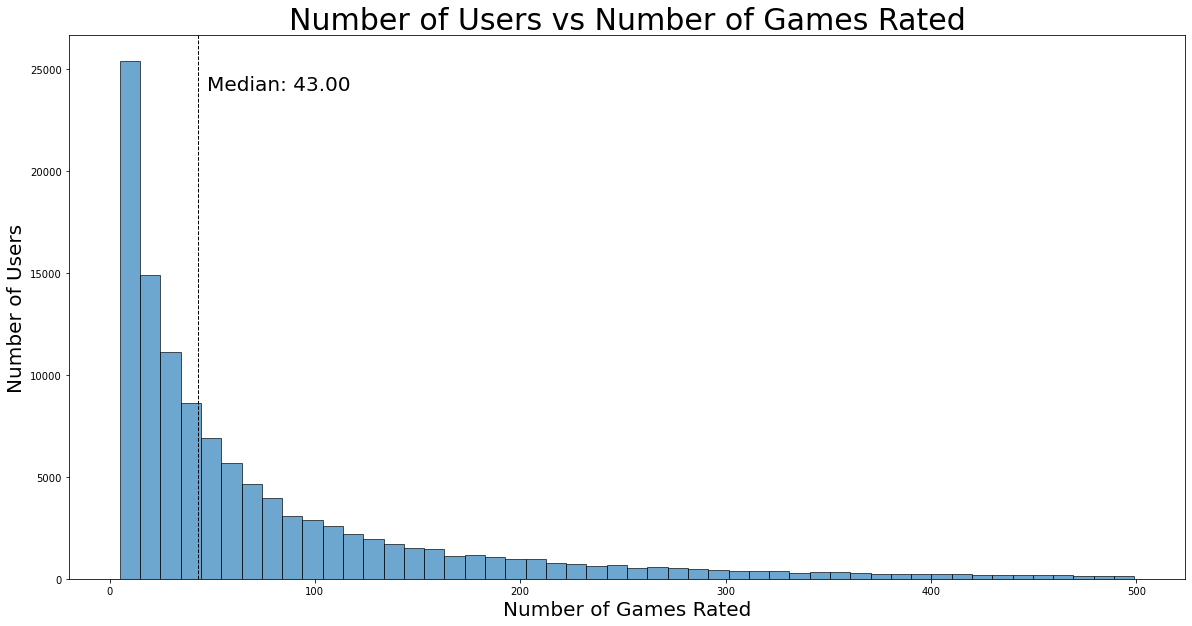

''

In [28]:
num_ratings = {}

for user in real_user_ratings_dictionary_scaled:
    num_ratings[user] = len(real_user_ratings_dictionary_scaled[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/usersvsrated.png')
plt.show()

;

In [29]:
# how many users under the median?

num_under_43 = num_ratings_df.loc[num_ratings_df[0]<=43][0].count()
num_under_43_perc = round((num_under_43/num_ratings_df.shape[0]*100), 2)
print(str(num_under_43)+" users with 43 or fewer ratings (median), comprising "+str(num_under_43_perc)+"% of users.")

59189 users with 43 or fewer ratings (median), comprising 50.48% of users.


In [30]:
# how many users under 20 ratings?

num_under_20 = num_ratings_df.loc[num_ratings_df[0]<=20][0].count()
num_under_20_perc = round(num_under_20/num_ratings_df.shape[0]*100, 2)
print(str(num_under_20)+" users with 20 or fewer ratings (median), comprising "+str(num_under_20_perc)+"% of users.")

34862 users with 20 or fewer ratings (median), comprising 29.73% of users.


In [31]:
# make lists of users under and over the median from the dataframe
users_under_median = list(num_ratings_df.loc[num_ratings_df[0]<=43]['index'])
users_over_median = list(num_ratings_df.loc[num_ratings_df[0]>43]['index'])

# now make a new list of validation users that are under and over the median
val_under_median = [item for item in users_under_median if item in val_users]
val_over_median = [item for item in users_over_median if item in val_users]

## Memory Based

Use statistical techniques on the dataset to calculate the predictions.

In plain english, the memory model works by finding a subset of neighbors where we have v items in common. Then we calculate our cosine similarity with each member of the subset, using only our items in common. After picking the closest k neighbors, we make recommendations using items with at least n ratings within the subset.

We have several parameters to tune for the memory-based model for each of our data sets. They are:

* v: How many items do we need to have in common to be neighbors?
* k: How many closest neighbors do I want to consider for making new recommendations?
* n: How many of the k neighbors need to have rated an item in order for a rating to be produced for me?

Steps:

* For each user_a that we want to make recommendations for:

    * Find users_b who have rated v items in common
    * for each user_b:
    
        * Calculate intersection of ratings for user_a and user_b with v minimum items
        * calculate cosine similarity between user_a and user_b
    
    * Determine k closest neighbors_k based on cosine similarity
    * for each item_i in the games dictionary,
        
        * if neighbor_k rated item_i, get their rating (weighted by their similarity)
        * predicted rating for item_i is average of all neighbor's ratings
    
    * get accuracy metrics for user_a based on predictions vs actual for user_a rated items
    * sort predicted rating items and show x top recommendations

How do I evaluate my recommender? What we really want is a high RECALL in addition to a "reasonable" error. With that in mind it's more important to make sure that a user's actual items are correctly categorized as "recommended", defined as being over the user's mean. We're also interested in a good amount of catalog coverage, and still a reasonable error. To that end, our evaluation metric is a custom metric based on weighted scores of error, recall, and coverage.

### Finding Optimal v, k and n

This section involves iterative grid searching on the previously mentioned parameters v, k and n. The search is performed on a smaller subset of 100 users. Not all searches are present in the cell below; search scores are tracked and saved to file and then reset in the same cell.

In [127]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [37]:
# set up score lists for grid searching, will append
vs_and_ks = []
mae_tracker = []
rmse_tracker = []
recall_tracker = []
catalog_coverage = []

In [61]:
# make our test set of 100 users
test_set = val_users[:100]

dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, real_distance_dictionary]

# searching the grid of v/k/n
for v in [15]:
    for k in [250]:
        for n in [5, 10, 15]:
            parameters = [v, k, n]
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            # This is the big function call which scores the set of users for given v, k, n
            global_mae, global_rmse, global_recall, user_predictions_real_basismemory, all_recommended_items = get_user_predictions(dictionary_set, test_set, parameters, synth=False)
            vs_and_ks.append(string)
            mae_tracker.append(global_mae)
            rmse_tracker.append(global_rmse)
            recall_tracker.append(global_recall)
            end = time.time() - start
            coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)
            catalog_coverage.append(coverage)


NameError: name 'real_distance_dictionary' is not defined

In [129]:
zipped = list(zip(mae_tracker, rmse_tracker, recall_tracker, catalog_coverage))
scores = pd.DataFrame(zipped, index=vs_and_ks, columns=['MAE', 'RMSE', 'Recall', 'Coverage']).sort_values('RMSE')
scores.to_pickle('real_scores_round1.pkl')

In [90]:
scores = pd.read_pickle('real_scores_round1.pkl')

error_weight = .3
recall_weight = 1
coverage_weight = .5

scores['Score'] = ((1-scores['RMSE'])*100)*error_weight + scores['Recall']*recall_weight + (scores['Coverage'])*coverage_weight
scores.sort_values('Score', ascending=False).head(30)


,MAE,RMSE,Recall,Coverage,Score
v7_k250_n5,0.576187,0.726385,62.362000,53.33,97.235440
v10_k250_n5,0.632934,0.793324,62.600600,56.53,97.065881
v5_k250_n5,0.510569,0.655304,60.974500,49.78,96.205393
v15_k250_n5,0.707410,0.883627,62.640400,58.08,95.171579
v10_k100_n5,0.628052,0.786928,64.573600,41.14,91.535760
v5_k250_n10,0.505076,0.647022,64.086200,31.09,90.220545
v7_k250_n10,0.563073,0.705536,63.867400,34.05,89.726327
v10_k250_n10,0.625930,0.779453,64.416800,36.13,89.098208
v5_k250_n15,0.498634,0.633307,66.105200,22.95,88.580977
v7_k100_n5,0.546782,0.696892,63.374600,30.88,87.907854


### Get Validation Scores

In [134]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_coverage = []

In [135]:
# define v, k, n
v, k, n = 7, 250, 5
parameters = [v, k, n]

In [136]:
# set up distance dictionary to populate which is a dictionary with an empty entry per user
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [137]:
# get the scores for the entire validation set
dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, real_distance_dictionary]

global_mae, global_rmse, global_recall, user_predictions_real_basismemory, items_in_set = get_user_predictions(dictionary_set, val_users, parameters, synth=False)

coverage = round(((len(items_in_set)/len(game_id_lookup))*100), 2)


real_mae.append(global_mae)
real_rmse.append(global_rmse)
real_recall.append(global_recall)
real_coverage.append(coverage)

7 250 5
Calculating Shade92008
Found 70820 potential neighbors in common at v: 7 k: 250 n:5
Calculating moosh21
Found 49709 potential neighbors in common at v: 7 k: 250 n:5
Calculating Threnody
Found 70142 potential neighbors in common at v: 7 k: 250 n:5
Calculating fremen1430
Found 741 potential neighbors in common at v: 7 k: 250 n:5
Calculating dwjmeijer
Found 51367 potential neighbors in common at v: 7 k: 250 n:5
Calculating fornacigiorgi
Found 512 potential neighbors in common at v: 7 k: 250 n:5
Calculating Kitte87
Found 12428 potential neighbors in common at v: 7 k: 250 n:5
Calculating UberK
Found 50971 potential neighbors in common at v: 7 k: 250 n:5
Calculating impliedmonkey
Found 46449 potential neighbors in common at v: 7 k: 250 n:5
Calculating NorthWestNerd
Found 1807 potential neighbors in common at v: 7 k: 250 n:5
Calculating PhasingPlayer
Found 84954 potential neighbors in common at v: 7 k: 250 n:5
Calculating naraakitsune
Found 15555 potential neighbors in common at v: 7 

Found 19562 potential neighbors in common at v: 7 k: 250 n:5
Calculating MerryMeeple
Found 18835 potential neighbors in common at v: 7 k: 250 n:5
Calculating ob1_kenobi18
Found 6279 potential neighbors in common at v: 7 k: 250 n:5
Calculating hencook
Found 35547 potential neighbors in common at v: 7 k: 250 n:5
Calculating SamC89
Found 1424 potential neighbors in common at v: 7 k: 250 n:5
Calculating klozhald
Found 2251 potential neighbors in common at v: 7 k: 250 n:5
Calculating dtodd3
Found 381 potential neighbors in common at v: 1 k: 250 n:5
Calculating DarthRevan343
Found 57797 potential neighbors in common at v: 7 k: 250 n:5
Calculating ltux
Found 26100 potential neighbors in common at v: 7 k: 250 n:5
Calculating mrprojectionist
Found 644 potential neighbors in common at v: 7 k: 250 n:5
Calculating baghaddur
Found 978 potential neighbors in common at v: 7 k: 250 n:5
Calculating silvax001
Found 16636 potential neighbors in common at v: 7 k: 250 n:5
Calculating CrystylRobyn
Found 127

Calculating iamlegionWEARE1
Found 2197 potential neighbors in common at v: 0 k: 250 n:5
Calculating BoshJeeples
Found 7526 potential neighbors in common at v: 7 k: 250 n:5
Calculating jpolitis
Found 4622 potential neighbors in common at v: 7 k: 250 n:5
Calculating bryceandcallie
Found 315 potential neighbors in common at v: 4 k: 250 n:5
Calculating EMPblast
Found 35701 potential neighbors in common at v: 7 k: 250 n:5
Calculating Veretax
Found 663 potential neighbors in common at v: 5 k: 250 n:5
Calculating BoardGameBarrage
Found 30140 potential neighbors in common at v: 7 k: 250 n:5
Calculating ryazii3000
Found 18549 potential neighbors in common at v: 7 k: 250 n:5
Calculating Toan
Found 12781 potential neighbors in common at v: 7 k: 250 n:5
Calculating pHiLL278
Found 26360 potential neighbors in common at v: 7 k: 250 n:5
Calculating theedj
Found 59902 potential neighbors in common at v: 7 k: 250 n:5
Calculating Svirt12
Found 20616 potential neighbors in common at v: 7 k: 250 n:5
Calcu

Calculating YazoJoe
Found 3119 potential neighbors in common at v: 7 k: 250 n:5
Calculating D Beau
Found 38539 potential neighbors in common at v: 7 k: 250 n:5
Calculating bspooky
Found 40571 potential neighbors in common at v: 7 k: 250 n:5
Calculating turbotix
Found 2245 potential neighbors in common at v: 7 k: 250 n:5
Calculating AJthebeard66
Found 41719 potential neighbors in common at v: 7 k: 250 n:5
Calculating Apcrs
Found 49159 potential neighbors in common at v: 7 k: 250 n:5
Calculating Ravensburg24
Found 78163 potential neighbors in common at v: 7 k: 250 n:5
Calculating say7788
Found 433 potential neighbors in common at v: 5 k: 250 n:5
Calculating MangaFox
Found 70990 potential neighbors in common at v: 7 k: 250 n:5
Calculating Kofola
Found 5627 potential neighbors in common at v: 7 k: 250 n:5
Calculating Scribal
Found 38696 potential neighbors in common at v: 7 k: 250 n:5
Calculating broknsword
Found 10026 potential neighbors in common at v: 7 k: 250 n:5
Calculating gos82
Foun

Calculating portos
Found 27846 potential neighbors in common at v: 7 k: 250 n:5
Calculating bombmk
Found 49341 potential neighbors in common at v: 7 k: 250 n:5
Calculating Emirence
Found 1792 potential neighbors in common at v: 2 k: 250 n:5
Calculating LarsG
Found 2534 potential neighbors in common at v: 0 k: 250 n:5
Calculating tico
Found 5587 potential neighbors in common at v: 7 k: 250 n:5
Calculating grazadberg
Found 779 potential neighbors in common at v: 3 k: 250 n:5
Calculating Rags_winkler
Found 14584 potential neighbors in common at v: 7 k: 250 n:5
Calculating snert99
Found 55426 potential neighbors in common at v: 7 k: 250 n:5
Calculating Savagecupid
Found 43220 potential neighbors in common at v: 7 k: 250 n:5
Calculating threedeeglasses
Found 366 potential neighbors in common at v: 7 k: 250 n:5
Calculating QueenPamedalah
Found 661 potential neighbors in common at v: 2 k: 250 n:5
Calculating Naggaroth76
Found 930 potential neighbors in common at v: 2 k: 250 n:5
Calculating my

Calculating pawlak
Found 8668 potential neighbors in common at v: 7 k: 250 n:5
Calculating tsmpaul
Found 254 potential neighbors in common at v: 5 k: 250 n:5
Calculating Atdbp1
Found 21834 potential neighbors in common at v: 7 k: 250 n:5
Calculating Anders_b
Found 697 potential neighbors in common at v: 5 k: 250 n:5
Calculating fiendling
Found 43554 potential neighbors in common at v: 7 k: 250 n:5
Calculating Schizotypy
Found 67520 potential neighbors in common at v: 7 k: 250 n:5
Calculating heruca
Found 281 potential neighbors in common at v: 6 k: 250 n:5
Calculating marcyordy
Found 4907 potential neighbors in common at v: 7 k: 250 n:5
Calculating Fraenze
Found 1565 potential neighbors in common at v: 7 k: 250 n:5
Calculating iamalias
Found 7562 potential neighbors in common at v: 7 k: 250 n:5
Calculating robla5
Found 458 potential neighbors in common at v: 3 k: 250 n:5
Calculating wes6419
Found 23173 potential neighbors in common at v: 7 k: 250 n:5
Calculating barbjeff00
Found 513 po

Calculating imbatm4x
Found 621 potential neighbors in common at v: 5 k: 250 n:5
Calculating zambodam
Found 61577 potential neighbors in common at v: 7 k: 250 n:5
Calculating Startlingteedee
Found 52148 potential neighbors in common at v: 7 k: 250 n:5
Calculating thunderbirds are go
Found 2920 potential neighbors in common at v: 7 k: 250 n:5
Calculating Saeter
Found 47534 potential neighbors in common at v: 7 k: 250 n:5
Calculating Madnapali
Found 24488 potential neighbors in common at v: 7 k: 250 n:5
Calculating rkfan
Found 80021 potential neighbors in common at v: 7 k: 250 n:5
Calculating TheReluctantGeneral
Found 1650 potential neighbors in common at v: 7 k: 250 n:5
Calculating neoOberon
Found 40528 potential neighbors in common at v: 7 k: 250 n:5
Calculating FrankieDFrancis
Found 336 potential neighbors in common at v: 6 k: 250 n:5
Calculating MrsSpliff
Found 43301 potential neighbors in common at v: 7 k: 250 n:5
Calculating Gromguitar4
Found 28949 potential neighbors in common at v

Calculating lord amami
Found 24153 potential neighbors in common at v: 7 k: 250 n:5
Calculating Gentrifuge
Found 13466 potential neighbors in common at v: 7 k: 250 n:5
Calculating Martstell
Found 10015 potential neighbors in common at v: 7 k: 250 n:5
Calculating Nedre
Found 32241 potential neighbors in common at v: 7 k: 250 n:5
Calculating Nojvok
Found 734 potential neighbors in common at v: 5 k: 250 n:5
Calculating juhirvon
Found 4260 potential neighbors in common at v: 7 k: 250 n:5
Calculating MrBaggy
Found 66756 potential neighbors in common at v: 7 k: 250 n:5
Calculating ju012835
Found 71094 potential neighbors in common at v: 7 k: 250 n:5
Calculating Shardok
Found 745 potential neighbors in common at v: 4 k: 250 n:5
Calculating toasterpastry
Found 52636 potential neighbors in common at v: 7 k: 250 n:5
Calculating inmysights
Found 10753 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dmurtri
Found 49649 potential neighbors in common at v: 7 k: 250 n:5
Calculating Slim 

Calculating realddrjiun
Found 28076 potential neighbors in common at v: 7 k: 250 n:5
Calculating chris_arsenal
Found 56190 potential neighbors in common at v: 7 k: 250 n:5
Calculating DarqFeyth
Found 11204 potential neighbors in common at v: 7 k: 250 n:5
Calculating Boris_13
Found 409 potential neighbors in common at v: 7 k: 250 n:5
Calculating glsonn
Found 73121 potential neighbors in common at v: 7 k: 250 n:5
Calculating Kostanery
Found 864 potential neighbors in common at v: 7 k: 250 n:5
Calculating chard_hammer
Found 527 potential neighbors in common at v: 2 k: 250 n:5
Calculating jtuck19
Found 19182 potential neighbors in common at v: 7 k: 250 n:5
Calculating RlyehExiled
Found 9657 potential neighbors in common at v: 7 k: 250 n:5
Calculating ckoehler13
Found 573 potential neighbors in common at v: 2 k: 250 n:5
Calculating TimeScout1
Found 18999 potential neighbors in common at v: 7 k: 250 n:5
Calculating Typh
Found 45962 potential neighbors in common at v: 7 k: 250 n:5
Calculating

Calculating Pierchon
Found 2308 potential neighbors in common at v: 7 k: 250 n:5
Calculating AceHenshin
Found 37742 potential neighbors in common at v: 7 k: 250 n:5
Calculating slimcharles42
Found 30059 potential neighbors in common at v: 7 k: 250 n:5
Calculating ACK ACK
Found 13025 potential neighbors in common at v: 7 k: 250 n:5
Calculating dsvejda
Found 43695 potential neighbors in common at v: 7 k: 250 n:5
Calculating Bantha3
Found 1396 potential neighbors in common at v: 7 k: 250 n:5
Calculating xanderp
Found 6975 potential neighbors in common at v: 7 k: 250 n:5
Calculating Roksteady
Found 11370 potential neighbors in common at v: 7 k: 250 n:5
Calculating klocks
Found 13129 potential neighbors in common at v: 7 k: 250 n:5
Calculating zkBoy
Found 57233 potential neighbors in common at v: 7 k: 250 n:5
Calculating MisplacedWorker
Found 64435 potential neighbors in common at v: 7 k: 250 n:5
Calculating SwissBeekeeper
Found 5133 potential neighbors in common at v: 7 k: 250 n:5
Calculat

Found 849 potential neighbors in common at v: 5 k: 250 n:5
Calculating DanCyDore
Found 25773 potential neighbors in common at v: 7 k: 250 n:5
Calculating Athyra
Found 44586 potential neighbors in common at v: 7 k: 250 n:5
Calculating theansweris4ty2
Found 34169 potential neighbors in common at v: 7 k: 250 n:5
Calculating GuiseKnights
Found 3993 potential neighbors in common at v: 7 k: 250 n:5
Calculating dehnis82
Found 22499 potential neighbors in common at v: 7 k: 250 n:5
Calculating multi_killer
Found 64565 potential neighbors in common at v: 7 k: 250 n:5
Calculating sensfantodd
Found 334 potential neighbors in common at v: 5 k: 250 n:5
Calculating mwonham
Found 850 potential neighbors in common at v: 7 k: 250 n:5
Calculating Chiken Bird
Found 4839 potential neighbors in common at v: 7 k: 250 n:5
Calculating T3tsuo
Found 15709 potential neighbors in common at v: 7 k: 250 n:5
Calculating RichGarner71
Found 724 potential neighbors in common at v: 7 k: 250 n:5
Calculating davbart
Found 

Calculating greppo
Found 717 potential neighbors in common at v: 6 k: 250 n:5
Calculating Tomibiker
Found 297 potential neighbors in common at v: 1 k: 250 n:5
Calculating Everlasting751
Found 44983 potential neighbors in common at v: 7 k: 250 n:5
Calculating Mahoney
Found 517 potential neighbors in common at v: 4 k: 250 n:5
Calculating plspencer
Found 28991 potential neighbors in common at v: 7 k: 250 n:5
Calculating scottf0rd
Found 73006 potential neighbors in common at v: 7 k: 250 n:5
Calculating CelestialWillow
Found 31097 potential neighbors in common at v: 7 k: 250 n:5
Calculating Caramelz
Found 8072 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dan Johansson
Found 81429 potential neighbors in common at v: 7 k: 250 n:5
Calculating airmanwhit
Found 29309 potential neighbors in common at v: 7 k: 250 n:5
Calculating zottirgen
Found 80895 potential neighbors in common at v: 7 k: 250 n:5
Calculating vic2vik
Found 585 potential neighbors in common at v: 6 k: 250 n:5
Calcu

Found 8129 potential neighbors in common at v: 7 k: 250 n:5
Calculating cthulhus_pinky
Found 31718 potential neighbors in common at v: 7 k: 250 n:5
Calculating Wyvern1
Found 3103 potential neighbors in common at v: 7 k: 250 n:5
Calculating forsytjr
Found 38953 potential neighbors in common at v: 7 k: 250 n:5
Calculating StephenM
Found 65730 potential neighbors in common at v: 7 k: 250 n:5
Calculating skyrios
Found 9414 potential neighbors in common at v: 7 k: 250 n:5
Calculating HisDudeness3008
Found 4049 potential neighbors in common at v: 2 k: 250 n:5
Calculating UnknownAmnesiac
Found 557 potential neighbors in common at v: 7 k: 250 n:5
Calculating Souljazz
Found 6734 potential neighbors in common at v: 7 k: 250 n:5
Calculating Madhouse Ink
Found 11081 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dmmaus
Found 29892 potential neighbors in common at v: 7 k: 250 n:5
Calculating Johnkangw
Found 9589 potential neighbors in common at v: 7 k: 250 n:5
Calculating GlennG
Found

Calculating LaknerBali
Found 416 potential neighbors in common at v: 5 k: 250 n:5
Calculating Dumas103
Found 3129 potential neighbors in common at v: 7 k: 250 n:5
Calculating Zarquon3
Found 33949 potential neighbors in common at v: 7 k: 250 n:5
Calculating MarcyDarcy
Found 34702 potential neighbors in common at v: 7 k: 250 n:5
Calculating rcfrey
Found 6453 potential neighbors in common at v: 7 k: 250 n:5
Calculating bigcatof77
Found 18536 potential neighbors in common at v: 7 k: 250 n:5
Calculating wolvzbane
Found 727 potential neighbors in common at v: 2 k: 250 n:5
Calculating marcomarcomar
Found 22251 potential neighbors in common at v: 7 k: 250 n:5
Calculating wolverdean
Found 14367 potential neighbors in common at v: 7 k: 250 n:5
Calculating Waylander12
Found 27291 potential neighbors in common at v: 7 k: 250 n:5
Calculating Ullysses05
Found 295 potential neighbors in common at v: 7 k: 250 n:5
Calculating Drymn
Found 63560 potential neighbors in common at v: 7 k: 250 n:5
Calculatin

Calculating GuyGotGuns
Found 1103 potential neighbors in common at v: 4 k: 250 n:5
Calculating keruken
Found 263 potential neighbors in common at v: 7 k: 250 n:5
Calculating Moradin
Found 6042 potential neighbors in common at v: 7 k: 250 n:5
Calculating Fuscus
Found 31112 potential neighbors in common at v: 7 k: 250 n:5
Calculating Wulffman
Found 1917 potential neighbors in common at v: 7 k: 250 n:5
Calculating Trampojunk
Found 1134 potential neighbors in common at v: 3 k: 250 n:5
Calculating teza59
Found 17484 potential neighbors in common at v: 7 k: 250 n:5
Calculating fillac
Found 33903 potential neighbors in common at v: 7 k: 250 n:5
Calculating decomouse
Found 353 potential neighbors in common at v: 5 k: 250 n:5
Calculating rmoll
Found 14613 potential neighbors in common at v: 7 k: 250 n:5
Calculating thetikilounge
Found 28557 potential neighbors in common at v: 7 k: 250 n:5
Calculating EquinoxOmega
Found 46760 potential neighbors in common at v: 7 k: 250 n:5
Calculating shichigat

Found 481 potential neighbors in common at v: 7 k: 250 n:5
Calculating SalladDazed
Found 33561 potential neighbors in common at v: 7 k: 250 n:5
Calculating moylien
Found 15699 potential neighbors in common at v: 7 k: 250 n:5
Calculating MostlyMandy
Found 1514 potential neighbors in common at v: 2 k: 250 n:5
Calculating awezoom
Found 23673 potential neighbors in common at v: 7 k: 250 n:5
Calculating Geeky_Frignit
Found 41180 potential neighbors in common at v: 7 k: 250 n:5
Calculating DNAcriminalist
Found 2245 potential neighbors in common at v: 1 k: 250 n:5
Calculating PirateFlint
Found 890 potential neighbors in common at v: 7 k: 250 n:5
Calculating Helmet Moncee
Found 44037 potential neighbors in common at v: 7 k: 250 n:5
Calculating wabisabi
Found 37167 potential neighbors in common at v: 7 k: 250 n:5
Calculating Ambiryan13
Found 54581 potential neighbors in common at v: 7 k: 250 n:5
Calculating TastyPotatoX
Found 9854 potential neighbors in common at v: 7 k: 250 n:5
Calculating nac

Found 9923 potential neighbors in common at v: 7 k: 250 n:5
Calculating Roshz
Found 37392 potential neighbors in common at v: 7 k: 250 n:5
Calculating lucabrl
Found 45563 potential neighbors in common at v: 7 k: 250 n:5
Calculating scalpa
Found 67153 potential neighbors in common at v: 7 k: 250 n:5
Calculating CerealKiller11
Found 66998 potential neighbors in common at v: 7 k: 250 n:5
Calculating Tintazul
Found 50624 potential neighbors in common at v: 7 k: 250 n:5
Calculating Tommeleus
Found 1442 potential neighbors in common at v: 7 k: 250 n:5
Calculating LirdFishen
Found 42037 potential neighbors in common at v: 7 k: 250 n:5
Calculating HumanoIT
Found 61300 potential neighbors in common at v: 7 k: 250 n:5
Calculating FAKEDETH
Found 20560 potential neighbors in common at v: 7 k: 250 n:5
Calculating kaz honda
Found 39710 potential neighbors in common at v: 7 k: 250 n:5
Calculating CUViking
Found 2404 potential neighbors in common at v: 7 k: 250 n:5
Calculating sessil_u
Found 7942 pote

Found 253 potential neighbors in common at v: 7 k: 250 n:5
Calculating Captain Asparagus
Found 21732 potential neighbors in common at v: 7 k: 250 n:5
Calculating CandymanGT4
Found 519 potential neighbors in common at v: 6 k: 250 n:5
Calculating doxsee
Found 20801 potential neighbors in common at v: 7 k: 250 n:5
Calculating flott
Found 55830 potential neighbors in common at v: 7 k: 250 n:5
Calculating pfeiler30
Found 57980 potential neighbors in common at v: 7 k: 250 n:5
Calculating leo1984
Found 473 potential neighbors in common at v: 5 k: 250 n:5
Calculating account4robert
Found 5149 potential neighbors in common at v: 7 k: 250 n:5
Calculating Iriska
Found 16301 potential neighbors in common at v: 7 k: 250 n:5
Calculating ftrimble
Found 38708 potential neighbors in common at v: 7 k: 250 n:5
Calculating guitarpro77
Found 26688 potential neighbors in common at v: 7 k: 250 n:5
Calculating carrickfergus
Found 52025 potential neighbors in common at v: 7 k: 250 n:5
Calculating kazu
Found 75

Calculating merkulo
Found 63331 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dowlow
Found 866 potential neighbors in common at v: 4 k: 250 n:5
Calculating marc8779
Found 64324 potential neighbors in common at v: 7 k: 250 n:5
Calculating aragorndeux
Found 35786 potential neighbors in common at v: 7 k: 250 n:5
Calculating alexinoue
Found 2477 potential neighbors in common at v: 7 k: 250 n:5
Calculating ukcody34
Found 48611 potential neighbors in common at v: 7 k: 250 n:5
Calculating bugsnnuts
Found 30378 potential neighbors in common at v: 7 k: 250 n:5
Calculating matej212
Found 12692 potential neighbors in common at v: 7 k: 250 n:5
Calculating oLillyver
Found 31602 potential neighbors in common at v: 7 k: 250 n:5
Calculating chitshappen
Found 50253 potential neighbors in common at v: 7 k: 250 n:5
Calculating ryanmp40
Found 58649 potential neighbors in common at v: 7 k: 250 n:5
Calculating BoardGameRick
Found 534 potential neighbors in common at v: 7 k: 250 n:5
Calculatin

Calculating fadeproofvision
Found 65735 potential neighbors in common at v: 7 k: 250 n:5
Calculating lsdza
Found 41196 potential neighbors in common at v: 7 k: 250 n:5
Calculating ErikRuud
Found 3643 potential neighbors in common at v: 7 k: 250 n:5
Calculating Lynn255
Found 20049 potential neighbors in common at v: 7 k: 250 n:5
Calculating krugerheini
Found 1412 potential neighbors in common at v: 4 k: 250 n:5
Calculating wiredmaverick
Found 11104 potential neighbors in common at v: 7 k: 250 n:5
Calculating bulldog93
Found 405 potential neighbors in common at v: 2 k: 250 n:5
Calculating Kubanzo
Found 59719 potential neighbors in common at v: 7 k: 250 n:5
Calculating abbeb
Found 37156 potential neighbors in common at v: 7 k: 250 n:5
Calculating CritPanic
Found 14425 potential neighbors in common at v: 7 k: 250 n:5
Calculating limmyfox
Found 48873 potential neighbors in common at v: 7 k: 250 n:5
Calculating hatamoto
Found 27126 potential neighbors in common at v: 7 k: 250 n:5
Calculating

Calculating Vanhelsing76
Found 13474 potential neighbors in common at v: 7 k: 250 n:5
Calculating RaiPL
Found 62539 potential neighbors in common at v: 7 k: 250 n:5
Calculating bgoliveira
Found 1034 potential neighbors in common at v: 7 k: 250 n:5
Calculating chriskrum
Found 450 potential neighbors in common at v: 6 k: 250 n:5
Calculating ixetreize
Found 14630 potential neighbors in common at v: 7 k: 250 n:5
Calculating lbc2000
Found 532 potential neighbors in common at v: 3 k: 250 n:5
Calculating Professor_Frink
Found 58660 potential neighbors in common at v: 7 k: 250 n:5
Calculating SKempen21
Found 345 potential neighbors in common at v: 3 k: 250 n:5
Calculating Jim_Lucas
Found 6228 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dethras
Found 9538 potential neighbors in common at v: 7 k: 250 n:5
Calculating Overrun27
Found 11386 potential neighbors in common at v: 7 k: 250 n:5
Calculating JMthePhilosopher
Found 21582 potential neighbors in common at v: 7 k: 250 n:5
Calc

Found 34582 potential neighbors in common at v: 7 k: 250 n:5
Calculating CalSara
Found 42574 potential neighbors in common at v: 7 k: 250 n:5
Calculating Odiousmaximus
Found 2400 potential neighbors in common at v: 7 k: 250 n:5
Calculating dwag44
Found 40666 potential neighbors in common at v: 7 k: 250 n:5
Calculating lagopodous
Found 327 potential neighbors in common at v: 4 k: 250 n:5
Calculating pkamppur
Found 19271 potential neighbors in common at v: 7 k: 250 n:5
Calculating kramer
Found 19121 potential neighbors in common at v: 7 k: 250 n:5
Calculating Soul_Guile
Found 46437 potential neighbors in common at v: 7 k: 250 n:5
Calculating TomKat87
Found 56231 potential neighbors in common at v: 7 k: 250 n:5
Calculating jneuf
Found 72026 potential neighbors in common at v: 7 k: 250 n:5
Calculating Orntt
Found 55807 potential neighbors in common at v: 7 k: 250 n:5
Calculating Eric Ridley
Found 76960 potential neighbors in common at v: 7 k: 250 n:5
Calculating ProjektTHOR
Found 45126 pot

Found 948 potential neighbors in common at v: 7 k: 250 n:5
Calculating omniboo
Found 55703 potential neighbors in common at v: 7 k: 250 n:5
Calculating hobbitg
Found 61612 potential neighbors in common at v: 7 k: 250 n:5
Calculating holdthemayo
Found 35415 potential neighbors in common at v: 7 k: 250 n:5
Calculating xpsdude
Found 24928 potential neighbors in common at v: 7 k: 250 n:5
Calculating tinkertownbalderdash
Found 9160 potential neighbors in common at v: 7 k: 250 n:5
Calculating TheSolarGarlic
Found 86899 potential neighbors in common at v: 7 k: 250 n:5
Calculating cer7
Found 1571 potential neighbors in common at v: 7 k: 250 n:5
Calculating hamishmiles
Found 15307 potential neighbors in common at v: 7 k: 250 n:5
Calculating gabemarriage
Found 553 potential neighbors in common at v: 4 k: 250 n:5
Calculating Dracura
Found 17595 potential neighbors in common at v: 7 k: 250 n:5
Calculating manolovila
Found 42684 potential neighbors in common at v: 7 k: 250 n:5
Calculating murban3
F

Calculating thereisnotry
Found 15230 potential neighbors in common at v: 7 k: 250 n:5
Calculating DJ85
Found 32585 potential neighbors in common at v: 7 k: 250 n:5
Calculating Clive8047
Found 1926 potential neighbors in common at v: 7 k: 250 n:5
Calculating baconforall
Found 41465 potential neighbors in common at v: 7 k: 250 n:5
Calculating txnetwolf
Found 1304 potential neighbors in common at v: 2 k: 250 n:5
Calculating bucky_85210
Found 862 potential neighbors in common at v: 3 k: 250 n:5
Calculating Vicleon
Found 39864 potential neighbors in common at v: 7 k: 250 n:5
Calculating S5una
Found 392 potential neighbors in common at v: 7 k: 250 n:5
Calculating Nicade
Found 12381 potential neighbors in common at v: 7 k: 250 n:5
Calculating kenes35
Found 74129 potential neighbors in common at v: 7 k: 250 n:5
Calculating PolarityHouse
Found 1271 potential neighbors in common at v: 4 k: 250 n:5
Calculating mandycandyland
Found 18457 potential neighbors in common at v: 7 k: 250 n:5
Calculating

Calculating fofluff
Found 45111 potential neighbors in common at v: 7 k: 250 n:5
Calculating zarsejm
Found 49317 potential neighbors in common at v: 7 k: 250 n:5
Calculating ice2cold
Found 70782 potential neighbors in common at v: 7 k: 250 n:5
Calculating Nydo
Found 55800 potential neighbors in common at v: 7 k: 250 n:5
Calculating senechaux
Found 36925 potential neighbors in common at v: 7 k: 250 n:5
Calculating bigcosmicnut
Found 24462 potential neighbors in common at v: 7 k: 250 n:5
Calculating Singletrack13
Found 24150 potential neighbors in common at v: 7 k: 250 n:5
Calculating jpbookworm
Found 27164 potential neighbors in common at v: 7 k: 250 n:5
Calculating barry_luo
Found 57315 potential neighbors in common at v: 7 k: 250 n:5
Calculating Tim Bushman
Found 4913 potential neighbors in common at v: 7 k: 250 n:5
Calculating PoisonKiwi
Found 72509 potential neighbors in common at v: 7 k: 250 n:5
Calculating golfprodunkey
Found 62803 potential neighbors in common at v: 7 k: 250 n:5


Calculating ManolisKK
Found 73552 potential neighbors in common at v: 7 k: 250 n:5
Calculating NevoGamer
Found 52017 potential neighbors in common at v: 7 k: 250 n:5
Calculating Zouna
Found 371 potential neighbors in common at v: 5 k: 250 n:5
Calculating Altaica27
Found 46403 potential neighbors in common at v: 7 k: 250 n:5
Calculating chaka192
Found 8688 potential neighbors in common at v: 7 k: 250 n:5
Calculating kumbil
Found 718 potential neighbors in common at v: 7 k: 250 n:5
Calculating jtsmith1484
Found 41728 potential neighbors in common at v: 7 k: 250 n:5
Calculating matrix1970
Found 10422 potential neighbors in common at v: 7 k: 250 n:5
Calculating zRuslan
Found 36231 potential neighbors in common at v: 7 k: 250 n:5
Calculating sabode
Found 51758 potential neighbors in common at v: 7 k: 250 n:5
Calculating dipplestix
Found 38382 potential neighbors in common at v: 7 k: 250 n:5
Calculating Cookiejar
Found 17840 potential neighbors in common at v: 7 k: 250 n:5
Calculating Torti9

Calculating mattbagni
Found 56532 potential neighbors in common at v: 7 k: 250 n:5
Calculating pi_matt
Found 36762 potential neighbors in common at v: 7 k: 250 n:5
Calculating crazygames
Found 60057 potential neighbors in common at v: 7 k: 250 n:5
Calculating voidfox
Found 8511 potential neighbors in common at v: 7 k: 250 n:5
Calculating Amills
Found 21200 potential neighbors in common at v: 7 k: 250 n:5
Calculating RobertBrandon
Found 51438 potential neighbors in common at v: 7 k: 250 n:5
Calculating dlugo11
Found 7567 potential neighbors in common at v: 7 k: 250 n:5
Calculating homeksmith
Found 46124 potential neighbors in common at v: 7 k: 250 n:5
Calculating Slayer99
Found 13220 potential neighbors in common at v: 7 k: 250 n:5
Calculating gospodyina
Found 39082 potential neighbors in common at v: 7 k: 250 n:5
Calculating Teodosio
Found 7242 potential neighbors in common at v: 7 k: 250 n:5
Calculating hpsp
Found 34764 potential neighbors in common at v: 7 k: 250 n:5
Calculating Tjol

Calculating Heroofsalt
Found 30784 potential neighbors in common at v: 7 k: 250 n:5
Calculating zumba
Found 80061 potential neighbors in common at v: 7 k: 250 n:5
Calculating rxh2121
Found 7901 potential neighbors in common at v: 7 k: 250 n:5
Calculating Axelfudge
Found 3335 potential neighbors in common at v: 7 k: 250 n:5
Calculating Flywheel
Found 442 potential neighbors in common at v: 2 k: 250 n:5
Calculating flying_neko
Found 68555 potential neighbors in common at v: 7 k: 250 n:5
Calculating yankeeap
Found 68475 potential neighbors in common at v: 7 k: 250 n:5
Calculating Lyyty
Found 32192 potential neighbors in common at v: 7 k: 250 n:5
Calculating DragoonTM
Found 557 potential neighbors in common at v: 4 k: 250 n:5
Calculating Onyons
Found 8732 potential neighbors in common at v: 7 k: 250 n:5
Calculating Zosnafu
Found 47057 potential neighbors in common at v: 7 k: 250 n:5
Calculating konajava
Found 645 potential neighbors in common at v: 1 k: 250 n:5
Calculating TungstenTuner
Fo

Calculating shwayne
Found 12074 potential neighbors in common at v: 7 k: 250 n:5
Calculating Japie78
Found 38850 potential neighbors in common at v: 7 k: 250 n:5
Calculating Sdan
Found 38946 potential neighbors in common at v: 7 k: 250 n:5
Calculating theschaitel
Found 2663 potential neighbors in common at v: 2 k: 250 n:5
Calculating crawfish7
Found 5241 potential neighbors in common at v: 7 k: 250 n:5
Calculating entraentrance
Found 1013 potential neighbors in common at v: 4 k: 250 n:5
Calculating thugbert
Found 78620 potential neighbors in common at v: 7 k: 250 n:5
Calculating S1mk1n
Found 72212 potential neighbors in common at v: 7 k: 250 n:5
Calculating mholzma
Found 56884 potential neighbors in common at v: 7 k: 250 n:5
Calculating kakawette
Found 60828 potential neighbors in common at v: 7 k: 250 n:5
Calculating Anarchosyn
Found 59212 potential neighbors in common at v: 7 k: 250 n:5
Calculating moriarty
Found 38510 potential neighbors in common at v: 7 k: 250 n:5
Calculating Java

Calculating CharlyCRM
Found 892 potential neighbors in common at v: 7 k: 250 n:5
Calculating HikerHistorian
Found 706 potential neighbors in common at v: 1 k: 250 n:5
Calculating BurntIsland
Found 40685 potential neighbors in common at v: 7 k: 250 n:5
Calculating ludovicocre
Found 46346 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dave Pike
Found 53817 potential neighbors in common at v: 7 k: 250 n:5
Calculating ciumetele
Found 383 potential neighbors in common at v: 6 k: 250 n:5
Calculating i12bnmovie
Found 35160 potential neighbors in common at v: 7 k: 250 n:5
Calculating Djours
Found 23081 potential neighbors in common at v: 7 k: 250 n:5
Calculating Rubster
Found 14314 potential neighbors in common at v: 7 k: 250 n:5
Calculating Rainstar
Found 73486 potential neighbors in common at v: 7 k: 250 n:5
Calculating kratosjr
Found 69881 potential neighbors in common at v: 7 k: 250 n:5
Calculating meesterzeeman
Found 9473 potential neighbors in common at v: 7 k: 250 n:5
Calc

Found 3219 potential neighbors in common at v: 7 k: 250 n:5
Calculating mr_mrholmes
Found 81614 potential neighbors in common at v: 7 k: 250 n:5
Calculating ravenpolar
Found 83922 potential neighbors in common at v: 7 k: 250 n:5
Calculating BloodScribe_DJ
Found 1639 potential neighbors in common at v: 3 k: 250 n:5
Calculating tedpwddz
Found 41042 potential neighbors in common at v: 7 k: 250 n:5
Calculating fissionessence
Found 55205 potential neighbors in common at v: 7 k: 250 n:5
Calculating shroud
Found 44577 potential neighbors in common at v: 7 k: 250 n:5
Calculating GodHand
Found 31818 potential neighbors in common at v: 7 k: 250 n:5
Calculating mazeuro
Found 328 potential neighbors in common at v: 3 k: 250 n:5
Calculating gmoneyace
Found 23894 potential neighbors in common at v: 7 k: 250 n:5
Calculating bloodlord
Found 51069 potential neighbors in common at v: 7 k: 250 n:5
Calculating taaltos
Found 345 potential neighbors in common at v: 3 k: 250 n:5
Calculating Delboy
Found 457 

Calculating Ancsuli
Found 280 potential neighbors in common at v: 5 k: 250 n:5
Calculating tycygo
Found 47912 potential neighbors in common at v: 7 k: 250 n:5
Calculating lomek
Found 50360 potential neighbors in common at v: 7 k: 250 n:5
Calculating gevati
Found 72222 potential neighbors in common at v: 7 k: 250 n:5
Calculating Jexik
Found 46269 potential neighbors in common at v: 7 k: 250 n:5
Calculating Nyom7
Found 23052 potential neighbors in common at v: 7 k: 250 n:5
Calculating pastej
Found 76118 potential neighbors in common at v: 7 k: 250 n:5
Calculating brascalungo
Found 14193 potential neighbors in common at v: 7 k: 250 n:5
Calculating Sean Aaberg
Found 600 potential neighbors in common at v: 2 k: 250 n:5
Calculating AlreadyPicked
Found 35751 potential neighbors in common at v: 7 k: 250 n:5
Calculating nothingmuch
Found 379 potential neighbors in common at v: 4 k: 250 n:5
Calculating BandWplaysgames
Found 606 potential neighbors in common at v: 4 k: 250 n:5
Calculating Raptorb

Calculating Sh4ggy
Found 17755 potential neighbors in common at v: 7 k: 250 n:5
Calculating owlqueen
Found 1242 potential neighbors in common at v: 6 k: 250 n:5
Calculating mike513
Found 1070 potential neighbors in common at v: 5 k: 250 n:5
Calculating PeteyPie
Found 25707 potential neighbors in common at v: 7 k: 250 n:5
Calculating mairiruth
Found 3459 potential neighbors in common at v: 7 k: 250 n:5
Calculating J87475
Found 3493 potential neighbors in common at v: 7 k: 250 n:5
Calculating Betippens
Found 73827 potential neighbors in common at v: 7 k: 250 n:5
Calculating Sharon1026
Found 1113 potential neighbors in common at v: 5 k: 250 n:5
Calculating Njoror
Found 362 potential neighbors in common at v: 4 k: 250 n:5
Calculating kennydee
Found 9135 potential neighbors in common at v: 7 k: 250 n:5
Calculating Lisa204
Found 33900 potential neighbors in common at v: 7 k: 250 n:5
Calculating XgamasenninX
Found 340 potential neighbors in common at v: 5 k: 250 n:5
Calculating MountaintopGam

Calculating aaron216
Found 13515 potential neighbors in common at v: 7 k: 250 n:5
Calculating mike3012
Found 37626 potential neighbors in common at v: 7 k: 250 n:5
Calculating Hakoon
Found 38560 potential neighbors in common at v: 7 k: 250 n:5
Calculating ChargeTheCannons
Found 2321 potential neighbors in common at v: 7 k: 250 n:5
Calculating SSShanu
Found 59817 potential neighbors in common at v: 7 k: 250 n:5
Calculating Pateke
Found 44189 potential neighbors in common at v: 7 k: 250 n:5
Calculating ophion
Found 888 potential neighbors in common at v: 7 k: 250 n:5
Calculating dkoron
Found 1826 potential neighbors in common at v: 7 k: 250 n:5
Calculating MadMaex
Found 358 potential neighbors in common at v: 3 k: 250 n:5
Calculating derekross88
Found 1087 potential neighbors in common at v: 2 k: 250 n:5
Calculating glocks4interns
Found 21224 potential neighbors in common at v: 7 k: 250 n:5
Calculating gkarlos
Found 1083 potential neighbors in common at v: 7 k: 250 n:5
Calculating robzor

Calculating keithalexmiller
Found 32824 potential neighbors in common at v: 7 k: 250 n:5
Calculating Dragon7398
Found 79298 potential neighbors in common at v: 7 k: 250 n:5
Calculating hartzella
Found 5899 potential neighbors in common at v: 7 k: 250 n:5
Calculating cmaro
Found 16158 potential neighbors in common at v: 7 k: 250 n:5
Calculating raaz42
Found 44062 potential neighbors in common at v: 7 k: 250 n:5
Calculating kmusser
Found 55152 potential neighbors in common at v: 7 k: 250 n:5
Calculating Matrac
Found 1641 potential neighbors in common at v: 4 k: 250 n:5
Calculating shoochuk
Found 45014 potential neighbors in common at v: 7 k: 250 n:5
Calculating kedler
Found 73678 potential neighbors in common at v: 7 k: 250 n:5
Calculating halforange
Found 41687 potential neighbors in common at v: 7 k: 250 n:5
Calculating bigjimbo
Found 18767 potential neighbors in common at v: 7 k: 250 n:5
Calculating IncHulkFan
Found 70352 potential neighbors in common at v: 7 k: 250 n:5
Calculating wo

Calculating Trevinsky
Found 53804 potential neighbors in common at v: 7 k: 250 n:5
Calculating ligerslayer
Found 19792 potential neighbors in common at v: 7 k: 250 n:5
Calculating Shadowelectric
Found 25521 potential neighbors in common at v: 7 k: 250 n:5
Calculating errorwick
Found 1056 potential neighbors in common at v: 7 k: 250 n:5
Calculating eddward_huang
Found 45813 potential neighbors in common at v: 7 k: 250 n:5
Calculating Gorogb
Found 43651 potential neighbors in common at v: 7 k: 250 n:5
Calculating catsgamesbooks
Found 3333 potential neighbors in common at v: 7 k: 250 n:5
Calculating InsaneHerald
Found 294 potential neighbors in common at v: 4 k: 250 n:5
Calculating SeriousScribbler
Found 55226 potential neighbors in common at v: 7 k: 250 n:5
Calculating Inthangast
Found 36793 potential neighbors in common at v: 7 k: 250 n:5
Calculating Audacon
Found 67924 potential neighbors in common at v: 7 k: 250 n:5
Calculating rvlieshout
Found 83552 potential neighbors in common at v

Calculating L_eendje
Found 8273 potential neighbors in common at v: 7 k: 250 n:5
Calculating insaneskiierdude
Found 578 potential neighbors in common at v: 4 k: 250 n:5
Calculating polycrafty
Found 66753 potential neighbors in common at v: 7 k: 250 n:5
Calculating surly panda
Found 12856 potential neighbors in common at v: 7 k: 250 n:5
Calculating tiigrikutzu
Found 74848 potential neighbors in common at v: 7 k: 250 n:5
Calculating ELink2k
Found 56276 potential neighbors in common at v: 7 k: 250 n:5
Calculating shuri5
Found 7269 potential neighbors in common at v: 7 k: 250 n:5
Calculating fjaguayo
Found 21842 potential neighbors in common at v: 7 k: 250 n:5
Calculating Galaey
Found 23150 potential neighbors in common at v: 7 k: 250 n:5
Calculating generalpotato
Found 66710 potential neighbors in common at v: 7 k: 250 n:5
Calculating reapersaurus
Found 59006 potential neighbors in common at v: 7 k: 250 n:5
Calculating Afem
Found 34717 potential neighbors in common at v: 7 k: 250 n:5
Calc

Calculating jazzbeard
Found 65653 potential neighbors in common at v: 7 k: 250 n:5
Calculating Castorofiume
Found 42609 potential neighbors in common at v: 7 k: 250 n:5
Calculating fpappas
Found 672 potential neighbors in common at v: 5 k: 250 n:5
Calculating Rafahell13
Found 15354 potential neighbors in common at v: 7 k: 250 n:5
Calculating BCStatsguy
Found 45019 potential neighbors in common at v: 7 k: 250 n:5
Calculating Arcanm96
Found 7548 potential neighbors in common at v: 7 k: 250 n:5
Calculating asuah
Found 55986 potential neighbors in common at v: 7 k: 250 n:5
Calculating DeadlyEvilDevil
Found 8413 potential neighbors in common at v: 7 k: 250 n:5
Calculating sk00
Found 330 potential neighbors in common at v: 6 k: 250 n:5
Calculating lotoro
Found 353 potential neighbors in common at v: 7 k: 250 n:5
Calculating Easternking
Found 20756 potential neighbors in common at v: 7 k: 250 n:5
Calculating FenrirOdinsBane
Found 85168 potential neighbors in common at v: 7 k: 250 n:5
Calculat

Calculating klizzt
Found 28982 potential neighbors in common at v: 7 k: 250 n:5
Calculating sebert
Found 36436 potential neighbors in common at v: 7 k: 250 n:5
Calculating Evazxl
Found 3508 potential neighbors in common at v: 7 k: 250 n:5
Calculating fLighT734p
Found 45377 potential neighbors in common at v: 7 k: 250 n:5
Calculating Lykik
Found 3329 potential neighbors in common at v: 7 k: 250 n:5
Calculating Butti9305
Found 6997 potential neighbors in common at v: 7 k: 250 n:5
Calculating drewamek
Found 5392 potential neighbors in common at v: 7 k: 250 n:5
Calculating Moljac
Found 674 potential neighbors in common at v: 5 k: 250 n:5
Calculating jamba 51
Found 349 potential neighbors in common at v: 6 k: 250 n:5
Calculating Knellict
Found 360 potential neighbors in common at v: 3 k: 250 n:5
Calculating Grommell
Found 12433 potential neighbors in common at v: 7 k: 250 n:5
Calculating The_Black_Hunter_90
Found 1659 potential neighbors in common at v: 4 k: 250 n:5
Calculating LarsNL
Found

Calculating Yourdemis3
Found 9326 potential neighbors in common at v: 7 k: 250 n:5
Calculating trystero11
Found 1149 potential neighbors in common at v: 7 k: 250 n:5
Calculating DrJP
Found 46432 potential neighbors in common at v: 7 k: 250 n:5
Calculating arsaghar
Found 78934 potential neighbors in common at v: 7 k: 250 n:5
Calculating crlopez
Found 291 potential neighbors in common at v: 4 k: 250 n:5
Calculating Mattro19
Found 3271 potential neighbors in common at v: 7 k: 250 n:5
Calculating ogly
Found 5652 potential neighbors in common at v: 7 k: 250 n:5
Calculating mikanbearz
Found 564 potential neighbors in common at v: 6 k: 250 n:5
Calculating sgreasby
Found 58835 potential neighbors in common at v: 7 k: 250 n:5
Calculating johan museeuw
Found 10357 potential neighbors in common at v: 7 k: 250 n:5
Calculating dimitomb
Found 6189 potential neighbors in common at v: 7 k: 250 n:5
Calculating Sotirooov
Found 29159 potential neighbors in common at v: 7 k: 250 n:5
Calculating DaveCWa
Fo

Calculating donjamcdix
Found 22971 potential neighbors in common at v: 7 k: 250 n:5
Calculating nnf1
Found 87460 potential neighbors in common at v: 7 k: 250 n:5
Calculating brianoc
Found 610 potential neighbors in common at v: 5 k: 250 n:5
Calculating biederhannes
Found 1959 potential neighbors in common at v: 7 k: 250 n:5
Calculating RhombusMath
Found 47967 potential neighbors in common at v: 7 k: 250 n:5
Calculating Synpathy
Found 512 potential neighbors in common at v: 7 k: 250 n:5
Calculating GaimGiek
Found 264 potential neighbors in common at v: 4 k: 250 n:5
Calculating mmesich
Found 603 potential neighbors in common at v: 2 k: 250 n:5
Calculating mohr31
Found 13460 potential neighbors in common at v: 7 k: 250 n:5
Calculating Ossi_Toivonen
Found 496 potential neighbors in common at v: 5 k: 250 n:5
Calculating Mikeagan0627
Found 397 potential neighbors in common at v: 7 k: 250 n:5
Calculating mentis
Found 52263 potential neighbors in common at v: 7 k: 250 n:5
Calculating l111
Foun

Calculating Preston1
Found 315 potential neighbors in common at v: 3 k: 250 n:5
Calculating cpa016
Found 16401 potential neighbors in common at v: 7 k: 250 n:5
Calculating vagu6
Found 33425 potential neighbors in common at v: 7 k: 250 n:5
Calculating codefinger
Found 2890 potential neighbors in common at v: 7 k: 250 n:5
Calculating ryung97
Found 29409 potential neighbors in common at v: 7 k: 250 n:5
Calculating randomizerxd
Found 11837 potential neighbors in common at v: 7 k: 250 n:5
Calculating NerdCartYouTube
Found 2164 potential neighbors in common at v: 7 k: 250 n:5
Calculating Gillisgan
Found 926 potential neighbors in common at v: 5 k: 250 n:5
Calculating nanfeldt
Found 78549 potential neighbors in common at v: 7 k: 250 n:5
Calculating mattjonz
Found 9067 potential neighbors in common at v: 7 k: 250 n:5
Calculating FullyK
Found 3697 potential neighbors in common at v: 7 k: 250 n:5
Calculating aatammi
Found 75555 potential neighbors in common at v: 7 k: 250 n:5
Calculating Zadok13

In [138]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.567640042480484
RMSE for set of users: 0.7233569346801253
Recall for set of users: 61.93988799610421
Coverage for set of users: 83.21


In [164]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [173]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.6015973112177948
RMSE for set of users: 0.7553234176927469
Recall for set of users: 59.33435600578871
Coverage for set of users: 83.13


In [174]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [175]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5329937262953997
RMSE for set of users: 0.6907482040777
Recall for set of users: 64.60204523107178
Coverage for set of users: 48.07


In [176]:
# Check out our scores for our different subsets
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_real = pd.DataFrame(
    {'MAE': real_mae,
     'RMSE': real_rmse,
     'Recall': real_recall,
     'Coverage': real_coverage,
    }, index=indices)
scores_real

,MAE,RMSE,Recall,Coverage
Full Validation,0.567640,0.723357,61.939888,83.21
Under Median,0.601635,0.755352,59.327815,83.13
Over Median,0.532994,0.690748,64.602045,48.07


In [116]:
# weight our scores for our overall score
scores_real=pd.read_pickle('val_scores_real.pkl')
scores_real['Score'] = ((1-scores_real['RMSE'])*100)*error_weight + scores_real['Recall']*recall_weight + (scores_real['Coverage'])*coverage_weight
scores_real.sort_values('Score', ascending=False).head(30)


,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.567640,0.723357,61.939888,83.21,111.844180
Under Median,0.601635,0.755352,59.327815,83.13,108.232249
Over Median,0.532994,0.690748,64.602045,48.07,97.914599


In [177]:
# save scores to file
scores_real.to_pickle('val_scores_real.pkl')

In [157]:
# save predictions to file
with open('user_predictions_real_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_real_basismemory))

In [159]:
# save catalog to file
with open('items_in_set_real.json', 'w') as convert_file:
     convert_file.write(json.dumps(recommended_items))

### Clean Up

In [ ]:
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled
del user_predictions_real_basismemory
del user_predictions_realundermed_basismemory
del user_predictions_realovermed_basismemory
del items_in_set_real
del items_in_set_real_under
del items_in_set_real_over
del real_distance_dictionary
del real_user_ratings_dictionary_scaled
del real_user_ratings_dictionary_unscaled


gc.collect()

## Model Based

Next we will build a recommender using modeling with the Surprise package.

Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

##### Melted User Ratings

In [47]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle('real_ratings/real_user_ratings_long_scaled.pkl')
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

,UserID,BGGId,Rating
0,-Johnny-,1,-0.291581
1,-Johnny-,1231,0.708419
2,-Johnny-,27833,1.708419
3,-Johnny-,23730,-0.291581
4,-Johnny-,15512,1.708419


In [48]:
# check shape
user_ratings_this_set.shape

(11526767, 3)

<AxesSubplot:ylabel='Frequency'>

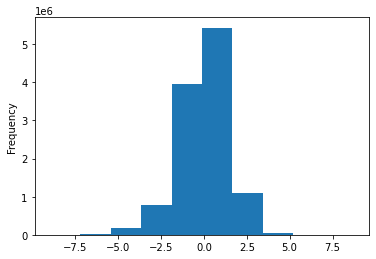

In [49]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [50]:
# we have some very extreme outliers in this data which we will remove.
user_ratings_this_set.describe()

,Rating
count,1.152677e+07
mean,5.101639e-18
std,1.421410e+00
min,-8.987106e+00
25%,-7.439024e-01
50%,9.433962e-02
75%,8.805690e-01
max,8.759036e+00


In [51]:
# getting our lower and upper
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

(-3.1806096574315266, 3.3172762583208364)

In [52]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(user_ratings_this_set[ (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower) ].index , inplace=True)

In [53]:
user_ratings_this_set.describe()

,Rating
count,1.112167e+07
mean,9.742087e-02
std,1.204956e+00
min,-3.180603e+00
25%,-6.590308e-01
50%,1.240942e-01
75%,8.888889e-01
max,3.317241e+00


<AxesSubplot:ylabel='Frequency'>

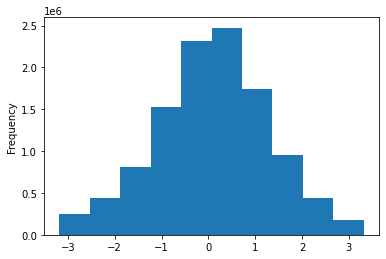

In [54]:
# improved data distribution

user_ratings_this_set['Rating'].plot(kind='hist')

In [57]:
# set up our Surprise data reader, which requires a scale. Our scale is the min and max of our data distribution.
bottom = user_ratings_this_set['Rating'].min()
top = user_ratings_this_set['Rating'].max()

data_reader = Reader(rating_scale=(bottom, top))

# create our surprise data using the scale
data = Dataset.load_from_df(user_ratings_this_set[['UserID', 'BGGId', 'Rating']], data_reader)

In [58]:
# clean up

del user_ratings_this_set
gc.collect()

79

### Test Different Algorithms

We're testing the following models on the data set:

- SVD: The accepted standard for recommender systems is Singular Value Decomposition, which is creating two long and wide vectors that best match the data
- Normal Predictor: predicts a random rating based on the distribution of the training set. Is expected to perform poorly.
- Baseline Only: Uses alternating least squares to estimate biases for the data set. Is expected to perform just ok.

In [47]:
benchmark = []

algorithms = [SVD(), 
              NormalPredictor(), 
              BaselineOnly(), 
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

New Algorithm <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002199FE9F388>
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0608  1.0623  1.0612  1.0614  0.0006  
Fit time          317.47  316.50  318.38  317.45  0.77    
Test time         40.11   38.37   39.83   39.43   0.76    
New Algorithm <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x0000021A18105848>
Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6981  1.6987  1.6988  1.6985  0.0003  
Fit time          8.50    10.69   10.31   9.84    0.96    
Test time         40.32   35.69   39.10   38.37   1.96    
New Algorithm <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x0000021A180F1348>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE o

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.061429,317.447572,39.433062
BaselineOnly,1.066642,19.186088,38.140208
NormalPredictor,1.698536,9.835172,38.374211


Baseline only is NEARLY as good as an untuned SVD with only a fraction of the computational time. Since computational time is a serious concern on data of our size, we move forward using BaselineOnly.

### Fit and Predict

In [59]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [60]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_predictions = algo.test(testset)

Estimating biases using als...


### Validation Set Scoring

#### Validate Data on One User

In [61]:
# Select a user and item to validate data
user = 'moosh21'
item = 31260
user_mean = user_mean_lookup['moosh21']['user_mean']

In [62]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_predictions)
user_df = predictions_df.loc[predictions_df['uid']==user]
user_df.head()

,uid,iid,r_ui,est,details
8847794,moosh21,31260,-0.49122,0.660141,{'was_impossible': False}
8847795,moosh21,33604,0.00878,-0.315382,{'was_impossible': False}
8847796,moosh21,15817,1.00878,-0.017334,{'was_impossible': False}
8847797,moosh21,714,-0.19122,-0.630658,{'was_impossible': False}
8847798,moosh21,150376,0.50878,0.275105,{'was_impossible': False}


In [63]:
# get the prediction for this real rated item
user_df.loc[user_df['iid']==item]['est']+user_mean

8847794    6.65136
Name: est, dtype: float64

In [64]:
# predict on the validation dataset
prediction = algo.predict(uid='moosh21', iid=item, verbose=True)
prediction[3]+user_mean_lookup['moosh21']['user_mean']

user: moosh21    item: 31260      r_ui = None   est = 0.66   {'was_impossible': False}


6.651360269719135

#### Score All Users

In [65]:
# identify our user set
user_set = val_users

# set up our model predictions dictionary
model_predictions_real = {}

# predict ratings for all games for users in the user set
for uid in user_set:
    model_predictions_real[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_real[uid][str(iid)] = prediction[3]+user_mean_lookup[uid]['user_mean']

In [66]:
# set up scoring lists to store scores
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

# for each user in the user set, get the mae, rmse, recall, actual rated items, and recommended items
for user in user_set:
    user_mean = user_mean_lookup[user]['user_mean']
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], model_predictions_real[user], user_mean)
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    # here we keep an ongoing set of the recommended items as they are sent back
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [67]:
# get the global scores for our set of users
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items)/len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

(0.923159537597879, 1.1939381896959638, 62.78196980764548, 0.8729629455689664)

While recall and coverage are ok, our user error is MUCH worse with the model. The model also has a much higher computational cost, and requires a user have been present at training to include. These factors lead us to favor the Memory-based approach.

### Clean Up

In [69]:
del trainset
del testset
del algo
del data
del base_data_predictions
del predictions_df
del user_df
del model_predictions_real

gc.collect()

71

# Tests with Synthetic Data

We now run the exact same series of Memory-based and Model-based tests, only with our Synthetic data set.

In [31]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

## Memory Based

### Visualizations

Create a visualization showing the number of users vs number of games rated, with a line at the median. We can see how our median has changed now that we have synthetic data.

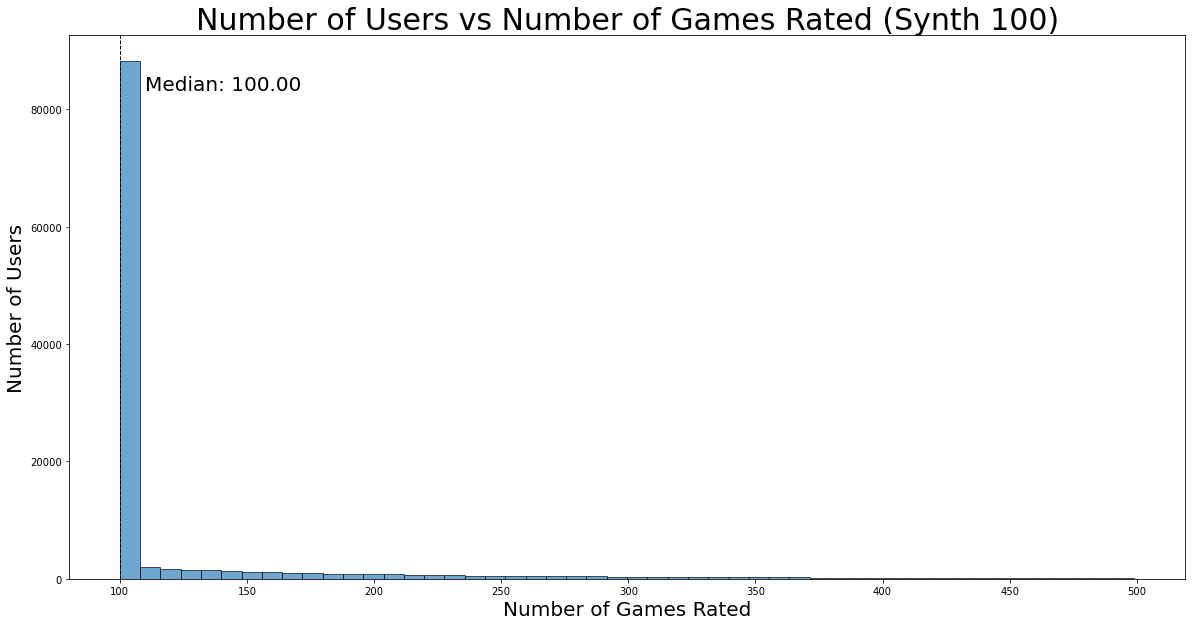

''

In [186]:
num_ratings = {}

for user in synth_user_ratings_dictionary_scaled100:
    num_ratings[user] = len(synth_user_ratings_dictionary_scaled100[user])
    
num_ratings_df = pd.DataFrame(num_ratings.values(), index=(num_ratings.keys())).reset_index()

fix, ax = plt.subplots(figsize=(20,10))

x = num_ratings_df.loc[num_ratings_df[0]<500][0]
med = num_ratings_df[0].median()

result = plt.hist(x, bins=50, edgecolor='k', alpha=0.65)
plt.axvline(med, color='k', linestyle='dashed', linewidth=1)

plt.title("Number of Users vs Number of Games Rated (Synth 100)", fontsize=30)
plt.xlabel("Number of Games Rated", fontsize=20)
plt.ylabel("Number of Users", fontsize=20)

min_ylim, max_ylim = plt.ylim()
plt.text(med*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(med), fontsize=20)

#plt.savefig('images/synth_usersvsrated.png')
plt.show()

;

In [187]:
num_under_100 = num_ratings_df.loc[num_ratings_df[0]==100][0].count()
num_under_100_perc = round(num_under_100/num_ratings_df.shape[0]*100, 2)
print(str(num_under_100)+" users with 100 or fewer ratings (median), comprising "+str(num_under_100_perc)+"% of users.")

86239 users with 100 or fewer ratings (median), comprising 73.54% of users.


We now have 73.54% of users with only 100 ratings.

### Finding Optimal v, k and n

In [62]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [63]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [67]:
vs_and_ks100 = []
mae_tracker100 = []
rmse_tracker100 = []
recall_tracker100 = []
catalog_coverage100 = []

In [68]:
user_set = val_users[:100]

for v in [20, 15, 10, 5]:
    for k in [250]: # K only to make sure we have enough neighbors at the v
        for n in [15, 10, 5]:
            parameters = [v, k, n]
            start = time.time()
            string = 'v'+str(v)+'_k'+str(k)+'_n'+str(n)
            print("Calculating for "+string)
            global_mae, global_rmse, global_recall, user_predictions_synth_basismemory, catalog_temp = get_user_predictions(dictionary_set, user_set, parameters, synth=True)
            vs_and_ks100.append(string)
            mae_tracker100.append(global_mae)
            rmse_tracker100.append(global_rmse)
            recall_tracker100.append(global_recall)
            end = time.time() - start
            coverage = round(((len(catalog_temp)/len(game_id_lookup))*100), 2)
            catalog_coverage100.append(coverage)

Calculating for v20_k250_n15
20 250 15
Calculating Shade92008
Found 50322 potential neighbors in common at v: 20 k: 250 n:15
Predicted 129 ratings
Calculating moosh21
Found 28308 potential neighbors in common at v: 20 k: 250 n:15
Predicted 0 ratings
There were NO COMPS for this user
Calculating Threnody
Found 47044 potential neighbors in common at v: 20 k: 250 n:15
Predicted 306 ratings
Calculating fremen1430
Found 422 potential neighbors in common at v: 20 k: 250 n:15
Predicted 171 ratings
Calculating dwjmeijer
Found 28113 potential neighbors in common at v: 20 k: 250 n:15
Predicted 0 ratings
There were NO COMPS for this user
Calculating fornacigiorgi
Found 1444 potential neighbors in common at v: 20 k: 250 n:15
Predicted 889 ratings
Calculating Kitte87
Found 7324 potential neighbors in common at v: 20 k: 250 n:15
Predicted 666 ratings
Calculating UberK
Found 25848 potential neighbors in common at v: 20 k: 250 n:15
Predicted 152 ratings
Calculating impliedmonkey
Found 24730 potential 

Predicted 326 ratings
Calculating verspielter
Found 551 potential neighbors in common at v: 20 k: 250 n:15
Predicted 233 ratings
Calculating jonchalk
Found 27082 potential neighbors in common at v: 20 k: 250 n:15
Predicted 5 ratings
Calculating Ravensmith
Found 270 potential neighbors in common at v: 20 k: 250 n:15
Predicted 164 ratings
Calculating mycroftianhorror
Found 1647 potential neighbors in common at v: 20 k: 250 n:15
Predicted 95 ratings
Calculating Festus00
Found 1882 potential neighbors in common at v: 20 k: 250 n:15
Predicted 225 ratings
Calculating Raf Richman
Found 11560 potential neighbors in common at v: 20 k: 250 n:15
Predicted 442 ratings
Calculating Ragecage
Found 22191 potential neighbors in common at v: 20 k: 250 n:15
Predicted 66 ratings
Calculating DaveTu
Found 666 potential neighbors in common at v: 20 k: 250 n:15
Predicted 13 ratings
No ratings for actual predicted items. Cannot calculate MAE for this user.
Calculating MeanderingCode
Found 427 potential neighbo

Found 23666 potential neighbors in common at v: 20 k: 250 n:10
Predicted 105 ratings
Calculating Wood_Golem
Found 9238 potential neighbors in common at v: 20 k: 250 n:10
Predicted 281 ratings
Calculating Nmvapril
Found 3414 potential neighbors in common at v: 20 k: 250 n:10
Predicted 517 ratings
Calculating MSRyanInNYC
Found 9419 potential neighbors in common at v: 20 k: 250 n:10
Predicted 0 ratings
There were NO COMPS for this user
Calculating Lorenzo26
Found 1760 potential neighbors in common at v: 20 k: 250 n:10
Predicted 1134 ratings
Calculating Durins_Folk
Found 1252 potential neighbors in common at v: 20 k: 250 n:10
Predicted 147 ratings
Calculating Hertzog
Found 57750 potential neighbors in common at v: 20 k: 250 n:10
Predicted 48 ratings
Calculating davidmontgomery
Found 28193 potential neighbors in common at v: 20 k: 250 n:10
Predicted 963 ratings
Calculating Zhury
Found 284 potential neighbors in common at v: 20 k: 250 n:10
Predicted 0 ratings
There were NO COMPS for this use

Found 28723 potential neighbors in common at v: 20 k: 250 n:5
Predicted 131 ratings
Calculating Domin8
Found 20091 potential neighbors in common at v: 20 k: 250 n:5
Predicted 525 ratings
Calculating Wsch
Found 23618 potential neighbors in common at v: 20 k: 250 n:5
Predicted 264 ratings
Calculating Stockwell
Found 834 potential neighbors in common at v: 20 k: 250 n:5
Predicted 413 ratings
Calculating Fabs
Found 12464 potential neighbors in common at v: 20 k: 250 n:5
Predicted 840 ratings
Calculating sarahel1zab3th
Found 14542 potential neighbors in common at v: 20 k: 250 n:5
Predicted 791 ratings
Calculating ForgivenX10
Found 8336 potential neighbors in common at v: 20 k: 250 n:5
Predicted 2061 ratings
Calculating dwgteach
Found 44221 potential neighbors in common at v: 20 k: 250 n:5
Predicted 258 ratings
Calculating tidynail
Found 2691 potential neighbors in common at v: 20 k: 250 n:5
Predicted 463 ratings
Calculating Games by Gord!
Found 8356 potential neighbors in common at v: 20 k:

Predicted 507 ratings
Calculating ginus
Found 30686 potential neighbors in common at v: 20 k: 250 n:5
Predicted 20905 ratings
Calculating jimu
Found 315 potential neighbors in common at v: 20 k: 250 n:5
Predicted 0 ratings
There were NO COMPS for this user
Calculating davidinlow
Found 59473 potential neighbors in common at v: 20 k: 250 n:5
Predicted 737 ratings
Calculating eatingtree
Found 4584 potential neighbors in common at v: 20 k: 250 n:5
Predicted 0 ratings
There were NO COMPS for this user
MAE for set of users: 0.5804216839694561
RMSE for set of users: 0.7410666861790248
Recall for set of users: 58.627
Time elapsed: 408.1393826007843
Calculating for v15_k250_n15
15 250 15
Calculating Shade92008
Found 50322 potential neighbors in common at v: 15 k: 250 n:15
Predicted 129 ratings
Calculating moosh21
Found 28308 potential neighbors in common at v: 15 k: 250 n:15
Predicted 0 ratings
There were NO COMPS for this user
Calculating Threnody
Found 47044 potential neighbors in common at v

Found 57702 potential neighbors in common at v: 15 k: 250 n:15
Predicted 15 ratings
Calculating jamesgrahamuk
Found 27212 potential neighbors in common at v: 15 k: 250 n:15
Predicted 354 ratings
Calculating JR91
Found 4053 potential neighbors in common at v: 15 k: 250 n:15
Predicted 156 ratings
Calculating Maiic
Found 977 potential neighbors in common at v: 15 k: 250 n:15
Predicted 136 ratings
Calculating Bloodycaesar132
Found 2004 potential neighbors in common at v: 15 k: 250 n:15
Predicted 190 ratings
Calculating burgales
Found 10026 potential neighbors in common at v: 15 k: 250 n:15
Predicted 326 ratings
Calculating verspielter
Found 551 potential neighbors in common at v: 15 k: 250 n:15
Predicted 233 ratings
Calculating jonchalk
Found 27082 potential neighbors in common at v: 15 k: 250 n:15
Predicted 5 ratings
Calculating Ravensmith
Found 270 potential neighbors in common at v: 15 k: 250 n:15
Predicted 164 ratings
Calculating mycroftianhorror
Found 1647 potential neighbors in commo

Found 305 potential neighbors in common at v: 15 k: 250 n:10
Predicted 69 ratings
Calculating kainsteele
Found 28809 potential neighbors in common at v: 15 k: 250 n:10
Predicted 710 ratings
Calculating TLHobbes
Found 26090 potential neighbors in common at v: 15 k: 250 n:10
Predicted 1222 ratings
Calculating ozinou
Found 5468 potential neighbors in common at v: 15 k: 250 n:10
Predicted 1536 ratings
Calculating boken78
Found 379 potential neighbors in common at v: 15 k: 250 n:10
Predicted 133 ratings
Calculating AfterburnNL
Found 23666 potential neighbors in common at v: 15 k: 250 n:10
Predicted 105 ratings
Calculating Wood_Golem
Found 9238 potential neighbors in common at v: 15 k: 250 n:10
Predicted 281 ratings
Calculating Nmvapril
Found 3414 potential neighbors in common at v: 15 k: 250 n:10
Predicted 517 ratings
Calculating MSRyanInNYC
Found 9419 potential neighbors in common at v: 15 k: 250 n:10
Predicted 0 ratings
There were NO COMPS for this user
Calculating Lorenzo26
Found 1760 po

Found 20202 potential neighbors in common at v: 15 k: 250 n:5
Predicted 2247 ratings
Calculating Pheylan
Found 1844 potential neighbors in common at v: 15 k: 250 n:5
Predicted 1268 ratings
Calculating BichonBuzz
Found 1679 potential neighbors in common at v: 15 k: 250 n:5
Predicted 185 ratings
Calculating Robinoost
Found 5847 potential neighbors in common at v: 15 k: 250 n:5
Predicted 2188 ratings
Calculating zouflain
Found 24410 potential neighbors in common at v: 15 k: 250 n:5
Predicted 677 ratings
Calculating Nizzamko
Found 28723 potential neighbors in common at v: 15 k: 250 n:5
Predicted 131 ratings
Calculating Domin8
Found 20091 potential neighbors in common at v: 15 k: 250 n:5
Predicted 525 ratings
Calculating Wsch
Found 23618 potential neighbors in common at v: 15 k: 250 n:5
Predicted 264 ratings
Calculating Stockwell
Found 834 potential neighbors in common at v: 15 k: 250 n:5
Predicted 413 ratings
Calculating Fabs
Found 12464 potential neighbors in common at v: 15 k: 250 n:5
Pr

Predicted 1719 ratings
Calculating NJKB
Found 10120 potential neighbors in common at v: 15 k: 250 n:5
Predicted 69 ratings
Calculating sideburnz
Found 3578 potential neighbors in common at v: 15 k: 250 n:5
Predicted 0 ratings
There were NO COMPS for this user
Calculating Shep
Found 35708 potential neighbors in common at v: 15 k: 250 n:5
Predicted 35 ratings
Calculating Turic
Found 36906 potential neighbors in common at v: 15 k: 250 n:5
Predicted 69 ratings
Calculating Delthos
Found 67748 potential neighbors in common at v: 15 k: 250 n:5
Predicted 507 ratings
Calculating ginus
Found 30686 potential neighbors in common at v: 15 k: 250 n:5
Predicted 20905 ratings
Calculating jimu
Found 507 potential neighbors in common at v: 15 k: 250 n:5
Predicted 8 ratings
Calculating davidinlow
Found 72919 potential neighbors in common at v: 15 k: 250 n:5
Predicted 1623 ratings
Calculating eatingtree
Found 8442 potential neighbors in common at v: 15 k: 250 n:5
Predicted 59 ratings
MAE for set of users:

Predicted 163 ratings
Calculating mighor
Found 11927 potential neighbors in common at v: 10 k: 250 n:15
Predicted 1528 ratings
Calculating inknpaper
Found 1006 potential neighbors in common at v: 10 k: 250 n:15
Predicted 335 ratings
Calculating Skarpskytten
Found 5663 potential neighbors in common at v: 10 k: 250 n:15
Predicted 45 ratings
Calculating juscent
Found 74153 potential neighbors in common at v: 10 k: 250 n:15
Predicted 100 ratings
Calculating jamesgrahamuk
Found 45442 potential neighbors in common at v: 10 k: 250 n:15
Predicted 1395 ratings
Calculating JR91
Found 13172 potential neighbors in common at v: 10 k: 250 n:15
Predicted 758 ratings
Calculating Maiic
Found 4923 potential neighbors in common at v: 10 k: 250 n:15
Predicted 2021 ratings
Calculating Bloodycaesar132
Found 8929 potential neighbors in common at v: 10 k: 250 n:15
Predicted 949 ratings
Calculating burgales
Found 23357 potential neighbors in common at v: 10 k: 250 n:15
Predicted 1202 ratings
Calculating verspi

Predicted 694 ratings
Calculating Lsupawn
Found 971 potential neighbors in common at v: 10 k: 250 n:10
Predicted 213 ratings
Calculating kainsteele
Found 52295 potential neighbors in common at v: 10 k: 250 n:10
Predicted 2297 ratings
Calculating TLHobbes
Found 38820 potential neighbors in common at v: 10 k: 250 n:10
Predicted 2247 ratings
Calculating ozinou
Found 19763 potential neighbors in common at v: 10 k: 250 n:10
Predicted 2554 ratings
Calculating boken78
Found 2044 potential neighbors in common at v: 10 k: 250 n:10
Predicted 1556 ratings
Calculating AfterburnNL
Found 37675 potential neighbors in common at v: 10 k: 250 n:10
Predicted 590 ratings
Calculating Wood_Golem
Found 20117 potential neighbors in common at v: 10 k: 250 n:10
Predicted 791 ratings
Calculating Nmvapril
Found 10783 potential neighbors in common at v: 10 k: 250 n:10
Predicted 1561 ratings
Calculating MSRyanInNYC
Found 19265 potential neighbors in common at v: 10 k: 250 n:10
Predicted 301 ratings
Calculating Lore

Predicted 3715 ratings
Calculating BichonBuzz
Found 9606 potential neighbors in common at v: 10 k: 250 n:5
Predicted 2071 ratings
Calculating Robinoost
Found 15586 potential neighbors in common at v: 10 k: 250 n:5
Predicted 5382 ratings
Calculating zouflain
Found 49840 potential neighbors in common at v: 10 k: 250 n:5
Predicted 3109 ratings
Calculating Nizzamko
Found 49067 potential neighbors in common at v: 10 k: 250 n:5
Predicted 1050 ratings
Calculating Domin8
Found 40486 potential neighbors in common at v: 10 k: 250 n:5
Predicted 2211 ratings
Calculating Wsch
Found 38335 potential neighbors in common at v: 10 k: 250 n:5
Predicted 1260 ratings
Calculating Stockwell
Found 5405 potential neighbors in common at v: 10 k: 250 n:5
Predicted 2847 ratings
Calculating Fabs
Found 32219 potential neighbors in common at v: 10 k: 250 n:5
Predicted 3815 ratings
Calculating sarahel1zab3th
Found 27987 potential neighbors in common at v: 10 k: 250 n:5
Predicted 3299 ratings
Calculating ForgivenX10
F

Predicted 1075 ratings
Calculating Shep
Found 52710 potential neighbors in common at v: 10 k: 250 n:5
Predicted 397 ratings
Calculating Turic
Found 54927 potential neighbors in common at v: 10 k: 250 n:5
Predicted 615 ratings
Calculating Delthos
Found 85942 potential neighbors in common at v: 10 k: 250 n:5
Predicted 1623 ratings
Calculating ginus
Found 46297 potential neighbors in common at v: 10 k: 250 n:5
Predicted 21154 ratings
Calculating jimu
Found 2371 potential neighbors in common at v: 10 k: 250 n:5
Predicted 1536 ratings
Calculating davidinlow
Found 88176 potential neighbors in common at v: 10 k: 250 n:5
Predicted 3296 ratings
Calculating eatingtree
Found 16975 potential neighbors in common at v: 10 k: 250 n:5
Predicted 1385 ratings
MAE for set of users: 0.5709368514872131
RMSE for set of users: 0.7412272975631812
Recall for set of users: 61.102
Time elapsed: 582.7991008758545
Calculating for v5_k250_n15
5 250 15
Calculating Shade92008
Found 93439 potential neighbors in common

Predicted 1592 ratings
Calculating Skarpskytten
Found 29910 potential neighbors in common at v: 5 k: 250 n:15
Predicted 2522 ratings
Calculating juscent
Found 94009 potential neighbors in common at v: 5 k: 250 n:15
Predicted 736 ratings
Calculating jamesgrahamuk
Found 73507 potential neighbors in common at v: 5 k: 250 n:15
Predicted 4809 ratings
Calculating JR91
Found 40453 potential neighbors in common at v: 5 k: 250 n:15
Predicted 3543 ratings
Calculating Maiic
Found 22307 potential neighbors in common at v: 5 k: 250 n:15
Predicted 7391 ratings
Calculating Bloodycaesar132
Found 37656 potential neighbors in common at v: 5 k: 250 n:15
Predicted 4579 ratings
Calculating burgales
Found 55759 potential neighbors in common at v: 5 k: 250 n:15
Predicted 5395 ratings
Calculating verspielter
Found 4158 potential neighbors in common at v: 5 k: 250 n:15
Predicted 2387 ratings
Calculating jonchalk
Found 70084 potential neighbors in common at v: 5 k: 250 n:15
Predicted 1260 ratings
Calculating Ra

Predicted 7054 ratings
Calculating TLHobbes
Found 62692 potential neighbors in common at v: 5 k: 250 n:10
Predicted 5313 ratings
Calculating ozinou
Found 55337 potential neighbors in common at v: 5 k: 250 n:10
Predicted 7854 ratings
Calculating boken78
Found 8692 potential neighbors in common at v: 5 k: 250 n:10
Predicted 4369 ratings
Calculating AfterburnNL
Found 64617 potential neighbors in common at v: 5 k: 250 n:10
Predicted 2823 ratings
Calculating Wood_Golem
Found 45218 potential neighbors in common at v: 5 k: 250 n:10
Predicted 2872 ratings
Calculating Nmvapril
Found 36492 potential neighbors in common at v: 5 k: 250 n:10
Predicted 8141 ratings
Calculating MSRyanInNYC
Found 46162 potential neighbors in common at v: 5 k: 250 n:10
Predicted 2542 ratings
Calculating Lorenzo26
Found 4007 potential neighbors in common at v: 5 k: 250 n:10
Predicted 3379 ratings
Calculating Durins_Folk
Found 25620 potential neighbors in common at v: 5 k: 250 n:10
Predicted 6823 ratings
Calculating Hert

Predicted 11262 ratings
Calculating zouflain
Found 81168 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9572 ratings
Calculating Nizzamko
Found 76026 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6037 ratings
Calculating Domin8
Found 71978 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7470 ratings
Calculating Wsch
Found 67199 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5814 ratings
Calculating Stockwell
Found 30760 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13292 ratings
Calculating Fabs
Found 66578 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11332 ratings
Calculating sarahel1zab3th
Found 54833 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9885 ratings
Calculating ForgivenX10
Found 58384 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12063 ratings
Calculating dwgteach
Found 87290 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6346 ratings
Calculating tidynail
Found 4

Found 103855 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5464 ratings
Calculating ginus
Found 72583 potential neighbors in common at v: 5 k: 250 n:5
Predicted 21275 ratings
Calculating jimu
Found 12810 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8906 ratings
Calculating davidinlow
Found 103600 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7207 ratings
Calculating eatingtree
Found 37706 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5405 ratings
MAE for set of users: 0.540543579719989
RMSE for set of users: 0.7137660922537377
Recall for set of users: 56.7616
Time elapsed: 1354.8105413913727


In [69]:
zipped = list(zip(mae_tracker100, rmse_tracker100, recall_tracker100, catalog_coverage100))
scores = pd.DataFrame(zipped, index=vs_and_ks100, columns=['MAE', 'RMSE', 'Recall', 'Coverage']).sort_values('RMSE')
scores.to_pickle('synth100_scores_round1.pkl')

In [91]:
synth100scores = pd.read_pickle('synth100_scores_round1.pkl')

error_weight = .3
recall_weight = 1
coverage_weight = .5

synth100scores['Score'] = ((1-synth100scores['RMSE'])*100)*error_weight + synth100scores['Recall']*recall_weight + (synth100scores['Coverage'])*coverage_weight
synth100scores.sort_values('Score', ascending=False).head(30)


,MAE,RMSE,Recall,Coverage,Score
v5_k250_n5,0.540544,0.713766,56.761600,69.01,99.853617
v5_k250_n10,0.533554,0.700246,59.228900,47.85,92.146534
v10_k250_n5,0.570937,0.741227,61.102000,44.22,90.975181
v5_k250_n15,0.530265,0.693274,60.249100,37.51,88.205868
v10_k250_n10,0.555922,0.715960,62.955500,26.63,84.791692
v10_k250_n15,0.556113,0.708614,65.304800,19.66,83.876371
v15_k250_n5,0.595466,0.762306,59.856900,27.58,80.777707
v20_k250_n5,0.580422,0.741067,58.627000,27.45,80.119999
v20_k250_n10,0.510774,0.642509,58.891500,15.29,77.261217
v15_k250_n10,0.510497,0.642299,58.875900,15.30,77.256936


### Get Validation Scores

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [92]:
parameters = [5, 250, 5]

In [93]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [94]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [95]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [96]:
# get distance between users and store in dict

global_mae, global_rmse, global_recall, user_predictions_synth100_basismemory, item_set_synth100 = get_user_predictions(dictionary_set, val_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100)/len(game_id_lookup))*100), 2)
synth100_coverage.append(coverage)

5 250 5
Calculating Shade92008
Found 93439 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5988 ratings
Calculating moosh21
Found 71737 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2752 ratings
Calculating Threnody
Found 87634 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7027 ratings
Calculating fremen1430
Found 9436 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7340 ratings
Calculating dwjmeijer
Found 72741 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3745 ratings
Calculating fornacigiorgi
Found 15157 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13564 ratings
Calculating Kitte87
Found 57027 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11566 ratings
Calculating UberK
Found 68583 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6924 ratings
Calculating impliedmonkey
Found 64678 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4149 ratings
Calculating NorthWestNerd
Found 1474

Found 2263 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11168 ratings
Calculating mycroftianhorror
Found 24847 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8831 ratings
Calculating Festus00
Found 4351 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3102 ratings
Calculating Raf Richman
Found 48334 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8817 ratings
Calculating Ragecage
Found 65706 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5915 ratings
Calculating DaveTu
Found 4062 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1626 ratings
Calculating MeanderingCode
Found 7768 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8796 ratings
Calculating List74
Found 13174 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5629 ratings
Calculating leonard0908
Found 51093 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10601 ratings
Calculating simem
Found 71474 potential neighbors in common at

Predicted 6125 ratings
Calculating waltermac
Found 63516 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9887 ratings
Calculating wamadeus
Found 87440 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2545 ratings
Calculating posiegirl
Found 34835 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7479 ratings
Calculating thrillagorilla
Found 52822 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11326 ratings
Calculating bgbert
Found 67616 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15301 ratings
Calculating debbie
Found 6142 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4729 ratings
Calculating Valerio79
Found 79129 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7924 ratings
Calculating Murkxsi
Found 46268 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11059 ratings
Calculating thomast8991
Found 64917 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5727 ratings
Calculating Dakersd
Fou

Predicted 4439 ratings
Calculating carcassian
Found 57229 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7621 ratings
Calculating wi11king777
Found 47309 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8556 ratings
Calculating flashsolaar
Found 47988 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6508 ratings
Calculating eviltofu
Found 65711 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2136 ratings
Calculating Panosxat
Found 70242 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11606 ratings
Calculating jvilkka
Found 83978 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4986 ratings
Calculating Koenigskind
Found 48249 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14603 ratings
Calculating Skop662
Found 76171 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12481 ratings
Calculating Wonko the Sane
Found 70039 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9583 ratings
Calculating Ei

Found 55716 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3457 ratings
Calculating broknsword
Found 38027 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10403 ratings
Calculating gos82
Found 78836 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11924 ratings
Calculating Hector131
Found 62804 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6621 ratings
Calculating ecommand
Found 35057 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6945 ratings
Calculating Wunderjarl
Found 57566 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7187 ratings
Calculating DavidEarls05
Found 36218 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7245 ratings
Calculating gecoltra
Found 42943 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11561 ratings
Calculating virgil11
Found 69270 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7809 ratings
Calculating homeblessings
Found 35414 potential neighbors in common

Predicted 14582 ratings
Calculating Bagpuss42
Found 13866 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7319 ratings
Calculating Dreamtension
Found 63468 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10978 ratings
Calculating oingo
Found 7804 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2879 ratings
Calculating CongoKees
Found 75407 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4799 ratings
Calculating crlsls91
Found 33060 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13795 ratings
Calculating smoak511
Found 99786 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8366 ratings
Calculating ABlanca
Found 17084 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11951 ratings
Calculating Ptaco
Found 59651 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8522 ratings
Calculating volante
Found 100520 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9032 ratings
Calculating Martinius Trasheru

Predicted 8243 ratings
Calculating chaosabounds
Found 24746 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9329 ratings
Calculating quartex
Found 93648 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6304 ratings
Calculating capn_tucker
Found 3965 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3757 ratings
Calculating Cliqued
Found 71085 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11388 ratings
Calculating Contercontra
Found 59930 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9149 ratings
Calculating Onceagain
Found 49505 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5982 ratings
Calculating witwit
Found 77917 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6117 ratings
Calculating Bigio977
Found 69510 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7573 ratings
Calculating pellitieri
Found 47261 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3796 ratings
Calculating soundpreac

Found 79025 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4902 ratings
Calculating michal_kempka
Found 81973 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2748 ratings
Calculating TheProfessorODK
Found 67119 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10234 ratings
Calculating megreebo
Found 86797 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5715 ratings
Calculating Biff_the_Toady
Found 32371 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7766 ratings
Calculating Foxbat2020
Found 4384 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1770 ratings
Calculating vonklaude
Found 52571 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9893 ratings
Calculating efst01
Found 12259 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6201 ratings
Calculating Dalamar437
Found 63212 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10786 ratings
Calculating escural
Found 79067 potential neighbors in

Found 38275 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5796 ratings
Calculating rainyl
Found 94509 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5774 ratings
Calculating Hellobroxxx
Found 16637 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13664 ratings
Calculating Mausenheimmer
Found 50845 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15909 ratings
Calculating MrSnappycat
Found 3374 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1870 ratings
Calculating searscho
Found 98832 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3659 ratings
Calculating HunterDK
Found 64235 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3914 ratings
Calculating Blondie1922
Found 57817 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8000 ratings
Calculating Masakari88
Found 36666 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9416 ratings
Calculating Remigijus
Found 62183 potential neighbors in comm

Predicted 3489 ratings
Calculating BitBGames
Found 10857 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9377 ratings
Calculating Termite
Found 14837 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7961 ratings
Calculating lord amami
Found 67232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9853 ratings
Calculating Gentrifuge
Found 69487 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16548 ratings
Calculating Martstell
Found 33590 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6552 ratings
Calculating Nedre
Found 63657 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11781 ratings
Calculating Nojvok
Found 20375 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9809 ratings
Calculating juhirvon
Found 43149 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13223 ratings
Calculating MrBaggy
Found 88985 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3004 ratings
Calculating ju012835
Found 924

Predicted 4207 ratings
Calculating Mattchew222
Found 10237 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11610 ratings
Calculating danngall
Found 66951 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9383 ratings
Calculating Levisiebens
Found 103820 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4203 ratings
Calculating alisonarantes
Found 103138 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4407 ratings
Calculating andersonjr
Found 35816 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8323 ratings
Calculating microwavesafe
Found 59788 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15629 ratings
Calculating DionisWorks
Found 42046 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10448 ratings
Calculating Crankshaft
Found 8148 potential neighbors in common at v: 5 k: 250 n:5
Predicted 18906 ratings
Calculating BlackHammer66
Found 50487 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11803 rating

Predicted 5554 ratings
Calculating Dave_P
Found 71830 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2535 ratings
Calculating mboling
Found 1805 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2403 ratings
Calculating eman68
Found 72383 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4774 ratings
Calculating DesignerTomPNW
Found 25839 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6771 ratings
Calculating Ballamannin
Found 76063 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10685 ratings
Calculating Gooodday
Found 61818 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7368 ratings
Calculating MFazio23
Found 41601 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12818 ratings
Calculating FrozenGamer
Found 81621 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4951 ratings
Calculating Uberaris
Found 57619 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9573 ratings
Calculating coronaone
Fo

Found 70576 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9404 ratings
Calculating asciutto
Found 22658 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13415 ratings
Calculating Parmathule
Found 50665 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7648 ratings
Calculating caseywills
Found 61766 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14466 ratings
Calculating BaldyBeards
Found 78438 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12641 ratings
Calculating ob1quixote
Found 27837 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7946 ratings
Calculating AcroRay
Found 2315 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2328 ratings
Calculating OneCrazyCanuck
Found 52734 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5963 ratings
Calculating Fenix85
Found 75072 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2621 ratings
Calculating bananaphant
Found 67027 potential neighbors in co

Found 54560 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14146 ratings
Calculating Chiken Bird
Found 34251 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12574 ratings
Calculating T3tsuo
Found 52746 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12400 ratings
Calculating RichGarner71
Found 14238 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9770 ratings
Calculating davbart
Found 39518 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8715 ratings
Calculating breraknight
Found 56444 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12367 ratings
Calculating amyarvita
Found 50796 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8137 ratings
Calculating McLora
Found 12253 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10445 ratings
Calculating harpert1
Found 62687 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10924 ratings
Calculating Bliciant
Found 62510 potential neighbors in common a

Predicted 3294 ratings
Calculating butts777
Found 50334 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8450 ratings
Calculating azereal
Found 10180 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5422 ratings
Calculating Netslummer
Found 47403 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12522 ratings
Calculating snerreifke
Found 101685 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7977 ratings
Calculating zaphod b
Found 96584 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3614 ratings
Calculating Comicoman
Found 41219 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11905 ratings
Calculating dandieandie
Found 5401 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6335 ratings
Calculating nailuj
Found 5784 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10910 ratings
Calculating Vonron
Found 76325 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4327 ratings
Calculating leegb1
Found 14

Predicted 6926 ratings
Calculating jupiter0126
Found 3985 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4278 ratings
Calculating desmi
Found 23297 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11181 ratings
Calculating doxazo
Found 70779 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10463 ratings
Calculating firemagexd
Found 57572 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7601 ratings
Calculating shaker
Found 48396 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13782 ratings
Calculating joao2804
Found 8918 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10002 ratings
Calculating Amonit14
Found 25325 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11356 ratings
Calculating Zedronar
Found 66503 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10396 ratings
Calculating elflum
Found 13891 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9079 ratings
Calculating boredboard
Found 520

Found 105128 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3214 ratings
Calculating rgscherf
Found 51925 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4116 ratings
Calculating Miliganos
Found 4255 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5327 ratings
Calculating Mint eh
Found 77348 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9490 ratings
Calculating Willeja
Found 54638 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15356 ratings
Calculating JoeKobeBuckets
Found 23123 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9372 ratings
Calculating papecasey
Found 89710 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4496 ratings
Calculating udisun
Found 34674 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9824 ratings
Calculating cindyqn4118
Found 9444 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10220 ratings
Calculating mrfink
Found 4610 potential neighbors in common at v: 5 

Predicted 3430 ratings
Calculating Bessarion
Found 45439 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12135 ratings
Calculating Jjky62
Found 53529 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2467 ratings
Calculating Rasmon
Found 79960 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3792 ratings
Calculating IomasSyti
Found 3216 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4875 ratings
Calculating copydawg
Found 20332 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9076 ratings
Calculating Tjorriemorrie
Found 73529 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14245 ratings
Calculating ickle_jelly_baby
Found 13294 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10792 ratings
Calculating oswinip1988
Found 2212 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3912 ratings
Calculating Monteblanco
Found 4984 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3464 ratings
Calculating fir

Predicted 13597 ratings
Calculating adamhdickson
Found 35023 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11531 ratings
Calculating wallofjericho
Found 73882 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7680 ratings
Calculating Philipp2512
Found 57978 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5045 ratings
Calculating GuyGotGuns
Found 23664 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14786 ratings
Calculating keruken
Found 52283 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11663 ratings
Calculating Moradin
Found 38878 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12753 ratings
Calculating Fuscus
Found 62068 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8576 ratings
Calculating Wulffman
Found 56467 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13712 ratings
Calculating Trampojunk
Found 17836 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11020 ratings
Calculating t

Predicted 9036 ratings
Calculating camiee
Found 7366 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10886 ratings
Calculating Lord_Eradicus
Found 48901 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9277 ratings
Calculating Philip Thomas
Found 97445 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6489 ratings
Calculating kinkouin
Found 55707 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11253 ratings
Calculating oppenheimer
Found 71517 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5506 ratings
Calculating clarksm
Found 49029 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6571 ratings
Calculating jillch
Found 106202 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3654 ratings
Calculating pyaeen
Found 87211 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3631 ratings
Calculating lastemp3ror
Found 53465 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10504 ratings
Calculating EricMPaq

Predicted 16071 ratings
Calculating SunJas
Found 36264 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7309 ratings
Calculating Bogey777
Found 76425 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6074 ratings
Calculating Dalanhol
Found 60793 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8927 ratings
Calculating shfrost
Found 10623 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3866 ratings
Calculating robertswetbird
Found 48973 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11908 ratings
Calculating turtler7
Found 94627 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3119 ratings
Calculating Alfy
Found 35540 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15750 ratings
Calculating EJTheBae
Found 42742 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14333 ratings
Calculating Cupcakechaos
Found 59366 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4851 ratings
Calculating dsnow2323
Fou

Found 52464 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8108 ratings
Calculating odyssey
Found 55237 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4005 ratings
Calculating iorlas
Found 49255 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3050 ratings
Calculating MattyRendar
Found 14370 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11275 ratings
Calculating Thornedo
Found 98773 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5610 ratings
Calculating wiley1za
Found 96783 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4305 ratings
Calculating Belcampas
Found 72355 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10005 ratings
Calculating heathbarATL
Found 85263 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3636 ratings
Calculating kfrancis03
Found 49565 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3324 ratings
Calculating abrannan
Found 59293 potential neighbors in common at v:

Predicted 11675 ratings
Calculating Iriska
Found 52838 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9918 ratings
Calculating ftrimble
Found 56452 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4844 ratings
Calculating guitarpro77
Found 66536 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6309 ratings
Calculating carrickfergus
Found 77125 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5573 ratings
Calculating kazu
Found 97793 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2573 ratings
Calculating DMFeanor
Found 70782 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3058 ratings
Calculating Milowg
Found 12984 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11490 ratings
Calculating arnora21
Found 49206 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7634 ratings
Calculating Saraylp
Found 40016 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11849 ratings
Calculating MainMan
Found 5270

Found 45653 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6112 ratings
Calculating Valmorian
Found 68182 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7198 ratings
Calculating zaphiel
Found 82588 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2996 ratings
Calculating cho8989
Found 82662 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5606 ratings
Calculating Byeynyn
Found 76360 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10675 ratings
Calculating Spielevater
Found 44163 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1792 ratings
Calculating Noxus81
Found 43767 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8374 ratings
Calculating MissCho
Found 27328 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7133 ratings
Calculating jpetrai
Found 107983 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5507 ratings
Calculating teejdiscoversgames
Found 73219 potential neighbors in common at 

Predicted 8090 ratings
Calculating ChrisK229
Found 59935 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8359 ratings
Calculating Hindrick
Found 68093 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7259 ratings
Calculating Timmytoby
Found 69564 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7150 ratings
Calculating jat2980
Found 72920 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5800 ratings
Calculating Nakoliss
Found 84304 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8995 ratings
Calculating twistedcheffy
Found 69518 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9930 ratings
Calculating Yridos
Found 54881 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5857 ratings
Calculating meta3
Found 44633 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11295 ratings
Calculating Halco
Found 11098 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8734 ratings
Calculating dillei
Found 13336 po

Predicted 6799 ratings
Calculating quantaloup
Found 63770 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2775 ratings
Calculating Smorklick
Found 33065 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10029 ratings
Calculating victor1993
Found 103598 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4021 ratings
Calculating codybear37
Found 63618 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4499 ratings
Calculating eduardpop
Found 107241 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3725 ratings
Calculating Adalonus
Found 47702 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10807 ratings
Calculating MikeDiLisio
Found 94188 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6938 ratings
Calculating Neex
Found 10366 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8991 ratings
Calculating decimator85
Found 73280 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5383 ratings
Calculating bray62

Found 63107 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5194 ratings
Calculating waferjuice
Found 97539 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2974 ratings
Calculating Mad Murdoc
Found 72633 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4183 ratings
Calculating kaksoisv
Found 72094 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10049 ratings
Calculating Dsdjpofjs
Found 36287 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6611 ratings
Calculating panglossian
Found 77457 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11527 ratings
Calculating bozoslivehere
Found 69738 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12181 ratings
Calculating murlacher
Found 80587 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7556 ratings
Calculating rogerwilco86
Found 71998 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6018 ratings
Calculating Emperors Grace
Found 38359 potential neighb

Found 66296 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5684 ratings
Calculating Mytogen
Found 65035 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12195 ratings
Calculating HelvitisMaddi
Found 76575 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7834 ratings
Calculating myood
Found 53660 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9676 ratings
Calculating Ronin_Bonebreaker
Found 51245 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10541 ratings
Calculating CalSara
Found 55990 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3396 ratings
Calculating Odiousmaximus
Found 18741 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8476 ratings
Calculating dwag44
Found 56853 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3752 ratings
Calculating lagopodous
Found 14990 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9182 ratings
Calculating pkamppur
Found 58353 potential neighbors in comm

Predicted 14064 ratings
Calculating Redgar
Found 54699 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7456 ratings
Calculating jtammel
Found 48398 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4914 ratings
Calculating jaredisgod
Found 18641 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10791 ratings
Calculating Ewolf14
Found 66115 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5862 ratings
Calculating thederekoleary
Found 56041 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10639 ratings
Calculating wcolegrave
Found 90643 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3491 ratings
Calculating FNunes
Found 52681 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10028 ratings
Calculating R2DChew
Found 34348 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7775 ratings
Calculating Hoyboy
Found 68554 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1671 ratings
Calculating skslotten
Found

Predicted 8072 ratings
Calculating ReneSauz
Found 86298 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5113 ratings
Calculating mexo
Found 100111 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5607 ratings
Calculating The Players Player
Found 70556 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12115 ratings
Calculating Ange_Berlin
Found 91441 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4541 ratings
Calculating blittle
Found 55740 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6188 ratings
Calculating GeekyGoddess
Found 57075 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14725 ratings
Calculating Boots n Scoots
Found 90619 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7751 ratings
Calculating GabFH
Found 8980 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4271 ratings
Calculating Argue
Found 66208 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9600 ratings
Calculating Deadly

Found 74000 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7800 ratings
Calculating emilybess
Found 17448 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6424 ratings
Calculating Snazzaroo
Found 65039 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9484 ratings
Calculating Duikertje
Found 39306 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11886 ratings
Calculating bolandunited
Found 61357 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10643 ratings
Calculating teefertiberius
Found 2483 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4259 ratings
Calculating somewhatrare
Found 2297 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2653 ratings
Calculating PendragonAD
Found 67847 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11892 ratings
Calculating Professorjt
Found 43477 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13528 ratings
Calculating bugzonexxx
Found 29036 potential neighb

Predicted 6859 ratings
Calculating Singletrack13
Found 58927 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10393 ratings
Calculating jpbookworm
Found 42305 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3599 ratings
Calculating barry_luo
Found 78816 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6273 ratings
Calculating Tim Bushman
Found 49918 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15023 ratings
Calculating PoisonKiwi
Found 98525 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4645 ratings
Calculating golfprodunkey
Found 81909 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2494 ratings
Calculating Lasve16
Found 65263 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4204 ratings
Calculating gianterduck
Found 52503 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3307 ratings
Calculating phil_standen
Found 69632 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6791 ratings
Calcul

Predicted 2127 ratings
Calculating denali006
Found 79991 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6546 ratings
Calculating RedRudeBoy
Found 74531 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8807 ratings
Calculating Syyynd
Found 42971 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9309 ratings
Calculating pompey rich
Found 1695 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1633 ratings
Calculating dantasm734
Found 40444 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15363 ratings
Calculating klasgunnar
Found 64801 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9044 ratings
Calculating BDawG_SSBM
Found 39171 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9795 ratings
Calculating goldenman13
Found 6174 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4914 ratings
Calculating Nado
Found 16252 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15450 ratings
Calculating fanhsh
Foun

Found 99428 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2507 ratings
Calculating bob pryce
Found 11965 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2593 ratings
Calculating ickle_ellen
Found 53974 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6886 ratings
Calculating trelistonisi
Found 65886 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6018 ratings
Calculating Sgrollo
Found 68508 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11369 ratings
Calculating Do Not Curly Out
Found 47947 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8437 ratings
Calculating Njoltis
Found 83126 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2732 ratings
Calculating absalinas26
Found 53551 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3327 ratings
Calculating belverker
Found 32049 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5719 ratings
Calculating Chorume
Found 47642 potential neighbors in co

Predicted 5217 ratings
Calculating Roxxor McOwnage
Found 70603 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8453 ratings
Calculating MisterBond
Found 106016 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3093 ratings
Calculating tacox01
Found 92984 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6475 ratings
Calculating EcuadorMeeple
Found 38586 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9284 ratings
Calculating bellynice
Found 93941 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3008 ratings
Calculating trduity
Found 64231 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6658 ratings
Calculating Nadeanej
Found 6552 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4917 ratings
Calculating aeneas2467
Found 58267 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2459 ratings
Calculating alexmaklai
Found 75238 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10135 ratings
Calculating ju

Found 12884 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15896 ratings
Calculating h2201430
Found 92170 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4566 ratings
Calculating Nanosplic
Found 57013 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10808 ratings
Calculating zigfromsa
Found 31655 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9898 ratings
Calculating bkindt
Found 78417 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2634 ratings
Calculating eaaa
Found 31173 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9662 ratings
Calculating NthDoctor
Found 47737 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10002 ratings
Calculating diediediemydarling
Found 41678 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11996 ratings
Calculating jimdbrewer
Found 48223 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4174 ratings
Calculating thrace33
Found 7589 potential neighbors in common a

Found 98511 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4730 ratings
Calculating Capt_Scottie
Found 45531 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9696 ratings
Calculating jlebak
Found 34686 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12090 ratings
Calculating philippecarrier
Found 81367 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5132 ratings
Calculating fastedi
Found 49270 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13898 ratings
Calculating StarStuff
Found 82864 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5130 ratings
Calculating agc343
Found 24510 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9571 ratings
Calculating shwayne
Found 68502 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7804 ratings
Calculating Japie78
Found 59139 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8301 ratings
Calculating Sdan
Found 53786 potential neighbors in common at v: 5 k:

Predicted 2224 ratings
Calculating SW_Cygnus
Found 67789 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12846 ratings
Calculating VROD1231
Found 44295 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13704 ratings
Calculating Christophe Francois
Found 32703 potential neighbors in common at v: 5 k: 250 n:5
Predicted 21134 ratings
Calculating KumTribe
Found 56120 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10720 ratings
Calculating aaron814
Found 42203 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9864 ratings
Calculating Sanoj_the_Adept
Found 50848 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10890 ratings
Calculating angewomon143
Found 24948 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10659 ratings
Calculating antika
Found 76190 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13142 ratings
Calculating gardener1817
Found 92968 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6160 ratings


Predicted 12688 ratings
Calculating StompMonkey
Found 54523 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11862 ratings
Calculating Mabool
Found 87280 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4498 ratings
Calculating TheArchidux
Found 3915 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4866 ratings
Calculating Maquis7
Found 16441 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15519 ratings
Calculating Chuuskii
Found 82056 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10082 ratings
Calculating piratemonkeybanana
Found 84627 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8850 ratings
Calculating scottkthompson
Found 4747 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6088 ratings
Calculating Ulysses_Harris
Found 30302 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11486 ratings
Calculating BassForever
Found 59806 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5793 ratings
C

Found 32248 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6432 ratings
Calculating COBruins
Found 43212 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5341 ratings
Calculating mattersnotnow
Found 69343 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6940 ratings
Calculating MissShady
Found 67651 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5559 ratings
Calculating Saylor
Found 36341 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9605 ratings
Calculating m_r_tyler
Found 105310 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6380 ratings
Calculating RagingOso
Found 5246 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7820 ratings
Calculating luxicools
Found 26461 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8357 ratings
Calculating garytsai1
Found 59590 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3740 ratings
Calculating tutunaku
Found 6736 potential neighbors in common at v: 

Predicted 7729 ratings
Calculating Jexik
Found 63548 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3473 ratings
Calculating Nyom7
Found 54413 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9726 ratings
Calculating pastej
Found 95232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7603 ratings
Calculating brascalungo
Found 38969 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7444 ratings
Calculating Sean Aaberg
Found 5658 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10203 ratings
Calculating AlreadyPicked
Found 52236 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4574 ratings
Calculating nothingmuch
Found 6818 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9976 ratings
Calculating BandWplaysgames
Found 5767 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5823 ratings
Calculating Raptorbonz42
Found 104538 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4728 ratings
Calculating Mose

Found 13865 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11372 ratings
Calculating throwing8smokes
Found 47466 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5488 ratings
Calculating hsh1417
Found 102141 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4636 ratings
Calculating tincho93
Found 8637 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3985 ratings
Calculating SidneyMallow
Found 18592 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9812 ratings
Calculating Tommy74H
Found 14227 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9828 ratings
Calculating SDF3
Found 4613 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5318 ratings
Calculating blackmenace
Found 55186 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10962 ratings
Calculating wilou34
Found 26762 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11824 ratings
Calculating Annkelia
Found 30640 potential neighbors in common at 

Found 51633 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9485 ratings
Calculating Swordborn
Found 35128 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7947 ratings
Calculating Maruk
Found 34953 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11994 ratings
Calculating Dreamshadow
Found 82833 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4657 ratings
Calculating osipovmik12
Found 4614 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5893 ratings
Calculating StormGathering
Found 48393 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13825 ratings
Calculating cbrunsdon
Found 62814 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10159 ratings
Calculating huehnerlady
Found 15627 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11233 ratings
Calculating Halleys_Trauma
Found 4891 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5856 ratings
Calculating AzureHorizon
Found 66646 potential neighbo

Found 68391 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9938 ratings
Calculating Miniskirt
Found 20523 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8794 ratings
Calculating Zedder
Found 13139 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10938 ratings
Calculating Gokdev
Found 45211 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14907 ratings
Calculating Games Knight
Found 64548 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8717 ratings
Calculating Hoffmann2019
Found 57782 potential neighbors in common at v: 5 k: 250 n:5
Predicted 21215 ratings
Calculating deniskiske
Found 85987 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5112 ratings
Calculating Vnnil
Found 73529 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5777 ratings
Calculating pedrojar
Found 37911 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5914 ratings
Calculating JadeDragon
Found 33168 potential neighbors in common at v

Predicted 8395 ratings
Calculating gifforddale
Found 103967 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5375 ratings
Calculating Rince
Found 44307 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6823 ratings
Calculating Joelozoic
Found 91606 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2857 ratings
Calculating Cree07
Found 23327 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10743 ratings
Calculating DuDarkon
Found 68725 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10676 ratings
Calculating Fandeath
Found 79060 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4840 ratings
Calculating FiguredOutNumbers
Found 68489 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12725 ratings
Calculating Seppuku
Found 63119 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7172 ratings
Calculating JekoRek
Found 86899 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5639 ratings
Calculating Rorpen86
F

Found 51342 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12521 ratings
Calculating jondunc
Found 44306 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10533 ratings
Calculating geniuspuffs
Found 77146 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10432 ratings
Calculating cyrillus34
Found 83737 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4248 ratings
Calculating ptper
Found 85947 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4771 ratings
Calculating Samuraicat
Found 71204 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5837 ratings
Calculating phunlvr
Found 100994 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5930 ratings
Calculating cRuShInAt0r
Found 45095 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1806 ratings
Calculating Dice Roller
Found 75529 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4400 ratings
Calculating Trevinsky
Found 75928 potential neighbors in common 

Predicted 2785 ratings
Calculating CmdHistory
Found 3422 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3205 ratings
Calculating kerdel56
Found 25729 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5271 ratings
Calculating treblemaker
Found 34191 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11483 ratings
Calculating vlado_work
Found 56081 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7113 ratings
Calculating achiinto
Found 66763 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13072 ratings
Calculating lsusko4
Found 81899 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2568 ratings
Calculating JohnnyAshes
Found 56499 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11357 ratings
Calculating diesonne13
Found 46373 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9553 ratings
Calculating Baron_99th
Found 3454 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1870 ratings
Calculating minism

Predicted 12339 ratings
Calculating thirdorderharmonic
Found 11374 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11290 ratings
Calculating Kopiok
Found 62286 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12887 ratings
Calculating Mada_Goose
Found 92561 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4564 ratings
Calculating peyton23
Found 47847 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10109 ratings
Calculating crackzv8
Found 8785 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6649 ratings
Calculating ChocolatChip
Found 17914 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7058 ratings
Calculating LogicWolf
Found 46832 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11237 ratings
Calculating Dominator82
Found 40537 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10393 ratings
Calculating Baltu_Kobalts
Found 101688 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8097 ratings
Cal

Predicted 9803 ratings
Calculating Draggoness
Found 17992 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10222 ratings
Calculating soderbear
Found 42686 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8023 ratings
Calculating OisinoiD
Found 36355 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8108 ratings
Calculating ricb
Found 28064 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7142 ratings
Calculating Levilas
Found 67299 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9408 ratings
Calculating Fnitz1983
Found 26995 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10542 ratings
Calculating dialwand
Found 100895 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7168 ratings
Calculating dfernand
Found 102732 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5196 ratings
Calculating Fledermaushaus
Found 8999 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1231 ratings
Calculating flinxofsumad

Found 54367 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4883 ratings
Calculating Evazxl
Found 53479 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13324 ratings
Calculating fLighT734p
Found 67304 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4249 ratings
Calculating Lykik
Found 27975 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7417 ratings
Calculating Butti9305
Found 43493 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4768 ratings
Calculating drewamek
Found 37997 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11757 ratings
Calculating Moljac
Found 40107 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5875 ratings
Calculating jamba 51
Found 4601 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8568 ratings
Calculating Knellict
Found 9869 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3496 ratings
Calculating Grommell
Found 70019 potential neighbors in common at v: 5 k: 250 n:

Predicted 6961 ratings
Calculating kirkwojl
Found 59093 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8804 ratings
Calculating MrSelkies
Found 86350 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5494 ratings
Calculating Ringl
Found 73488 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6964 ratings
Calculating magic_miles
Found 55974 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6969 ratings
Calculating errosen
Found 56979 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9944 ratings
Calculating dee2
Found 62200 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4657 ratings
Calculating judograal
Found 40405 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2860 ratings
Calculating AndreWerdnA
Found 28206 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12077 ratings
Calculating Sila7
Found 50103 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9701 ratings
Calculating gilfanon
Found 65969 p

Predicted 3380 ratings
Calculating ErikT
Found 34618 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16268 ratings
Calculating mellyagain
Found 45616 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9836 ratings
Calculating Phiros
Found 92951 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7456 ratings
Calculating RedMenace
Found 55015 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13460 ratings
Calculating expander
Found 71968 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5736 ratings
Calculating tonyCat
Found 28219 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11131 ratings
Calculating Anifer15
Found 83977 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2349 ratings
Calculating Beedman
Found 69011 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9350 ratings
Calculating lesvrolyk
Found 52589 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4469 ratings
Calculating mawjohns
Found 88084

Found 26389 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10409 ratings
Calculating jaasunc
Found 66887 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3534 ratings
Calculating Darthjr
Found 4000 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4765 ratings
Calculating Origami
Found 50821 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12253 ratings
Calculating jewe6889
Found 22101 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9142 ratings
Calculating amdg3x7
Found 79541 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9000 ratings
Calculating Ramathael
Found 79880 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5319 ratings
Calculating Chris M
Found 11638 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9020 ratings
Calculating 4wire
Found 89713 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1868 ratings
Calculating Gotorus
Found 14537 potential neighbors in common at v: 5 k: 250 n:5
P

Predicted 2505 ratings
Calculating Zadok13
Found 66308 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4491 ratings
Calculating jammonstrald
Found 79433 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3051 ratings
Calculating sanguinius05
Found 44418 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8951 ratings
Calculating shadowchi
Found 46517 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1868 ratings
Calculating Klinkerpopper
Found 31178 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5749 ratings
Calculating BoardGamingDad
Found 8094 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10757 ratings
Calculating Marcenzo
Found 24375 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12778 ratings
Calculating Boongoose
Found 62534 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9309 ratings
MAE for set of users: 0.5277171945568548
RMSE for set of users: 0.7006859195735478
Recall for set of users: 58.08904

In [97]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5277171945568548
RMSE for set of users: 0.7006859195735478
Recall for set of users: 58.0890455320185
Coverage for set of users: 92.5


In [98]:
with open('user_predictions_synth100_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [99]:
# save catalog to file
with open('item_set_synth100.json', 'w') as convert_file:
     convert_file.write(json.dumps(item_set_synth100))

In [101]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [103]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.49292476701949783
RMSE for set of users: 0.6527670402168878
Recall for set of users: 55.85980221900627
Coverage for set of users: 92.19


In [104]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in val_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [105]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5631767335366686
RMSE for set of users: 0.749523597501943
Recall for set of users: 60.36103244837758
Coverage for set of users: 81.48


In [112]:
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_synth100 = pd.DataFrame(
    {'MAE': synth100_mae,
     'RMSE': synth100_rmse,
     'Recall': synth100_recall,
     'Coverage':synth100_coverage,
    }, index=indices)
scores_synth100

,MAE,RMSE,Recall,Coverage
Full Validation,0.527717,0.700686,58.089046,92.50
Under Median,0.492925,0.652767,55.859802,92.19
Over Median,0.563177,0.749524,60.361032,81.48


In [113]:
# save scores to file
scores_synth100.to_pickle('val_scores_synth100.pkl')

In [115]:
scores_synth100=pd.read_pickle('val_scores_synth100.pkl')
scores_synth100['Score'] = ((1-scores_synth100['RMSE'])*100)*error_weight + scores_synth100['Recall']*recall_weight + (scores_synth100['Coverage'])*coverage_weight
scores_synth100.sort_values('Score', ascending=False).head(30)

,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.527717,0.700686,58.089046,92.50,113.318468
Under Median,0.492925,0.652767,55.859802,92.19,112.371791
Over Median,0.563177,0.749524,60.361032,81.48,108.615325


## Model Based

* real_user_ratings_dictionary: dictionary of user's real ratings for games
    * format is {user: {str(item): rating}}
* game_id_lookup: dictionary of game names for game ids
    * format is {id: rating}
* user_mean_lookup: dictionary of user's mean rating
    * format is {user: {'user mean':mean}}
* real_user_ratings_long: dataframe of melted user's real ratings for games MINUS means
    * format is Index : UserID : BGGId : Rating
* train_users, val_users, test_users
    * lists of users in train/val/test




Steps:

* Build trainset with all
* Fit to train set
* build trainset with VALIDATION group only
* Build anti-trainset with VALIDATION group only
* Predict on VALIIDATION trainset for metrics
* Predict on VALIIDATION anti-trainset for new
* Get accuracy metrics for actually rated
* Filter out actually rated and report on recommendations

* Hit Precision@k and recall@k ?

##### Melted User Ratings

In [70]:
# load the real user ratings melted df
real_user_ratings_long_scaled = pd.read_pickle('synthetic_ratings/synth_user_ratings_long_scaled_100.pkl')
user_ratings_this_set = real_user_ratings_long_scaled.copy()
del real_user_ratings_long_scaled
gc.collect()
user_ratings_this_set.head()

,UserID,BGGId,Rating
0,-Johnny-,1,-0.291581
1,-Johnny-,1597,0.708419
2,-Johnny-,40508,-1.291581
3,-Johnny-,1593,-2.291581
4,-Johnny-,3633,-2.291581


In [71]:
# check shape
user_ratings_this_set.shape

(17303742, 3)

<AxesSubplot:ylabel='Frequency'>

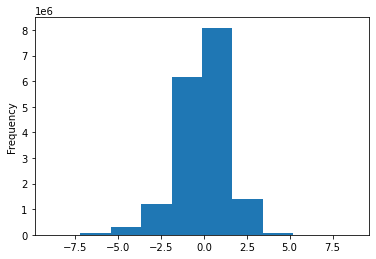

In [72]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [73]:
user_ratings_this_set.describe()

,Rating
count,1.730374e+07
mean,-6.773823e-02
std,1.406642e+00
min,-8.987106e+00
25%,-7.934736e-01
50%,3.298969e-02
75%,8.055556e-01
max,8.759036e+00


In [74]:
lower, upper = iqr_outliers(user_ratings_this_set.Rating, 1.5)
lower, upper

(-3.1920172599784276, 3.204099244875945)

In [75]:
# dropping the things outside of our lower and upper range
user_ratings_this_set.drop(user_ratings_this_set[ (user_ratings_this_set.Rating > upper) | (user_ratings_this_set.Rating < lower) ].index , inplace=True)

In [76]:
user_ratings_this_set.describe()

,Rating
count,1.667527e+07
mean,3.708114e-02
std,1.180005e+00
min,-3.192006e+00
25%,-7.054054e-01
50%,7.047355e-02
75%,8.159420e-01
max,3.204082e+00


<AxesSubplot:ylabel='Frequency'>

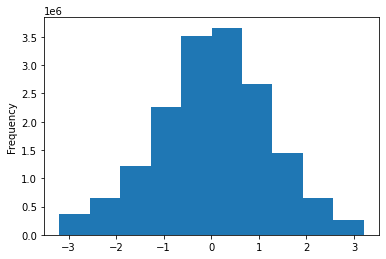

In [77]:
user_ratings_this_set['Rating'].plot(kind='hist')

In [80]:
bottom = user_ratings_this_set['Rating'].min()
top = user_ratings_this_set['Rating'].max()

data_reader = Reader(rating_scale=(bottom, top))

data = Dataset.load_from_df(user_ratings_this_set[['UserID', 'BGGId', 'Rating']], data_reader)

In [81]:
del user_ratings_this_set
gc.collect()

79

### Test Different Algorithms

In [145]:
benchmark = []

algorithms = [SVD(), 
              NormalPredictor(), 
              BaselineOnly(), 
             ]

# Iterate over all algorithms
for algorithm in algorithms:
    
    print("New Algorithm "+str(algorithm))
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(results_df)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

New Algorithm <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000021AEDCB7948>
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0609  1.0617  1.0618  1.0615  0.0004  
Fit time          322.02  324.66  324.12  323.60  1.14    
Test time         43.12   35.77   39.46   39.45   3.00    
New Algorithm <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x00000222B8D52D08>
Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.6980  1.6980  1.6982  1.6981  0.0001  
Fit time          8.97    12.26   12.00   11.07   1.49    
Test time         39.01   40.13   37.90   39.01   0.91    
New Algorithm <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x00000222B8E17808>
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE o

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.061459,323.597354,39.449385
BaselineOnly,1.066659,23.533339,40.373572
NormalPredictor,1.698086,11.074964,39.011809


### Fit and Predict

In [82]:
# build a full trainset
trainset = data.build_full_trainset()

# build_testset() makes a test set out of the same trainset data (it is NOT an anti_testset)
testset = trainset.build_testset()

In [83]:
# specify the algorithm
algo = BaselineOnly()

# fit algorithm to trainset
algo.fit(trainset)

# predict on trainset
base_data_synth_predictions = algo.test(testset)

Estimating biases using als...


### Validation Set Scoring

#### Validate Data on One User

In [84]:
# Select a user and item to validate data
user = 'moosh21'
item = 31260
user_mean = user_mean_lookup['moosh21']['user_mean']

In [86]:
# make df from the train set predictions (real actual ratings)
predictions_df = pd.DataFrame(base_data_synth_predictions)
user_df = predictions_df.loc[predictions_df['uid']==user]
user_df.head()

,uid,iid,r_ui,est,details
13395699,moosh21,158899,1.50878,-0.062010,{'was_impossible': False}
13395700,moosh21,200847,0.00878,-0.458378,{'was_impossible': False}
13395701,moosh21,148228,0.40878,0.149358,{'was_impossible': False}
13395702,moosh21,175117,0.00878,-0.125340,{'was_impossible': False}
13395703,moosh21,172220,1.50878,-0.072719,{'was_impossible': False}


In [87]:
# get the prediction for this real rated item
user_df.loc[user_df['iid']==item]['est']+user_mean

13395805    6.635555
Name: est, dtype: float64

In [88]:
# predict on the validation dataset
prediction = algo.predict(uid='moosh21', iid=item, verbose=True)
prediction[3]+user_mean_lookup['moosh21']['user_mean']

user: moosh21    item: 31260      r_ui = None   est = 0.64   {'was_impossible': False}


6.63555473840385

#### Score All Users

In [90]:
user_set = val_users
model_predictions_synth = {}

for uid in user_set:
    model_predictions_synth[uid] = {}
    for iid in game_ids:
        prediction = algo.predict(uid=uid, iid=iid, verbose=False)
        model_predictions_synth[uid][str(iid)] = prediction[3]+user_mean_lookup[uid]['user_mean']

In [91]:
mae_list = []
rmse_list = []
recall_list = []
all_recommended_items = []

for user in user_set:
    user_mean = user_mean_lookup[uid]['user_mean']
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], model_predictions_synth[user], user_mean)
    mae_list.append(user_mae)
    rmse_list.append(user_rmse)
    recall_list.append(recall)
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

In [92]:
global_mae = mean(mae_list)
global_rmse = mean(rmse_list)
global_recall = mean(recall_list)
global_coverage = len(all_recommended_items)/len(game_ids)

global_mae, global_rmse, global_recall, global_coverage

(0.9372322341283008, 1.2144201961567056, 33.74046262478695, 1.0)

The Model method, which achieving full catalog coverage, tanks on Recall and has very poor error. We continue to favor the memory-based model.

### Clean Up

In [97]:
del trainset
del testset
del algo
del data
del base_data_synth_predictions
del predictions_df
del user_df
del model_predictions_synth

gc.collect()

50

# Single User Testing

In [ ]:
user = 'Szczurek83'
user_mean = user_mean_lookup[user]['user_mean']

In [93]:
user = 'Threnody'
user_mean = user_mean_lookup[user]['user_mean']

In [94]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_scaled.json') as json_file:
    real_user_ratings_dictionary_scaled = json.load(json_file)

In [95]:
# Opening JSON file
with open('real_ratings/real_user_ratings_dictionary_unscaled.json') as json_file:
    real_user_ratings_dictionary_unscaled = json.load(json_file)

In [96]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())
names = {}

# for each item in the recommentation list,
for item in actual_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = real_user_ratings_dictionary_scaled[user][item]

names

{'Goa': -1.2224852071005916,
 'Cryptid': 0.7775147928994084,
 'Samurai': -1.2224852071005916,
 'Puerto Rico': -1.122485207100592,
 'Vegas Showdown': -0.2224852071005916,
 'Shadow Hunters': -0.2224852071005916,
 'Sorcerer City': 1.7775147928994084,
 'Elfenland': -0.7224852071005916,
 'Bohnanza': -0.2224852071005916,
 'Dinosaur Island': 1.7775147928994084,
 'Catan': -1.2224852071005916,
 'Vindication': 0.7775147928994084,
 'San Marco': -2.2224852071005916,
 'Catch Phrase!': -1.2224852071005916,
 'Kingsburg': -0.2224852071005916,
 'Agricola': -0.2224852071005916,
 'Evolution: The Beginning': -0.2224852071005916,
 'Dice Forge': 0.7775147928994084,
 'The Princes of Florence': -0.2224852071005916,
 'Mamma Mia!': -1.2224852071005916,
 'Lost Cities': -0.2224852071005916,
 "Sid Meier's Civilization: The Boardgame": -1.2224852071005916,
 'Moods': -1.2224852071005916,
 'Space Alert': 0.7775147928994084,
 'Mighty Monsters': -1.2224852071005916,
 'The Grimm Masquerade': 0.7775147928994084,
 'Raider

## Real Data

In [98]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [99]:
resources_pack = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 5, 250, 6
parameters = [v, k, n]

In [100]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [101]:
len(similarity_dictionary)

79052

In [102]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

,0
Jeanne_Katte,1.000000
dmzayas,1.000000
Lipstickpaddy,1.000000
matemusician,1.000000
Steven Universe,1.000000
...,...
Nowling,-0.954945
Thane Cawdor,-0.958833
Satanete,-0.961675
Faël,-0.964923


In [103]:
# score user
mae, rmse, recall, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=False)

5 250 6
Calculating Threnody
Found 79052 potential neighbors in common at v: 5 k: 250 n:6
Predicted 366 ratings
MAE for set of users: 0.4878987708611185
RMSE for set of users: 0.7409411848825643
Recall for set of users: 62.89
Time elapsed: 0.9578707218170166


In [104]:
user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], this_user_predictions[user], user_mean)

In [105]:
user_mae, user_rmse, recall

(0.4878987708611185, 0.7409411848825643, 62.89)

In [106]:
actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [107]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [108]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

,Estimated Rating
Kingdom Death: Monster,8.795186
Gloomhaven: Jaws of the Lion,8.744335
Gaia Project,8.534665
Sid Meier's Civilization: The Board Game,8.447655
The Lord of the Rings: Journeys in Middle-Earth,8.371081
Pandemic Legacy: Season 0,8.366892
War of the Ring,8.341978
Anachrony,8.299964
Twilight Imperium: Third Edition,8.257993
Pandemic: The Cure,8.224446


## Synthetic Data

In [109]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [110]:
# make a list of all synth rated item ids
synth_rated_items = list(synth_user_ratings_dictionary_scaled100[user].keys())
names = {}

# for each item in the recommentation list,
for item in synth_rated_items:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    names[item_name] = synth_user_ratings_dictionary_scaled100[user][item]

pd.DataFrame(names.values(), index=names.keys()).sort_values(0, ascending=False).head(20).reset_index()

,index,0
0,Roll Player,2.777515
1,Magic: The Gathering,2.777515
2,One Night Ultimate Werewolf: Daybreak,2.777515
3,The Castles of Burgundy,2.777515
4,Pandemic Legacy: Season 2,2.777515
5,Between Two Cities,2.777515
6,One Night Ultimate Werewolf,2.777515
7,Gloomhaven,2.777515
8,Pandemic Legacy: Season 1,2.777515
9,The Grizzled,2.777515


In [111]:
temp_dict = {}
for person in real_user_ratings_dictionary_scaled:
    temp_dict[person] = {}

In [114]:
resources_pack = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, temp_dict]
v, k, n = 5, 250, 5
parameters = [v, k, n]

In [100]:
# unpack the resources pack
all_users_ratings = resources_pack[0]
real_users_ratings = resources_pack[1]
this_dictionary = resources_pack[2]

    
# make a list of the user_a reviewed items
user_items = list(all_users_ratings[user].keys())
    
# make a distance dictionary for this user
similarity_dictionary={}
        
similarity_dictionary = get_user_similarity(this_dictionary, user, all_users_ratings, user_items, v)

In [101]:
len(similarity_dictionary)

79052

In [102]:
sim_group = pd.DataFrame(similarity_dictionary.values(), index=similarity_dictionary.keys())
sim_group.sort_values(0, ascending=False)[:250]

,0
Jeanne_Katte,1.000000
dmzayas,1.000000
Lipstickpaddy,1.000000
matemusician,1.000000
Steven Universe,1.000000
...,...
Nowling,-0.954945
Thane Cawdor,-0.958833
Satanete,-0.961675
Faël,-0.964923


In [115]:
# score user
mae, rmse, recall, this_user_predictions, item_set = get_user_predictions(resources_pack, [user], parameters, synth=True)

5 250 5
Calculating Threnody
Found 87634 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7027 ratings
MAE for set of users: 0.4860759506714247
RMSE for set of users: 0.7111109975523088
Recall for set of users: 62.35
Time elapsed: 11.878554344177246


In [116]:
# make a list of all actual rated item ids
actual_rated_items = list(real_user_ratings_dictionary_scaled[user].keys())

actuals_list = [item for item in this_user_predictions if item in actual_rated_items]
for item in actuals_list:
    print("Actual: "+str(real_user_ratings_dictionary_unscaled[user][item])+"\tPredicted: "+str(this_user_predictions[user][item]))

In [117]:
# the recommendations list of items that were predicted that were not actually rated
new_recommendations_list = [item for item in this_user_predictions[user] if item not in actual_rated_items]
new_recommendations_list

# make a dictionary for new recommendations
new_recommended_items = {}

# for each item in the recommentation list,
for item in new_recommendations_list:
    
    # get the actual game name
    item_name = game_id_lookup[int(item)]
    # append to the new recommendations dictionary
    new_recommended_items[item_name] = this_user_predictions[user][item]

In [118]:
# display and sort user recommendations
pd.DataFrame(new_recommended_items.values(), index=new_recommended_items.keys(), columns=['Estimated Rating']).sort_values('Estimated Rating', ascending=False).head(30)

,Estimated Rating
Advanced Squad Leader: Starter Kit #1,8.840617
Decision at Elst: An Advanced Squad Leader Starter Kit Historical Module,8.800628
Advanced Squad Leader: Starter Kit #2,8.728912
Advanced Squad Leader,8.692930
Star Fleet Battles: Captain's Edition Basic Set,8.665735
Advanced Squad Leader: Starter Kit #3,8.658069
Enemy Action: Ardennes,8.621850
Unconditional Surrender! World War 2 in Europe,8.594134
Napoleon's Triumph,8.591075
Clinic: Deluxe Edition,8.539280


# Model Evaluation and Selection

In [45]:
error_weight = .3
recall_weight = 1
coverage_weight = .5

### Get Test Set Scores - Real Data

In [32]:
# define best v, k, n

real_mae = []
real_rmse = []
real_recall = []
real_coverage = []

In [33]:
v, k, n = 7, 250, 5
parameters = [v, k, n]

In [34]:
real_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    real_distance_dictionary[user] = {}

In [36]:
# get the scores for the entire validation set
dictionary_set = [real_user_ratings_dictionary_scaled, real_user_ratings_dictionary_unscaled, real_distance_dictionary]

global_mae, global_rmse, global_recall, user_predictions_real_basismemory, items_in_set = get_user_predictions(dictionary_set, test_users, parameters, synth=False)

coverage = round(((len(items_in_set)/len(game_id_lookup))*100), 2)


real_mae.append(global_mae)
real_rmse.append(global_rmse)
real_recall.append(global_recall)
real_coverage.append(coverage)

7 250 5
Calculating lonelygeorge
Found 1102 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4924 ratings
Calculating filifjonka
Found 5899 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3995 ratings
Calculating Nocturne12
Found 23466 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1646 ratings
Calculating vsanzrom
Found 8275 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2606 ratings
Calculating Psychotron7x2
Found 32577 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1440 ratings
Calculating ghalgor
Found 1578 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4309 ratings
Calculating UnicornTess
Found 29014 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1266 ratings
Calculating mynameisfloog
Found 265 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5990 ratings
Calculating Trelane
Found 1352 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5601 ratings
Calculating Madilo
Found 4809 poten

Found 80170 potential neighbors in common at v: 7 k: 250 n:5
Predicted 389 ratings
Calculating Manu3012
Found 404 potential neighbors in common at v: 6 k: 250 n:5
Predicted 8808 ratings
Calculating WitchVampire
Found 7765 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4788 ratings
Calculating Timbertopper
Found 6143 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3179 ratings
Calculating 42datasquirrels
Found 2497 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4833 ratings
Calculating Tynee
Found 8054 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3060 ratings
Calculating jkasanen
Found 73375 potential neighbors in common at v: 7 k: 250 n:5
Predicted 419 ratings
Calculating Garau
Found 87283 potential neighbors in common at v: 7 k: 250 n:5
Predicted 317 ratings
Calculating EgoFumPapa
Found 38739 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1130 ratings
Calculating Gilnoir
Found 40540 potential neighbors in common at v: 7 k: 2

Found 38851 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1020 ratings
Calculating Popcanman84
Found 52350 potential neighbors in common at v: 7 k: 250 n:5
Predicted 815 ratings
Calculating Bassoonist
Found 14781 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2527 ratings
Calculating raynovich
Found 79805 potential neighbors in common at v: 7 k: 250 n:5
Predicted 405 ratings
Calculating OrochiMikele
Found 50663 potential neighbors in common at v: 7 k: 250 n:5
Predicted 821 ratings
Calculating otheym6
Found 1446 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5428 ratings
Calculating alacritygaming
Found 14413 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2348 ratings
Calculating zemoe1
Found 808 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6756 ratings
Calculating Kungwho
Found 31242 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1386 ratings
Calculating Bogavante Johnson
Found 17216 potential neighbors in commo

Predicted 4542 ratings
Calculating PruneauBE
Found 5097 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4339 ratings
Calculating Tolekino
Found 35461 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1076 ratings
Calculating Kyleroconnor
Found 18755 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1724 ratings
Calculating daviddeanw
Found 420 potential neighbors in common at v: 3 k: 250 n:5
Predicted 6806 ratings
Calculating alxndr
Found 29512 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1673 ratings
Calculating Haanden
Found 56460 potential neighbors in common at v: 7 k: 250 n:5
Predicted 698 ratings
Calculating pettzar
Found 54434 potential neighbors in common at v: 7 k: 250 n:5
Predicted 740 ratings
Calculating Wurzel
Found 566 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7674 ratings
Calculating wernervoss
Found 56547 potential neighbors in common at v: 7 k: 250 n:5
Predicted 951 ratings
Calculating Wildhorn
Found 86190 pote

Found 24308 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1447 ratings
Calculating Davefave
Found 10116 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3523 ratings
Calculating jmenctthey
Found 62780 potential neighbors in common at v: 7 k: 250 n:5
Predicted 511 ratings
Calculating mhaessler
Found 40761 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1008 ratings
Calculating jonathens
Found 280 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7701 ratings
Calculating codykraz
Found 78061 potential neighbors in common at v: 7 k: 250 n:5
Predicted 350 ratings
Calculating ROFL_waffle
Found 2892 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4834 ratings
Calculating trauma14
Found 33860 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1221 ratings
Calculating lynayyy
Found 4248 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2917 ratings
Calculating Didier_C
Found 403 potential neighbors in common at v: 1 k: 250 

Predicted 3619 ratings
Calculating indygamergirl
Found 772 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6361 ratings
Calculating dunne
Found 617 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6527 ratings
Calculating PFJN
Found 318 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7866 ratings
Calculating ngubugi
Found 776 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6300 ratings
Calculating Iskander4000
Found 558 potential neighbors in common at v: 2 k: 250 n:5
Predicted 4649 ratings
Calculating EricGamesInSanfordFL
Found 367 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7997 ratings
Calculating Neverstopkillinx
Found 251 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7440 ratings
Calculating tremechus
Found 27402 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1683 ratings
Calculating SleeveMcDichael
Found 16299 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2136 ratings
Calculating Shane

Found 21805 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2508 ratings
Calculating rupertroad
Found 3073 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5761 ratings
Calculating Akroatis
Found 70074 potential neighbors in common at v: 7 k: 250 n:5
Predicted 481 ratings
Calculating theericbooth
Found 64565 potential neighbors in common at v: 7 k: 250 n:5
Predicted 477 ratings
Calculating techingtenor
Found 15776 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2289 ratings
Calculating Tommy223
Found 19853 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1891 ratings
Calculating hurkle
Found 11585 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2848 ratings
Calculating BIGcountrySHAKE
Found 69321 potential neighbors in common at v: 7 k: 250 n:5
Predicted 566 ratings
Calculating Seldrim
Found 23971 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1736 ratings
Calculating ste_t88
Found 1382 potential neighbors in common at v:

Found 36649 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1683 ratings
Calculating ZarooS
Found 64734 potential neighbors in common at v: 7 k: 250 n:5
Predicted 529 ratings
Calculating LordBevo
Found 481 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5995 ratings
Calculating molnarm
Found 1019 potential neighbors in common at v: 6 k: 250 n:5
Predicted 4467 ratings
Calculating dkreth
Found 260 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7928 ratings
Calculating atavachron
Found 4207 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3527 ratings
Calculating Egesi
Found 315 potential neighbors in common at v: 1 k: 250 n:5
Predicted 6806 ratings
Calculating WalkingE
Found 35251 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1468 ratings
Calculating djuleski
Found 12481 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2143 ratings
Calculating f00k
Found 9012 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2622

Predicted 435 ratings
Calculating argueveur
Found 46384 potential neighbors in common at v: 7 k: 250 n:5
Predicted 870 ratings
Calculating dexl
Found 38698 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1212 ratings
Calculating topdaryl
Found 311 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6644 ratings
Calculating blotzor
Found 9503 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2706 ratings
Calculating SchlechterWolf
Found 32030 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1453 ratings
Calculating Funguy
Found 70773 potential neighbors in common at v: 7 k: 250 n:5
Predicted 512 ratings
Calculating Colliath
Found 733 potential neighbors in common at v: 2 k: 250 n:5
Predicted 5885 ratings
Calculating XxRegularJoexX
Found 34799 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1426 ratings
Calculating Usufferinvain
Found 490 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6433 ratings
Calculating Count Obsideo
Found

Predicted 1681 ratings
Calculating dagobal
Found 37893 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1126 ratings
Calculating DefendPaladin
Found 1775 potential neighbors in common at v: 4 k: 250 n:5
Predicted 3222 ratings
Calculating budkin
Found 48405 potential neighbors in common at v: 7 k: 250 n:5
Predicted 909 ratings
Calculating godrik
Found 26776 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1613 ratings
Calculating Spatperson
Found 509 potential neighbors in common at v: 6 k: 250 n:5
Predicted 8246 ratings
Calculating maerlyn
Found 34256 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1019 ratings
Calculating arik100
Found 57926 potential neighbors in common at v: 7 k: 250 n:5
Predicted 626 ratings
Calculating GearPimp
Found 57182 potential neighbors in common at v: 7 k: 250 n:5
Predicted 737 ratings
Calculating Ralamandastron
Found 17964 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2145 ratings
Calculating PaperTank
Found 366 

Found 268 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8674 ratings
Calculating LeeKenshin
Found 38117 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1056 ratings
Calculating pirate_chef
Found 28046 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1513 ratings
Calculating bvollmay
Found 12657 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2500 ratings
Calculating kakfroken
Found 48119 potential neighbors in common at v: 7 k: 250 n:5
Predicted 940 ratings
Calculating ricefrisbeetreats
Found 18815 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2564 ratings
Calculating Sartou
Found 19651 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2278 ratings
Calculating srd5090
Found 2437 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3361 ratings
Calculating bsonline23
Found 3594 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4715 ratings
Calculating UndeadGunner
Found 62177 potential neighbors in common 

Predicted 4045 ratings
Calculating RMahone
Found 50456 potential neighbors in common at v: 7 k: 250 n:5
Predicted 815 ratings
Calculating LesEpinards
Found 317 potential neighbors in common at v: 1 k: 250 n:5
Predicted 8999 ratings
Calculating Deletion79
Found 29715 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1449 ratings
Calculating Frustracja
Found 28470 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1338 ratings
Calculating Tomobomo
Found 412 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6793 ratings
Calculating aussieb1987
Found 25818 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1877 ratings
Calculating LostSoul
Found 2535 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4978 ratings
Calculating Robert Blake
Found 62307 potential neighbors in common at v: 7 k: 250 n:5
Predicted 585 ratings
Calculating robotmachine
Found 464 potential neighbors in common at v: 2 k: 250 n:5
Predicted 7362 ratings
Calculating Jawshco
Foun

Found 11123 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2285 ratings
Calculating alleserik
Found 77305 potential neighbors in common at v: 7 k: 250 n:5
Predicted 421 ratings
Calculating Caret196
Found 255 potential neighbors in common at v: 2 k: 250 n:5
Predicted 9063 ratings
Calculating tropensturm
Found 4940 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3523 ratings
Calculating giulicasti88
Found 1171 potential neighbors in common at v: 3 k: 250 n:5
Predicted 5846 ratings
Calculating zweigefuhle
Found 402 potential neighbors in common at v: 2 k: 250 n:5
Predicted 6474 ratings
Calculating maaikefest
Found 60848 potential neighbors in common at v: 7 k: 250 n:5
Predicted 528 ratings
Calculating Luzbelito
Found 588 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4835 ratings
Calculating 2twins64
Found 1894 potential neighbors in common at v: 2 k: 250 n:5
Predicted 4881 ratings
Calculating bubukova
Found 28135 potential neighbors in common at v: 7 k:

Found 302 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7369 ratings
Calculating PaGeN
Found 3481 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4540 ratings
Calculating frodolotr123
Found 503 potential neighbors in common at v: 6 k: 250 n:5
Predicted 5003 ratings
Calculating Bradennash
Found 39041 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1307 ratings
Calculating natehylton
Found 24211 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1840 ratings
Calculating garypen
Found 20245 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2191 ratings
Calculating rambert
Found 8672 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2070 ratings
Calculating luminarious
Found 74013 potential neighbors in common at v: 7 k: 250 n:5
Predicted 471 ratings
Calculating thomasm
Found 32427 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1397 ratings
Calculating jpropp2
Found 2769 potential neighbors in common at v: 3 k: 250 n:

Found 52966 potential neighbors in common at v: 7 k: 250 n:5
Predicted 804 ratings
Calculating mgormsen2
Found 37681 potential neighbors in common at v: 7 k: 250 n:5
Predicted 906 ratings
Calculating inumii
Found 2685 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4437 ratings
Calculating Zossima
Found 63483 potential neighbors in common at v: 7 k: 250 n:5
Predicted 607 ratings
Calculating critcounter
Found 1634 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6686 ratings
Calculating Gamebeaver
Found 1074 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6789 ratings
Calculating Qbela
Found 49372 potential neighbors in common at v: 7 k: 250 n:5
Predicted 826 ratings
Calculating Ruminator
Found 368 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7025 ratings
Calculating Roonin
Found 8505 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4111 ratings
Calculating mramsey
Found 313 potential neighbors in common at v: 4 k: 250 n:5
Predicte

Found 24421 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1231 ratings
Calculating georgescu
Found 15411 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2441 ratings
Calculating GregK
Found 456 potential neighbors in common at v: 7 k: 250 n:5
Predicted 9134 ratings
Calculating rublind
Found 270 potential neighbors in common at v: 3 k: 250 n:5
Predicted 8100 ratings
Calculating jeffgoodlin
Found 37691 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1065 ratings
Calculating trevlix
Found 12041 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2779 ratings
Calculating pahapasi
Found 16166 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2215 ratings
Calculating SponJ
Found 3212 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3628 ratings
Calculating caplander
Found 47970 potential neighbors in common at v: 7 k: 250 n:5
Predicted 907 ratings
Calculating Xaii
Found 17682 potential neighbors in common at v: 7 k: 250 n:5
Predict

Found 425 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7317 ratings
Calculating Mecki
Found 5741 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3044 ratings
Calculating sumobiznaz
Found 62185 potential neighbors in common at v: 7 k: 250 n:5
Predicted 662 ratings
Calculating username_138
Found 436 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7790 ratings
Calculating CottonCthulhu
Found 11146 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2166 ratings
Calculating karadum
Found 56736 potential neighbors in common at v: 7 k: 250 n:5
Predicted 682 ratings
Calculating Bensch7
Found 28571 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1232 ratings
Calculating okdawg21
Found 33280 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1243 ratings
Calculating sand_4_life
Found 980 potential neighbors in common at v: 3 k: 250 n:5
Predicted 5750 ratings
Calculating littlemute
Found 56620 potential neighbors in common at v: 7 k: 

Found 72206 potential neighbors in common at v: 7 k: 250 n:5
Predicted 492 ratings
Calculating darkpact
Found 79704 potential neighbors in common at v: 7 k: 250 n:5
Predicted 370 ratings
Calculating crowchaser
Found 81041 potential neighbors in common at v: 7 k: 250 n:5
Predicted 353 ratings
Calculating incremental
Found 14935 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2464 ratings
Calculating RLarsen
Found 12768 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2259 ratings
Calculating pmikec
Found 503 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5827 ratings
Calculating clemenswb
Found 447 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7945 ratings
Calculating ChristianHardy85
Found 20736 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1992 ratings
Calculating papacione
Found 47184 potential neighbors in common at v: 7 k: 250 n:5
Predicted 781 ratings
Calculating ScytheNoire
Found 518 potential neighbors in common at v: 7 

Predicted 827 ratings
Calculating nocrack
Found 9568 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2488 ratings
Calculating Corpse_Noir
Found 47508 potential neighbors in common at v: 7 k: 250 n:5
Predicted 925 ratings
Calculating FirstRevanite
Found 490 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5997 ratings
Calculating FeWolf
Found 956 potential neighbors in common at v: 1 k: 250 n:5
Predicted 3809 ratings
Calculating Xardok
Found 19837 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2166 ratings
Calculating Danipuntocom
Found 57082 potential neighbors in common at v: 7 k: 250 n:5
Predicted 648 ratings
Calculating agamecafe
Found 48928 potential neighbors in common at v: 7 k: 250 n:5
Predicted 831 ratings
Calculating AnubisRW
Found 464 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6971 ratings
Calculating Wolf_3
Found 267 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6250 ratings
Calculating Ellite25
Found 59644 potent

Found 10686 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2916 ratings
Calculating mikex4511
Found 43042 potential neighbors in common at v: 7 k: 250 n:5
Predicted 934 ratings
Calculating coker
Found 19524 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1958 ratings
Calculating IndianaJohn
Found 47801 potential neighbors in common at v: 7 k: 250 n:5
Predicted 926 ratings
Calculating Risk
Found 78376 potential neighbors in common at v: 7 k: 250 n:5
Predicted 468 ratings
Calculating snnoball
Found 40124 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1074 ratings
Calculating Gabriel_Kuriata
Found 40537 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1015 ratings
Calculating ElKitch
Found 308 potential neighbors in common at v: 7 k: 250 n:5
Predicted 9236 ratings
Calculating yeknom02
Found 16443 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2002 ratings
Calculating Myth3r
Found 4988 potential neighbors in common at v: 7 k: 250 n:5

Found 23627 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1547 ratings
Calculating Ambrosius
Found 367 potential neighbors in common at v: 4 k: 250 n:5
Predicted 8857 ratings
Calculating Blitz37
Found 42955 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1013 ratings
Calculating Perivale
Found 23305 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1389 ratings
Calculating allan647
Found 32177 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1392 ratings
Calculating IndyMD
Found 608 potential neighbors in common at v: 1 k: 250 n:5
Predicted 4690 ratings
Calculating RCrichy
Found 2869 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3744 ratings
Calculating AnvilJKU
Found 2383 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4051 ratings
Calculating OORenoOO
Found 420 potential neighbors in common at v: 3 k: 250 n:5
Predicted 7030 ratings
Calculating SimonSes
Found 24950 potential neighbors in common at v: 7 k: 250 n:5
Predi

Predicted 1371 ratings
Calculating Sentient Void
Found 10637 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2753 ratings
Calculating nodonnell3
Found 53907 potential neighbors in common at v: 7 k: 250 n:5
Predicted 888 ratings
Calculating massi_x
Found 25860 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1427 ratings
Calculating DustyRhino
Found 24424 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1765 ratings
Calculating Bbozze
Found 33706 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1413 ratings
Calculating pdallair
Found 61043 potential neighbors in common at v: 7 k: 250 n:5
Predicted 608 ratings
Calculating QPCloudy
Found 438 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8386 ratings
Calculating elpolillo
Found 36817 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1180 ratings
Calculating Lavrik
Found 399 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8243 ratings
Calculating agichan
Found 528 pot

Found 7398 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2971 ratings
Calculating Sir Gerard
Found 64144 potential neighbors in common at v: 7 k: 250 n:5
Predicted 705 ratings
Calculating bbohr
Found 51092 potential neighbors in common at v: 7 k: 250 n:5
Predicted 878 ratings
Calculating Lord Hyperion
Found 57409 potential neighbors in common at v: 7 k: 250 n:5
Predicted 580 ratings
Calculating Arnaud_Bouis
Found 21657 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1934 ratings
Calculating drsheep
Found 38093 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1026 ratings
Calculating Raabeyes
Found 74830 potential neighbors in common at v: 7 k: 250 n:5
Predicted 467 ratings
Calculating Megasabin
Found 22968 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1462 ratings
Calculating boardgamebahrain
Found 53224 potential neighbors in common at v: 7 k: 250 n:5
Predicted 795 ratings
Calculating Ruimtevaarder
Found 47225 potential neighbors in commo

Predicted 499 ratings
Calculating gaberlunzi
Found 3086 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5090 ratings
Calculating forgewalker
Found 432 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8430 ratings
Calculating don_lope
Found 47650 potential neighbors in common at v: 7 k: 250 n:5
Predicted 812 ratings
Calculating Czerwony_Mag
Found 68897 potential neighbors in common at v: 7 k: 250 n:5
Predicted 531 ratings
Calculating Fieldchart
Found 322 potential neighbors in common at v: 1 k: 250 n:5
Predicted 5521 ratings
Calculating Smitthew
Found 395 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6385 ratings
Calculating Mymyt
Found 44402 potential neighbors in common at v: 7 k: 250 n:5
Predicted 746 ratings
Calculating puppylove968
Found 7210 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4027 ratings
Calculating keoga
Found 17627 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2329 ratings
Calculating ant_1sama
Found 62913 p

Predicted 1288 ratings
Calculating boardgamefan1982
Found 34130 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1241 ratings
Calculating Charlyp
Found 50210 potential neighbors in common at v: 7 k: 250 n:5
Predicted 856 ratings
Calculating Darrenz76
Found 2363 potential neighbors in common at v: 6 k: 250 n:5
Predicted 4153 ratings
Calculating Seeversa
Found 335 potential neighbors in common at v: 3 k: 250 n:5
Predicted 8786 ratings
Calculating Nerdolf
Found 387 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7943 ratings
Calculating KristoferP
Found 64749 potential neighbors in common at v: 7 k: 250 n:5
Predicted 612 ratings
Calculating Joanna_Gesa
Found 301 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8287 ratings
Calculating Pben09
Found 1563 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5348 ratings
Calculating PATRY0704
Found 1300 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5523 ratings
Calculating deathrayoperator
Fou

Found 1312 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6312 ratings
Calculating ivinia
Found 418 potential neighbors in common at v: 2 k: 250 n:5
Predicted 8429 ratings
Calculating shagrath3x
Found 34505 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1133 ratings
Calculating vogella
Found 69928 potential neighbors in common at v: 7 k: 250 n:5
Predicted 551 ratings
Calculating Harlequinlite
Found 29758 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1471 ratings
Calculating gzamira
Found 77087 potential neighbors in common at v: 7 k: 250 n:5
Predicted 390 ratings
Calculating LosNossos
Found 72095 potential neighbors in common at v: 7 k: 250 n:5
Predicted 483 ratings
Calculating Nasia
Found 71268 potential neighbors in common at v: 7 k: 250 n:5
Predicted 516 ratings
Calculating CowWarrior
Found 28578 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1711 ratings
Calculating gusjustgus1
Found 71875 potential neighbors in common at v: 7 k: 250

Found 14633 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2662 ratings
Calculating Malmen
Found 35577 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1054 ratings
Calculating upurplay
Found 4473 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3166 ratings
Calculating HexStarDragon
Found 18127 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1803 ratings
Calculating trollitc
Found 55409 potential neighbors in common at v: 7 k: 250 n:5
Predicted 788 ratings
Calculating ZandarrTheGreat
Found 13927 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2721 ratings
Calculating ComradeQ
Found 10661 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2907 ratings
Calculating emel
Found 7430 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3818 ratings
Calculating Sarahpowerwolf85
Found 642 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6375 ratings
Calculating MonsterParty
Found 7000 potential neighbors in common a

Predicted 2192 ratings
Calculating Waaru
Found 20632 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1959 ratings
Calculating uweeickert
Found 5488 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3774 ratings
Calculating Guodan
Found 15690 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1863 ratings
Calculating lcarus
Found 82546 potential neighbors in common at v: 7 k: 250 n:5
Predicted 336 ratings
Calculating LocalHourglass
Found 57764 potential neighbors in common at v: 7 k: 250 n:5
Predicted 668 ratings
Calculating great177
Found 1511 potential neighbors in common at v: 4 k: 250 n:5
Predicted 4638 ratings
Calculating beppelecce
Found 252 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7346 ratings
Calculating donutmagi
Found 52838 potential neighbors in common at v: 7 k: 250 n:5
Predicted 679 ratings
Calculating justinbrauchler
Found 41384 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1064 ratings
Calculating Gorphax
Found 78

Predicted 4768 ratings
Calculating Mindshred
Found 549 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6781 ratings
Calculating Ribouldingue
Found 77441 potential neighbors in common at v: 7 k: 250 n:5
Predicted 398 ratings
Calculating Andreas
Found 253 potential neighbors in common at v: 4 k: 250 n:5
Predicted 8927 ratings
Calculating Uselesspanic
Found 35953 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1353 ratings
Calculating Ubivis
Found 22857 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1801 ratings
Calculating Uniqueliy
Found 65148 potential neighbors in common at v: 7 k: 250 n:5
Predicted 553 ratings
Calculating Monkubus
Found 1513 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5343 ratings
Calculating sedlak87
Found 37758 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1074 ratings
Calculating Feelitmon
Found 31417 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1216 ratings
Calculating odo1982
Found 680 p

Found 3379 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4765 ratings
Calculating philipcheesy
Found 20302 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2135 ratings
Calculating skyknight
Found 64434 potential neighbors in common at v: 7 k: 250 n:5
Predicted 642 ratings
Calculating robsterdobster
Found 761 potential neighbors in common at v: 2 k: 250 n:5
Predicted 5978 ratings
Calculating AlbertOne
Found 426 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7418 ratings
Calculating eliteone
Found 958 potential neighbors in common at v: 3 k: 250 n:5
Predicted 3527 ratings
Calculating Bill Martinson
Found 18783 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1791 ratings
Calculating Chookbilly
Found 31571 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1540 ratings
Calculating jinxidoru
Found 13658 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2948 ratings
Calculating bluepenguin
Found 8454 potential neighbors in commo

Found 6262 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3605 ratings
Calculating Kosacki
Found 2463 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5580 ratings
Calculating shkuey
Found 593 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5515 ratings
Calculating oddopuscomposer
Found 879 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7186 ratings
Calculating primoclark
Found 31203 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1231 ratings
Calculating kyziu87
Found 72983 potential neighbors in common at v: 7 k: 250 n:5
Predicted 448 ratings
Calculating Jamesb0b
Found 1543 potential neighbors in common at v: 2 k: 250 n:5
Predicted 5844 ratings
Calculating Batjoker
Found 3111 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3614 ratings
Calculating Freddy_K
Found 17394 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2074 ratings
Calculating hakko504
Found 62098 potential neighbors in common at v: 7 k: 250 n:

Found 6870 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2798 ratings
Calculating soundsnaive
Found 76022 potential neighbors in common at v: 7 k: 250 n:5
Predicted 437 ratings
Calculating ryufyre
Found 816 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5443 ratings
Calculating PioPix
Found 755 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6018 ratings
Calculating Norsbane
Found 770 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6652 ratings
Calculating Humunculi
Found 33253 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1506 ratings
Calculating Seismic_Raptor
Found 35951 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1547 ratings
Calculating cirroid
Found 26555 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1331 ratings
Calculating Jaakima
Found 77015 potential neighbors in common at v: 7 k: 250 n:5
Predicted 425 ratings
Calculating robindog
Found 58161 potential neighbors in common at v: 7 k: 250 n:

Found 44902 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1174 ratings
Calculating laleluoom
Found 23414 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1666 ratings
Calculating WildeSpiele
Found 21033 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1851 ratings
Calculating live4outdoors
Found 36427 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1427 ratings
Calculating dlcnate1
Found 760 potential neighbors in common at v: 3 k: 250 n:5
Predicted 6652 ratings
Calculating Woofalot
Found 808 potential neighbors in common at v: 2 k: 250 n:5
Predicted 5368 ratings
Calculating tpgrove
Found 72849 potential neighbors in common at v: 7 k: 250 n:5
Predicted 501 ratings
Calculating Ry1212
Found 308 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6537 ratings
Calculating iskarioth44
Found 78654 potential neighbors in common at v: 7 k: 250 n:5
Predicted 431 ratings
Calculating DBUTT
Found 620 potential neighbors in common at v: 5 k: 250 n:

Found 317 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6941 ratings
Calculating wittypan
Found 41634 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1117 ratings
Calculating erenst
Found 20683 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2010 ratings
Calculating Eara1
Found 12087 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2988 ratings
Calculating Hamface
Found 82246 potential neighbors in common at v: 7 k: 250 n:5
Predicted 362 ratings
Calculating eric_s_raymond
Found 729 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6137 ratings
Calculating InfOutlaw
Found 37164 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1106 ratings
Calculating Blubal
Found 49563 potential neighbors in common at v: 7 k: 250 n:5
Predicted 795 ratings
Calculating Sneeuwvolkje
Found 33830 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1433 ratings
Calculating PurpleSkyFire
Found 22934 potential neighbors in common at v: 7 k: 

Found 12215 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2068 ratings
Calculating MeeplePeakBGC
Found 430 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7166 ratings
Calculating nataliasdaddy
Found 13437 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2572 ratings
Calculating waterfallfaery
Found 71028 potential neighbors in common at v: 7 k: 250 n:5
Predicted 445 ratings
Calculating danielfoxe
Found 820 potential neighbors in common at v: 2 k: 250 n:5
Predicted 5072 ratings
Calculating ASBlacky
Found 29447 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1651 ratings
Calculating Mad Scientist
Found 58797 potential neighbors in common at v: 7 k: 250 n:5
Predicted 784 ratings
Calculating James_Collins
Found 53908 potential neighbors in common at v: 7 k: 250 n:5
Predicted 851 ratings
Calculating brenderlin78
Found 442 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7359 ratings
Calculating dmrzzz
Found 52609 potential neighbors in

Found 16054 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2438 ratings
Calculating TheGoblin
Found 54286 potential neighbors in common at v: 7 k: 250 n:5
Predicted 739 ratings
Calculating sillywilly916
Found 29649 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1700 ratings
Calculating timeodanaos
Found 31668 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1491 ratings
Calculating jgalarneau
Found 70143 potential neighbors in common at v: 7 k: 250 n:5
Predicted 446 ratings
Calculating B0BAfettt
Found 2382 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4393 ratings
Calculating Aleaeon
Found 25228 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1377 ratings
Calculating angelzafiro8585
Found 386 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7551 ratings
Calculating jwent2
Found 44880 potential neighbors in common at v: 7 k: 250 n:5
Predicted 960 ratings
Calculating mdkiria
Found 19399 potential neighbors in common at v

Found 296 potential neighbors in common at v: 3 k: 250 n:5
Predicted 8183 ratings
Calculating bak5187
Found 915 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5117 ratings
Calculating djtzaba
Found 29081 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1260 ratings
Calculating mssweene
Found 36326 potential neighbors in common at v: 7 k: 250 n:5
Predicted 984 ratings
Calculating MKK_Rory
Found 57416 potential neighbors in common at v: 7 k: 250 n:5
Predicted 789 ratings
Calculating stebai
Found 25007 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2025 ratings
Calculating LaughingTulkas
Found 63597 potential neighbors in common at v: 7 k: 250 n:5
Predicted 651 ratings
Calculating The Hypnotoad
Found 10508 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2876 ratings
Calculating Wargame Wezyr
Found 469 potential neighbors in common at v: 3 k: 250 n:5
Predicted 5626 ratings
Calculating sethholder
Found 28388 potential neighbors in common at v: 7 

Found 12838 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2801 ratings
Calculating Stealthy101
Found 13900 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1750 ratings
Calculating RobJonBA
Found 2279 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4965 ratings
Calculating Fir3inCairo
Found 7038 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3113 ratings
Calculating the_Bzyk
Found 68543 potential neighbors in common at v: 7 k: 250 n:5
Predicted 497 ratings
Calculating LudwigVanB
Found 36274 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1217 ratings
Calculating miforaz
Found 60883 potential neighbors in common at v: 7 k: 250 n:5
Predicted 737 ratings
Calculating Uksweeney
Found 50606 potential neighbors in common at v: 7 k: 250 n:5
Predicted 985 ratings
Calculating piratestuff
Found 51005 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1008 ratings
Calculating GranNevada
Found 3713 potential neighbors in common at v: 

Found 17234 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2774 ratings
Calculating REINHARM
Found 57352 potential neighbors in common at v: 7 k: 250 n:5
Predicted 636 ratings
Calculating Mattnolan12
Found 8269 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3088 ratings
Calculating angst
Found 51807 potential neighbors in common at v: 7 k: 250 n:5
Predicted 821 ratings
Calculating pepelefrogg
Found 28162 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1491 ratings
Calculating the Tantoblin
Found 46327 potential neighbors in common at v: 7 k: 250 n:5
Predicted 832 ratings
Calculating keunwoo
Found 50404 potential neighbors in common at v: 7 k: 250 n:5
Predicted 807 ratings
Calculating glico_curry
Found 11276 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1914 ratings
Calculating audiolight
Found 8390 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3015 ratings
Calculating Mutule
Found 14738 potential neighbors in common at v: 7 k

Predicted 5116 ratings
Calculating UndyingHate
Found 47870 potential neighbors in common at v: 7 k: 250 n:5
Predicted 864 ratings
Calculating ScottOwens
Found 36261 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1100 ratings
Calculating asvec12
Found 57437 potential neighbors in common at v: 7 k: 250 n:5
Predicted 634 ratings
Calculating Snowdazey
Found 1589 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5762 ratings
Calculating restaurant3000
Found 1893 potential neighbors in common at v: 3 k: 250 n:5
Predicted 4290 ratings
Calculating NoobsliceZA
Found 1493 potential neighbors in common at v: 3 k: 250 n:5
Predicted 4959 ratings
Calculating LordKharn
Found 42407 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1018 ratings
Calculating Shujinko
Found 6675 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2789 ratings
Calculating SMGP Kosci
Found 846 potential neighbors in common at v: 0 k: 250 n:5
Predicted 3273 ratings
Calculating abismald
Fo

Found 76103 potential neighbors in common at v: 7 k: 250 n:5
Predicted 464 ratings
Calculating mariuszrybnik
Found 44003 potential neighbors in common at v: 7 k: 250 n:5
Predicted 962 ratings
Calculating Malerris
Found 51541 potential neighbors in common at v: 7 k: 250 n:5
Predicted 583 ratings
Calculating Neabog
Found 13486 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2737 ratings
Calculating KooperU
Found 44964 potential neighbors in common at v: 7 k: 250 n:5
Predicted 994 ratings
Calculating paperemail
Found 10852 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2716 ratings
Calculating Lakridspibe
Found 37066 potential neighbors in common at v: 7 k: 250 n:5
Predicted 972 ratings
Calculating HalfManHalfBiscuit
Found 7454 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3602 ratings
Calculating chsy
Found 36078 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1041 ratings
Calculating Geurt
Found 15184 potential neighbors in common at v: 7 k

Found 312 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7364 ratings
Calculating NotreDame25
Found 52680 potential neighbors in common at v: 7 k: 250 n:5
Predicted 765 ratings
Calculating Chrismill
Found 49455 potential neighbors in common at v: 7 k: 250 n:5
Predicted 828 ratings
Calculating jmw23
Found 62815 potential neighbors in common at v: 7 k: 250 n:5
Predicted 685 ratings
Calculating Anakha88
Found 43523 potential neighbors in common at v: 7 k: 250 n:5
Predicted 943 ratings
Calculating Flibus
Found 46720 potential neighbors in common at v: 7 k: 250 n:5
Predicted 912 ratings
Calculating Mintyy
Found 15814 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2114 ratings
Calculating kardos16
Found 89009 potential neighbors in common at v: 7 k: 250 n:5
Predicted 273 ratings
Calculating MooseTheElder
Found 383 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6777 ratings
Calculating winddrake
Found 966 potential neighbors in common at v: 6 k: 250 n:5
Pre

Found 35679 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1305 ratings
Calculating joerg73
Found 74499 potential neighbors in common at v: 7 k: 250 n:5
Predicted 459 ratings
Calculating archiegoodw1n
Found 23869 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1820 ratings
Calculating CrashBandicoot
Found 20020 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1973 ratings
Calculating django5
Found 10824 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2919 ratings
Calculating Chabu
Found 52096 potential neighbors in common at v: 7 k: 250 n:5
Predicted 707 ratings
Calculating Samiepage
Found 7930 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3992 ratings
Calculating davedaring
Found 536 potential neighbors in common at v: 7 k: 250 n:5
Predicted 7235 ratings
Calculating Marsiozie
Found 3222 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4794 ratings
Calculating supermarioworldme
Found 832 potential neighbors in common at

Found 23714 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1661 ratings
Calculating Radiatron
Found 1095 potential neighbors in common at v: 4 k: 250 n:5
Predicted 6271 ratings
Calculating rossik
Found 1212 potential neighbors in common at v: 2 k: 250 n:5
Predicted 4989 ratings
Calculating nick
Found 9222 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2976 ratings
Calculating veenickz
Found 58843 potential neighbors in common at v: 7 k: 250 n:5
Predicted 667 ratings
Calculating Raxen
Found 4113 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4454 ratings
Calculating AccidentalMagic
Found 1166 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5718 ratings
Calculating CetchFury
Found 33393 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1578 ratings
Calculating Thanlithos
Found 33923 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1587 ratings
Calculating Sunchild
Found 863 potential neighbors in common at v: 7 k: 250 n:5


Found 27571 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1700 ratings
Calculating MARIANOJS
Found 77993 potential neighbors in common at v: 7 k: 250 n:5
Predicted 410 ratings
Calculating Malakhel
Found 943 potential neighbors in common at v: 2 k: 250 n:5
Predicted 4976 ratings
Calculating talisman_stl
Found 23337 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2057 ratings
Calculating Sangla
Found 466 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7868 ratings
Calculating yoqb
Found 276 potential neighbors in common at v: 6 k: 250 n:5
Predicted 9047 ratings
Calculating Mr Freedly
Found 56032 potential neighbors in common at v: 7 k: 250 n:5
Predicted 650 ratings
Calculating rayleigh00
Found 370 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7877 ratings
Calculating Depansho
Found 7603 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2264 ratings
Calculating Bidaly
Found 5490 potential neighbors in common at v: 7 k: 250 n:5
Predi

Found 13107 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2523 ratings
Calculating Ninetales
Found 25906 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1599 ratings
Calculating thefreak
Found 75792 potential neighbors in common at v: 7 k: 250 n:5
Predicted 415 ratings
Calculating Jimnius
Found 38707 potential neighbors in common at v: 7 k: 250 n:5
Predicted 976 ratings
Calculating Oxybel
Found 455 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6074 ratings
Calculating luishsm
Found 26587 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1451 ratings
Calculating buffmil
Found 45645 potential neighbors in common at v: 7 k: 250 n:5
Predicted 692 ratings
Calculating Vante
Found 51664 potential neighbors in common at v: 7 k: 250 n:5
Predicted 950 ratings
Calculating mimmer
Found 495 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7267 ratings
Calculating axbraga
Found 32371 potential neighbors in common at v: 7 k: 250 n:5
Predicted 16

Predicted 8711 ratings
Calculating MTGO Academy
Found 41690 potential neighbors in common at v: 7 k: 250 n:5
Predicted 920 ratings
Calculating Neysmeey
Found 31532 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1391 ratings
Calculating Poruchik
Found 33690 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1080 ratings
Calculating MapperANDCommander
Found 6236 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4055 ratings
Calculating SilithCrowe
Found 50709 potential neighbors in common at v: 7 k: 250 n:5
Predicted 874 ratings
Calculating TheScribbler
Found 12521 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2922 ratings
Calculating ParaNono
Found 438 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8796 ratings
Calculating jonieanddavid
Found 17841 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2841 ratings
Calculating aerienne
Found 16720 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2259 ratings
Calculating

Predicted 761 ratings
Calculating kroen
Found 8239 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2711 ratings
Calculating Rattler Drake
Found 54490 potential neighbors in common at v: 7 k: 250 n:5
Predicted 719 ratings
Calculating mjroxas
Found 1378 potential neighbors in common at v: 2 k: 250 n:5
Predicted 4289 ratings
Calculating JimmyNZ
Found 38905 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1334 ratings
Calculating codygarfield
Found 78876 potential neighbors in common at v: 7 k: 250 n:5
Predicted 438 ratings
Calculating Egwene876
Found 3931 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3050 ratings
Calculating mwilkerson
Found 26017 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1665 ratings
Calculating Valaskjalf
Found 564 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5559 ratings
Calculating Miss_Meeple
Found 74519 potential neighbors in common at v: 7 k: 250 n:5
Predicted 446 ratings
Calculating faldska
Found 172

Found 41842 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1239 ratings
Calculating BL4kLotus
Found 45488 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1039 ratings
Calculating helloheesu
Found 346 potential neighbors in common at v: 3 k: 250 n:5
Predicted 8018 ratings
Calculating solveigp
Found 742 potential neighbors in common at v: 6 k: 250 n:5
Predicted 6843 ratings
Calculating emergencyoverride
Found 1595 potential neighbors in common at v: 0 k: 250 n:5
Predicted 1940 ratings
Calculating Katzenkraft
Found 16431 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1919 ratings
Calculating jwanders1
Found 37831 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1081 ratings
Calculating Indybob
Found 413 potential neighbors in common at v: 6 k: 250 n:5
Predicted 7162 ratings
Calculating sogen
Found 311 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8872 ratings
Calculating Head_Rat
Found 48547 potential neighbors in common at v: 7 k:

Predicted 651 ratings
Calculating Xiffa
Found 1736 potential neighbors in common at v: 7 k: 250 n:5
Predicted 5124 ratings
Calculating S_ROCK
Found 37449 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1004 ratings
Calculating tvans
Found 9612 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3145 ratings
Calculating guitarheroua
Found 17331 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2110 ratings
Calculating almostkiwi
Found 40182 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1076 ratings
Calculating Finnish_Sniper
Found 23818 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1664 ratings
Calculating Mikko O
Found 47480 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1055 ratings
Calculating Makelith
Found 30954 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1260 ratings
Calculating Thrakkorzog
Found 53229 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1054 ratings
Calculating Krazed459
Found 7

Predicted 8930 ratings
Calculating gogoapoxy
Found 40956 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1170 ratings
Calculating Mrsamuse
Found 1160 potential neighbors in common at v: 3 k: 250 n:5
Predicted 5888 ratings
Calculating Xarfai
Found 22756 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1848 ratings
Calculating kitanata
Found 26370 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1293 ratings
Calculating destructoPop
Found 1591 potential neighbors in common at v: 7 k: 250 n:5
Predicted 4874 ratings
Calculating isaaclh37
Found 410 potential neighbors in common at v: 4 k: 250 n:5
Predicted 5841 ratings
Calculating Koneczech
Found 721 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4950 ratings
Calculating orobu
Found 38488 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1049 ratings
Calculating gua_gua
Found 582 potential neighbors in common at v: 7 k: 250 n:5
Predicted 8786 ratings
Calculating psycomaniacazn
Found 62185 

Predicted 531 ratings
Calculating rhohit
Found 10978 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3361 ratings
Calculating Nenkira
Found 27470 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1710 ratings
Calculating nil_spiel
Found 1493 potential neighbors in common at v: 2 k: 250 n:5
Predicted 6091 ratings
Calculating bluesquirrel
Found 10350 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2320 ratings
Calculating mach1na
Found 24376 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1952 ratings
Calculating Elrik_Melny
Found 21658 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2031 ratings
Calculating frivoire
Found 37849 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1371 ratings
Calculating smigol
Found 538 potential neighbors in common at v: 4 k: 250 n:5
Predicted 7002 ratings
Calculating moondog
Found 50791 potential neighbors in common at v: 7 k: 250 n:5
Predicted 980 ratings
Calculating Xensolo
Found 61880 pote

Predicted 1051 ratings
Calculating professor78
Found 31294 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1274 ratings
Calculating thomrenault
Found 31784 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1613 ratings
Calculating dseibert
Found 15244 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2072 ratings
Calculating BasDJ17
Found 18777 potential neighbors in common at v: 7 k: 250 n:5
Predicted 2285 ratings
Calculating iflylevi
Found 27389 potential neighbors in common at v: 7 k: 250 n:5
Predicted 1786 ratings
Calculating bolen
Found 4071 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3977 ratings
Calculating Kysmt
Found 450 potential neighbors in common at v: 3 k: 250 n:5
Predicted 7608 ratings
Calculating rockhill_smokers
Found 2204 potential neighbors in common at v: 7 k: 250 n:5
Predicted 6088 ratings
Calculating MagicGnomee
Found 4423 potential neighbors in common at v: 7 k: 250 n:5
Predicted 3288 ratings
Calculating airbhi
Found 66

In [37]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5713699578270731
RMSE for set of users: 0.7303963966499868
Recall for set of users: 61.74608526187576
Coverage for set of users: 83.93


In [38]:
# now make a new list of validation users that are under and over the median
test_under_median = [item for item in users_under_median if item in test_users]
test_over_median = [item for item in users_over_median if item in test_users]

In [39]:
# get the scores for only the validation set UNDER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mae = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)

real_mae.append(under_mae)
real_rmse.append(under_rmse)
real_recall.append(under_recall)
real_coverage.append(coverage)

In [40]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.6087127187055775
RMSE for set of users: 0.7688236606175316
Recall for set of users: 59.29813250120019
Coverage for set of users: 83.64


In [41]:
# get the scores for only the validation set OVER the median number of ratings

all_recommended_items = []
global_mae_list = []
global_rmse_list = []
global_recall_list = []

for user in test_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_real_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


real_mae.append(over_mae)
real_rmse.append(over_rmse)
real_recall.append(over_recall)
real_coverage.append(coverage)

In [42]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5329006349240439
RMSE for set of users: 0.6908098532056763
Recall for set of users: 64.26788822947577
Coverage for set of users: 54.89


In [43]:
# Check out our scores for our different subsets
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_real = pd.DataFrame(
    {'MAE': real_mae,
     'RMSE': real_rmse,
     'Recall': real_recall,
     'Coverage': real_coverage,
    }, index=indices)
scores_real

,MAE,RMSE,Recall,Coverage
Full Validation,0.571370,0.730396,61.746085,83.93
Under Median,0.608713,0.768824,59.298133,83.64
Over Median,0.532901,0.690810,64.267888,54.89


In [46]:
# Add our score
scores_real.to_pickle('test_scores_real.pkl')
scores_real['Score'] = ((1-scores_real['RMSE'])*100)*error_weight + scores_real['Recall']*recall_weight + (scores_real['Coverage'])*coverage_weight
scores_real.sort_values('Score', ascending=False).head(30)

,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.571370,0.730396,61.746085,83.93,111.799193
Under Median,0.608713,0.768824,59.298133,83.64,108.053423
Over Median,0.532901,0.690810,64.267888,54.89,100.988593


In [47]:
# save predictions to file
with open('user_predictions_realtest_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_real_basismemory))

In [48]:
# save catalog to file
with open('items_in_set_realtest.json', 'w') as convert_file:
     convert_file.write(json.dumps(recommended_items))

In [51]:
del user_predictions_real_basismemory
gc.collect()

92

### Get Test Set Scores - Synth Data

In final round testing, I'm observing if our synthetic data additions have improved the group I was most interested in improving to begin with - the users below the median. We run our optimal v/k/n with the validation set of each of these groups to determine if we continue with this synthetic data set. 

In [55]:
# Opening JSON file
with open('synthetic_ratings/synth_user_ratings_dictionary_scaled_100.json') as json_file:
    synth_user_ratings_dictionary_scaled100 = json.load(json_file)

In [52]:
parameters = [5, 250, 5]

In [56]:
synth100_distance_dictionary = {}

for user in real_user_ratings_dictionary_scaled:
    synth100_distance_dictionary[user] = {}

In [57]:
dictionary_set = [synth_user_ratings_dictionary_scaled100, real_user_ratings_dictionary_unscaled, synth100_distance_dictionary]

In [69]:
# define best v, k, n

synth100_mae = []
synth100_rmse = []
synth100_recall = []
synth100_coverage = []

In [59]:
# get distance between users and store in dict

global_mae, global_rmse, global_recall, user_predictions_synth100_basismemory, item_set_synth100 = get_user_predictions(dictionary_set, test_users, parameters, synth=True)

synth100_mae.append(global_mae)
synth100_rmse.append(global_rmse)
synth100_recall.append(global_recall)

coverage = round(((len(item_set_synth100)/len(game_id_lookup))*100), 2)
synth100_coverage.append(coverage)

5 250 5
Calculating lonelygeorge
Found 30771 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12712 ratings
Calculating filifjonka
Found 19890 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7580 ratings
Calculating Nocturne12
Found 54460 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7746 ratings
Calculating vsanzrom
Found 24144 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7045 ratings
Calculating Psychotron7x2
Found 71589 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13317 ratings
Calculating ghalgor
Found 10343 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2040 ratings
Calculating UnicornTess
Found 68987 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8922 ratings
Calculating mynameisfloog
Found 37274 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11574 ratings
Calculating Trelane
Found 3350 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5986 ratings
Calculating Madilo
Found 4

Found 20120 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5912 ratings
Calculating sdougla2
Found 102049 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3612 ratings
Calculating Manu3012
Found 50616 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11093 ratings
Calculating WitchVampire
Found 41224 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11251 ratings
Calculating Timbertopper
Found 21393 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8176 ratings
Calculating 42datasquirrels
Found 22271 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7584 ratings
Calculating Tynee
Found 57635 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14149 ratings
Calculating jkasanen
Found 97129 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3195 ratings
Calculating Garau
Found 109124 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5778 ratings
Calculating EgoFumPapa
Found 55510 potential neighbors in comm

Predicted 12803 ratings
Calculating sathimon
Found 6301 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6783 ratings
Calculating Ricesteam
Found 76883 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8921 ratings
Calculating Popcanman84
Found 74169 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8032 ratings
Calculating Bassoonist
Found 60958 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14569 ratings
Calculating raynovich
Found 103607 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4456 ratings
Calculating OrochiMikele
Found 71335 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3923 ratings
Calculating otheym6
Found 9330 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4688 ratings
Calculating alacritygaming
Found 56527 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9630 ratings
Calculating zemoe1
Found 24596 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13682 ratings
Calculating Kung

Predicted 11930 ratings
Calculating EliteFiete
Found 29711 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9303 ratings
Calculating dieundie
Found 59689 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16086 ratings
Calculating PruneauBE
Found 23869 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7010 ratings
Calculating Tolekino
Found 67300 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9274 ratings
Calculating Kyleroconnor
Found 35504 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13300 ratings
Calculating daviddeanw
Found 2280 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6269 ratings
Calculating alxndr
Found 70142 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8516 ratings
Calculating Haanden
Found 80546 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9038 ratings
Calculating pettzar
Found 73618 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4824 ratings
Calculating Wurzel
Found 

Found 9289 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10685 ratings
Calculating jawohl
Found 46059 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5477 ratings
Calculating Chauncezilla
Found 20279 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11911 ratings
Calculating g10v45
Found 57622 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6170 ratings
Calculating Davefave
Found 55469 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16185 ratings
Calculating jmenctthey
Found 84974 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5316 ratings
Calculating mhaessler
Found 64324 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7798 ratings
Calculating jonathens
Found 7391 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5945 ratings
Calculating codykraz
Found 98735 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3255 ratings
Calculating ROFL_waffle
Found 21843 potential neighbors in common at v:

Found 90056 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4574 ratings
Calculating Willuknight
Found 66497 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5418 ratings
Calculating MolsonMan
Found 70734 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7792 ratings
Calculating BiscottedeLux
Found 31676 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6705 ratings
Calculating indygamergirl
Found 7963 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5801 ratings
Calculating dunne
Found 5305 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2822 ratings
Calculating PFJN
Found 3109 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2003 ratings
Calculating ngubugi
Found 25909 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11086 ratings
Calculating Iskander4000
Found 4266 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6825 ratings
Calculating EricGamesInSanfordFL
Found 15363 potential neighbors in c

Predicted 10587 ratings
Calculating MjrAnnoyance
Found 4838 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3152 ratings
Calculating Mariutza
Found 33089 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11664 ratings
Calculating torva
Found 73299 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3062 ratings
Calculating solidhavok
Found 91745 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3788 ratings
Calculating Bonham R
Found 69520 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12670 ratings
Calculating rupertroad
Found 23849 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7372 ratings
Calculating Akroatis
Found 92275 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6088 ratings
Calculating theericbooth
Found 92019 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3181 ratings
Calculating techingtenor
Found 68176 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13040 ratings
Calculating Tomm

Found 81189 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6854 ratings
Calculating thelogmanc
Found 46195 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10470 ratings
Calculating blank_generation
Found 38379 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7269 ratings
Calculating jamesmattbob
Found 75892 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5085 ratings
Calculating matsas
Found 80997 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2428 ratings
Calculating WolfieFett
Found 61100 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9116 ratings
Calculating ZarooS
Found 90247 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5200 ratings
Calculating LordBevo
Found 9025 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6257 ratings
Calculating molnarm
Found 57116 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15267 ratings
Calculating dkreth
Found 37379 potential neighbors in common at 

Predicted 4625 ratings
Calculating konuts
Found 102316 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8039 ratings
Calculating Anny1104
Found 43843 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4762 ratings
Calculating callasmar
Found 44600 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3510 ratings
Calculating mallach
Found 48296 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8820 ratings
Calculating syalam
Found 11794 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10506 ratings
Calculating Ptrra
Found 95692 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4126 ratings
Calculating argueveur
Found 62843 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3365 ratings
Calculating dexl
Found 76595 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8380 ratings
Calculating topdaryl
Found 33903 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6516 ratings
Calculating blotzor
Found 50965 potentia

Found 5594 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6829 ratings
Calculating Dux Albae
Found 5139 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2170 ratings
Calculating Andrew_CT
Found 46050 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5700 ratings
Calculating slothrob
Found 65775 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11869 ratings
Calculating CyberneticZombie
Found 40019 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12254 ratings
Calculating devkat
Found 19579 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5181 ratings
Calculating Stuntovic
Found 63144 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8068 ratings
Calculating dagobal
Found 60544 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6444 ratings
Calculating DefendPaladin
Found 26438 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12437 ratings
Calculating budkin
Found 68325 potential neighbors in common a

Predicted 2190 ratings
Calculating PwnageEngage
Found 60138 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12069 ratings
Calculating California_Kid
Found 5895 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4193 ratings
Calculating Xendrik
Found 59526 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12236 ratings
Calculating cloudscat
Found 9626 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6788 ratings
Calculating petra23
Found 65038 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5456 ratings
Calculating lemedinawii
Found 54706 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12119 ratings
Calculating Crimson Assassin 12
Found 19095 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5881 ratings
Calculating Jeffro
Found 3559 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6125 ratings
Calculating LeeKenshin
Found 54608 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5757 ratings
Calculati

Predicted 8574 ratings
Calculating orlandoron
Found 49123 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11019 ratings
Calculating SalieriUK
Found 36639 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10499 ratings
Calculating howie23
Found 25111 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6610 ratings
Calculating xmatcha
Found 29885 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7544 ratings
Calculating LansingBoardGamers
Found 37805 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4471 ratings
Calculating Flardio
Found 52858 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14456 ratings
Calculating targetalex
Found 19344 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6391 ratings
Calculating ktenille
Found 29460 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7771 ratings
Calculating RMahone
Found 67439 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3499 ratings
Calculating LesEpi

Found 67793 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9352 ratings
Calculating MikEvaD
Found 93308 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2580 ratings
Calculating realitytrip
Found 83518 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4332 ratings
Calculating LenYJr
Found 72871 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2300 ratings
Calculating daem0nfaust
Found 45166 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10340 ratings
Calculating Galbora
Found 65302 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8011 ratings
Calculating svaders
Found 25068 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10016 ratings
Calculating Schwazz
Found 53553 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5660 ratings
Calculating jhuisken
Found 83732 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2887 ratings
Calculating TheWizardofCoz
Found 49227 potential neighbors in common at v:

Found 56171 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10882 ratings
Calculating ShotgunShawn
Found 70641 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4142 ratings
Calculating strumgol
Found 41922 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12298 ratings
Calculating irenerevuelta12
Found 68491 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4222 ratings
Calculating robouwersloot
Found 79991 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8379 ratings
Calculating jemana
Found 70533 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2133 ratings
Calculating Wodin
Found 2903 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2457 ratings
Calculating Corkwick
Found 53216 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13686 ratings
Calculating dylock
Found 94572 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5778 ratings
Calculating Poromagia
Found 15288 potential neighbors in common a

Predicted 4087 ratings
Calculating LizKat
Found 3720 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6945 ratings
Calculating alliecat26
Found 46001 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11831 ratings
Calculating quiescence
Found 35530 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8678 ratings
Calculating ThetatheSheep
Found 61131 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12576 ratings
Calculating sqic
Found 51958 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3705 ratings
Calculating denwishy
Found 40920 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7838 ratings
Calculating CSan
Found 38566 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13100 ratings
Calculating Othellose
Found 64887 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2596 ratings
Calculating j0rd4n
Found 74525 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13750 ratings
Calculating cubFan90
Found 7872

Found 92658 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6826 ratings
Calculating humakt
Found 48597 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10321 ratings
Calculating Moramento
Found 24350 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12924 ratings
Calculating Slyphic
Found 16671 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11429 ratings
Calculating ElHammerzeit
Found 20542 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10089 ratings
Calculating ReptilianSamurai
Found 73998 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7325 ratings
Calculating SnugglesVelociraptor
Found 47117 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2340 ratings
Calculating Abyss_Raider
Found 20715 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10811 ratings
Calculating DeadlyPancakes
Found 65487 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10341 ratings
Calculating W0PR
Found 17759 potential

Predicted 2752 ratings
Calculating freg
Found 31352 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15333 ratings
Calculating Kolat_Informant
Found 5340 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2863 ratings
Calculating HitomiKojiru
Found 68102 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5226 ratings
Calculating ksharp
Found 4053 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8847 ratings
Calculating Sdinitzen
Found 73626 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10307 ratings
Calculating Lordnurgle1
Found 53805 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7733 ratings
Calculating gcrussell1
Found 20860 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10940 ratings
Calculating MoonageDaydream
Found 38287 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13228 ratings
Calculating Scayra
Found 80598 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6128 ratings
Calculating ch

Predicted 4934 ratings
Calculating lamblane
Found 52121 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4150 ratings
Calculating helena113
Found 61891 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12524 ratings
Calculating DapperVibes
Found 4231 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5135 ratings
Calculating bigsexxy
Found 88215 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6752 ratings
Calculating Zanial
Found 3086 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4989 ratings
Calculating Boltan
Found 57343 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4579 ratings
Calculating EllieJang
Found 11006 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9971 ratings
Calculating Boot2daHead
Found 75508 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5448 ratings
Calculating Ramirez_Kyogen
Found 28782 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11306 ratings
Calculating Pl4yd34d
F

Found 43705 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11169 ratings
Calculating breakaway11
Found 96446 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5570 ratings
Calculating Roj79
Found 3852 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4182 ratings
Calculating Reticencrew
Found 47776 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9713 ratings
Calculating weevilgenius
Found 63133 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9880 ratings
Calculating Esredi
Found 63524 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3766 ratings
Calculating TheKidzDad
Found 48459 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14453 ratings
Calculating Konradin
Found 89801 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1761 ratings
Calculating Fanfan
Found 51199 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11280 ratings
Calculating zwinky
Found 98486 potential neighbors in common at v: 5 

Predicted 8544 ratings
Calculating razzatazza
Found 40587 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3992 ratings
Calculating Ravenclan
Found 24029 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9056 ratings
Calculating Akulacz
Found 7772 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7283 ratings
Calculating wieseldiesel
Found 30827 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11057 ratings
Calculating JFFRYL
Found 3351 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2185 ratings
Calculating lmilkl
Found 43283 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14098 ratings
Calculating Wintermute_SN
Found 37248 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11630 ratings
Calculating Discodan82
Found 46377 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13727 ratings
Calculating Your_Turn
Found 21922 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10555 ratings
Calculating Omegala

Found 63501 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5644 ratings
Calculating argology
Found 76249 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6966 ratings
Calculating dents_progress
Found 63850 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11017 ratings
Calculating ImperialScum
Found 54181 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9608 ratings
Calculating xtraschwaiger
Found 55070 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7821 ratings
Calculating Jeinky
Found 64696 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13937 ratings
Calculating ianb_011
Found 38137 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12559 ratings
Calculating Tenttu
Found 10426 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5259 ratings
Calculating yoyoson
Found 50613 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4045 ratings
Calculating Glenn22
Found 42636 potential neighbors in common a

Predicted 4224 ratings
Calculating Ranka
Found 41968 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10415 ratings
Calculating Bunkelos Board
Found 20634 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13056 ratings
Calculating Twotall
Found 32407 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11964 ratings
Calculating Gimli, Son of Gloin
Found 3993 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8502 ratings
Calculating siegerwolf
Found 64608 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15787 ratings
Calculating WenzelVonTurteltaub
Found 10976 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5613 ratings
Calculating BGMafia12
Found 65601 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2946 ratings
Calculating rickterfj
Found 27188 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3778 ratings
Calculating jp1394
Found 64333 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4041 ratings
Cal

Found 27759 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11304 ratings
Calculating Flashwitt
Found 6141 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6463 ratings
Calculating soliste
Found 29987 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13280 ratings
Calculating slybrain
Found 49559 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3142 ratings
Calculating calavera1945
Found 64059 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16292 ratings
Calculating asurin
Found 11177 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3560 ratings
Calculating Terah
Found 33226 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8078 ratings
Calculating asayers
Found 72637 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16355 ratings
Calculating HarryManchild
Found 38335 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14732 ratings
Calculating pfmfurlong
Found 96627 potential neighbors in common at v

Predicted 9943 ratings
Calculating OrangeMom
Found 15185 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12305 ratings
Calculating DKNecrosis
Found 25027 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7369 ratings
Calculating dStrick101
Found 48380 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13811 ratings
Calculating BlackS0ull
Found 58402 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15007 ratings
Calculating vgertrek
Found 36154 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6019 ratings
Calculating shishmish
Found 34290 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6691 ratings
Calculating Pilgrimsfolly
Found 76285 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13948 ratings
Calculating Cecrow
Found 89666 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5673 ratings
Calculating dasfungames
Found 100846 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4581 ratings
Calculating W

Predicted 14451 ratings
Calculating Chagowski
Found 69287 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4487 ratings
Calculating lehmacdj
Found 31787 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8405 ratings
Calculating JeffKSU87
Found 53002 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9159 ratings
Calculating toxic_narwhal17
Found 52885 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10461 ratings
Calculating DavidBATMEN
Found 12703 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13093 ratings
Calculating Logan_df
Found 40198 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8282 ratings
Calculating D6Veteran
Found 72108 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4216 ratings
Calculating tslil
Found 29003 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13052 ratings
Calculating theruler
Found 35800 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4830 ratings
Calculating high_l

Found 65795 potential neighbors in common at v: 5 k: 250 n:5
Predicted 17061 ratings
Calculating bluethunder1
Found 56421 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9534 ratings
Calculating Jean-Francois
Found 75151 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5576 ratings
Calculating tetsuo2200
Found 92372 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5382 ratings
Calculating RaggleG
Found 47016 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11958 ratings
Calculating kryty
Found 37515 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11688 ratings
Calculating orb360
Found 72210 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4727 ratings
Calculating lowkeyloki
Found 77657 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7818 ratings
Calculating Swbstx
Found 23654 potential neighbors in common at v: 5 k: 250 n:5
Predicted 21058 ratings
Calculating wethpig
Found 27487 potential neighbors in common at v:

Found 91547 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2537 ratings
Calculating Bonn13
Found 40682 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12691 ratings
Calculating lelandusps
Found 85653 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5685 ratings
Calculating ZoomIsland
Found 79446 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9170 ratings
Calculating cannibalkid
Found 17185 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6006 ratings
Calculating Gerbill
Found 43096 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13598 ratings
Calculating JimmyJetset
Found 12631 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6566 ratings
Calculating texasjusticar
Found 63967 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7962 ratings
Calculating mrausch
Found 93737 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3495 ratings
Calculating skaarg
Found 80001 potential neighbors in common at

Predicted 2410 ratings
Calculating Explainit
Found 27937 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6523 ratings
Calculating Alumei
Found 37794 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7741 ratings
Calculating arthurchance
Found 75465 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3019 ratings
Calculating Rye0077r
Found 91263 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7987 ratings
Calculating Rajja29
Found 81499 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4500 ratings
Calculating Omalley69
Found 46898 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9442 ratings
Calculating JaxxLevia
Found 14924 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6721 ratings
Calculating Zanet
Found 70065 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6121 ratings
Calculating ebill1
Found 9175 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9927 ratings
Calculating cthulhuhoop
Found 6978

Predicted 7901 ratings
Calculating Nomad5411
Found 65697 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5236 ratings
Calculating Johnbgamer
Found 79308 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8035 ratings
Calculating plasticsongs88
Found 74223 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6673 ratings
Calculating LoukasGeorgia
Found 70604 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7868 ratings
Calculating Code_Rocker
Found 65503 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9310 ratings
Calculating The_Crimson_King
Found 72232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7909 ratings
Calculating denismarcio
Found 75508 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3311 ratings
Calculating chombie33
Found 17893 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10127 ratings
Calculating restless10101
Found 96742 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8325 ratin

Found 22015 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3462 ratings
Calculating sporksfoons
Found 62105 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1805 ratings
Calculating braenn
Found 64760 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8217 ratings
Calculating profawcett
Found 4158 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4710 ratings
Calculating uniqx
Found 26153 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8577 ratings
Calculating aratoda
Found 44601 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14090 ratings
Calculating schiki
Found 41384 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11659 ratings
Calculating DaisXiled
Found 32075 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8478 ratings
Calculating lealuna
Found 90289 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5062 ratings
Calculating Benkyo
Found 87589 potential neighbors in common at v: 5 k: 250 n:

Predicted 10469 ratings
Calculating Suspense6
Found 75553 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9876 ratings
Calculating Sanephier
Found 86868 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3786 ratings
Calculating Andersenfamily
Found 29559 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10401 ratings
Calculating Wheatie
Found 99300 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5309 ratings
Calculating AtvarCo30
Found 32344 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2793 ratings
Calculating Baagism
Found 96932 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2651 ratings
Calculating zbruss
Found 64526 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7219 ratings
Calculating AgentQ
Found 73458 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3793 ratings
Calculating wpigrad
Found 79511 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8452 ratings
Calculating Googa
Found 9512

Found 102234 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5159 ratings
Calculating mattgbda
Found 49819 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13202 ratings
Calculating 2kevin76
Found 18322 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4109 ratings
Calculating viol8r
Found 74729 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2078 ratings
Calculating MBarratt
Found 93947 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4529 ratings
Calculating necronikos
Found 55114 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6809 ratings
Calculating Jean LL
Found 3801 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3909 ratings
Calculating explorers-n-builders
Found 47434 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1546 ratings
Calculating szuwar
Found 57158 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9253 ratings
Calculating ScottB
Found 48521 potential neighbors in common at v:

Found 60130 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7873 ratings
Calculating RookieMove
Found 22545 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11462 ratings
Calculating tankintheair315
Found 76983 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10785 ratings
Calculating Jason M Dockins
Found 40063 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10250 ratings
Calculating Monique_77
Found 11943 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5606 ratings
Calculating argyre_asgard
Found 54721 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10926 ratings
Calculating CrimsonSpyro
Found 11520 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10275 ratings
Calculating GamerTroy
Found 77330 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8311 ratings
Calculating Norse
Found 12425 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12840 ratings
Calculating Moominov
Found 71657 potential ne

Found 18562 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8302 ratings
Calculating Paydret
Found 41210 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8280 ratings
Calculating Gylas
Found 109599 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6741 ratings
Calculating Vityviktor
Found 18245 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10961 ratings
Calculating alex_gitt
Found 19736 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6810 ratings
Calculating Staffi
Found 94732 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6316 ratings
Calculating danom
Found 71098 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6855 ratings
Calculating Canonical
Found 36118 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10457 ratings
Calculating tyrannosaurus_matt
Found 5808 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4631 ratings
Calculating mmjonesua
Found 73001 potential neighbors in common at v:

Predicted 7154 ratings
Calculating Markus Shepherd
Found 94442 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5483 ratings
Calculating Hellvlad
Found 66381 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8832 ratings
Calculating gnrrocks110
Found 59129 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9180 ratings
Calculating xoxososo
Found 44232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8307 ratings
Calculating abkad
Found 46989 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13304 ratings
Calculating astralbadger
Found 8362 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4692 ratings
Calculating Altered_Soul
Found 74359 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12838 ratings
Calculating metronix
Found 77741 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5838 ratings
Calculating Chemi
Found 91664 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6682 ratings
Calculating playero

Predicted 13380 ratings
Calculating Rorynes
Found 28150 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15373 ratings
Calculating darkherokaze
Found 33160 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11578 ratings
Calculating junakones
Found 71988 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11898 ratings
Calculating waves_tbsf
Found 23160 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8754 ratings
Calculating Plow565
Found 11898 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7318 ratings
Calculating Deeno42
Found 65382 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14082 ratings
Calculating Amidoblack
Found 32832 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12412 ratings
Calculating supersodori
Found 67500 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13496 ratings
Calculating miketrauma
Found 4508 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2892 ratings
Calculating tig

Predicted 5123 ratings
Calculating chilehoward
Found 54976 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9186 ratings
Calculating bananajamslam
Found 84935 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12983 ratings
Calculating cretti
Found 68762 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12233 ratings
Calculating PeterB10128
Found 44449 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8687 ratings
Calculating alfredbarra
Found 67527 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8638 ratings
Calculating Tzapquiel
Found 72164 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10510 ratings
Calculating kimifly
Found 69885 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4100 ratings
Calculating fslocalking
Found 72131 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6030 ratings
Calculating sergico
Found 35612 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13291 ratings
Calculating Ro

Predicted 3023 ratings
Calculating mrsdmack
Found 19944 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8327 ratings
Calculating botticus
Found 103768 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6221 ratings
Calculating ulyssus
Found 35398 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7374 ratings
Calculating caveman25
Found 4239 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5921 ratings
Calculating NGKrush
Found 68717 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9824 ratings
Calculating Peteloaf
Found 75264 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3826 ratings
Calculating mcross
Found 64136 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6254 ratings
Calculating Ubalstecha
Found 56164 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4238 ratings
Calculating Mophmeister
Found 26803 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11655 ratings
Calculating Shadow4ce
Found 4

Found 25237 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5762 ratings
Calculating tjkuehl
Found 91994 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2691 ratings
Calculating Bilestoad17
Found 30307 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9604 ratings
Calculating Jehoshaphat
Found 11225 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4722 ratings
Calculating RonNichols
Found 10639 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7096 ratings
Calculating peltazoid
Found 76282 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2570 ratings
Calculating tjy100
Found 48810 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7649 ratings
Calculating m8n7b6
Found 43557 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5191 ratings
Calculating bwarner34
Found 70533 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7451 ratings
Calculating TarosX
Found 35975 potential neighbors in common at v: 5 k:

Predicted 9963 ratings
Calculating fergan
Found 41721 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11347 ratings
Calculating FeedTheFreak
Found 66309 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3854 ratings
Calculating Synapsus
Found 94789 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5631 ratings
Calculating Ajn424
Found 94745 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3989 ratings
Calculating agghanim
Found 77472 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10866 ratings
Calculating jayelvvv
Found 31624 potential neighbors in common at v: 5 k: 250 n:5
Predicted 16652 ratings
Calculating diegosamuel
Found 64843 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7565 ratings
Calculating Arachnyd47
Found 21747 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8835 ratings
Calculating gadina_prokleta
Found 5424 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5910 ratings
Calculating Humble

Found 91304 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3566 ratings
Calculating perida
Found 9031 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9207 ratings
Calculating rectorsquid
Found 77473 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4778 ratings
Calculating hoffmanmw
Found 83082 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4205 ratings
Calculating Faded
Found 7384 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5326 ratings
Calculating DrFrige
Found 39817 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7800 ratings
Calculating Dslizz
Found 67687 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11134 ratings
Calculating GenX68
Found 39656 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8198 ratings
Calculating JK777
Found 97099 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6257 ratings
Calculating stoler
Found 69023 potential neighbors in common at v: 5 k: 250 n:5
Predic

Predicted 8009 ratings
Calculating ingl0rius
Found 63371 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4593 ratings
Calculating jgblaine
Found 44567 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3103 ratings
Calculating UrMYn
Found 88390 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4642 ratings
Calculating oblivianreb
Found 51457 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9510 ratings
Calculating Faithless
Found 38007 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4772 ratings
Calculating thatvietguy
Found 72419 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8783 ratings
Calculating feanor2002
Found 82841 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11777 ratings
Calculating Alirion
Found 73972 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7978 ratings
Calculating daff30
Found 86849 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6671 ratings
Calculating PhilWilkins
Fou

Predicted 10806 ratings
Calculating Castorp
Found 86238 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3076 ratings
Calculating montcalm44
Found 12649 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4274 ratings
Calculating stills999
Found 68503 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4940 ratings
Calculating Cybercarogna
Found 26886 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10494 ratings
Calculating suzyvitale
Found 92791 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2619 ratings
Calculating johnrudolph
Found 80255 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10231 ratings
Calculating Drakesh
Found 78421 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8257 ratings
Calculating batsisgreat
Found 2403 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5157 ratings
Calculating stezzag
Found 11518 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8965 ratings
Calculating Zargos

Predicted 5167 ratings
Calculating SnoopyThe3rd
Found 82984 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9229 ratings
Calculating Neophoenix
Found 34230 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10076 ratings
Calculating okla13linguist
Found 56988 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14206 ratings
Calculating optimus203
Found 77594 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14251 ratings
Calculating WebKoala
Found 84082 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4950 ratings
Calculating schoenefeld
Found 63856 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10092 ratings
Calculating sevento
Found 58406 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3283 ratings
Calculating netes
Found 107526 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3705 ratings
Calculating Drew Hitchcock
Found 42100 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12307 ratings
Calcula

Found 8359 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6194 ratings
Calculating GreenMeeple
Found 15297 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9608 ratings
Calculating Lila_the_great
Found 14153 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8806 ratings
Calculating quizox
Found 57210 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9215 ratings
Calculating arixius
Found 2531 potential neighbors in common at v: 5 k: 250 n:5
Predicted 1441 ratings
Calculating mja4430
Found 89127 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5131 ratings
Calculating giraffeinquicksand
Found 62201 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11934 ratings
Calculating PeterDK
Found 84266 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7927 ratings
Calculating ArCher_13
Found 70173 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3600 ratings
Calculating Totality
Found 80957 potential neighbors in common

Predicted 5171 ratings
Calculating Atomic_Knight
Found 6009 potential neighbors in common at v: 5 k: 250 n:5
Predicted 72 ratings
Calculating sjguy
Found 25232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15506 ratings
Calculating ditography
Found 47796 potential neighbors in common at v: 5 k: 250 n:5
Predicted 14368 ratings
Calculating panzersonor
Found 4637 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3011 ratings
Calculating Perlbo
Found 38475 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9728 ratings
Calculating mbboulder
Found 58704 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8885 ratings
Calculating rawipon
Found 42053 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11861 ratings
Calculating Nagypapi
Found 53901 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8055 ratings
Calculating I7evil
Found 58987 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11482 ratings
Calculating TimesPaperboy
Fou

Found 9230 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6940 ratings
Calculating Martinhuseby2014
Found 50734 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9629 ratings
Calculating Picon
Found 93976 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7015 ratings
Calculating nogud
Found 77350 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3497 ratings
Calculating Speedro
Found 55007 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3581 ratings
Calculating AmberDragon
Found 23757 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5471 ratings
Calculating Muskadnm
Found 50825 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12901 ratings
Calculating lrdrichter
Found 41430 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7750 ratings
Calculating EvilTimmy
Found 86060 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2702 ratings
Calculating jerryfinegan
Found 76081 potential neighbors in common at

Found 45983 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6306 ratings
Calculating irishwizz
Found 23624 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5805 ratings
Calculating Gadsden Shawn
Found 50980 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10535 ratings
Calculating Polono
Found 62164 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5177 ratings
Calculating Luisbuendia
Found 38757 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8980 ratings
Calculating NukeYeti
Found 82355 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9729 ratings
Calculating troutman
Found 28553 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11629 ratings
Calculating Zangzabar
Found 88494 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6129 ratings
Calculating 2dTones
Found 102719 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4147 ratings
Calculating beelzebeth
Found 62697 potential neighbors in common a

Predicted 10099 ratings
Calculating EVILDOC
Found 85189 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2267 ratings
Calculating wenhueisie
Found 52654 potential neighbors in common at v: 5 k: 250 n:5
Predicted 12252 ratings
Calculating andreasmoller
Found 73339 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10354 ratings
Calculating hgtonight
Found 94270 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5545 ratings
Calculating ptevis
Found 76141 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5466 ratings
Calculating jeamland
Found 61355 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11229 ratings
Calculating nikolay001
Found 81634 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9192 ratings
Calculating Ignotus17
Found 70420 potential neighbors in common at v: 5 k: 250 n:5
Predicted 2368 ratings
Calculating Carthage
Found 86674 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3596 ratings
Calculating alzhiel


Found 89527 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5063 ratings
Calculating kamangamoo
Found 67070 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11331 ratings
Calculating ebaraf
Found 60851 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10475 ratings
Calculating dipbubs
Found 65232 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3218 ratings
Calculating Mephista
Found 55708 potential neighbors in common at v: 5 k: 250 n:5
Predicted 15410 ratings
Calculating fsansir
Found 17881 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3841 ratings
Calculating Awesome Face
Found 15489 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10509 ratings
Calculating Sethcloud1
Found 34500 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11850 ratings
Calculating lm_3
Found 41990 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8311 ratings
Calculating Tearofphoenix
Found 34347 potential neighbors in common at 

Found 6321 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6038 ratings
Calculating vick_pinto
Found 8487 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11652 ratings
Calculating STRETCH625
Found 83138 potential neighbors in common at v: 5 k: 250 n:5
Predicted 8733 ratings
Calculating colinkun
Found 75896 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3652 ratings
Calculating pacocaminero92
Found 69023 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7618 ratings
Calculating ozymanidias
Found 84545 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3823 ratings
Calculating Anton der Grosse
Found 89680 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9342 ratings
Calculating bgamern8
Found 51836 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7485 ratings
Calculating rockfordphile
Found 70384 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4534 ratings
Calculating kimz0519
Found 42722 potential neighbor

Found 68408 potential neighbors in common at v: 5 k: 250 n:5
Predicted 9749 ratings
Calculating xarly34
Found 69095 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11349 ratings
Calculating dbraun
Found 26756 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6748 ratings
Calculating larinavalarin
Found 74475 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4623 ratings
Calculating lbrumbaugh
Found 41292 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10505 ratings
Calculating bokaco7
Found 27036 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13236 ratings
Calculating Venryll
Found 73929 potential neighbors in common at v: 5 k: 250 n:5
Predicted 13360 ratings
Calculating Rilyntar
Found 80307 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6208 ratings
Calculating l3p0s
Found 87066 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3490 ratings
Calculating Wild_Boar
Found 75349 potential neighbors in common at v: 5 k

Predicted 10008 ratings
Calculating willsalaz
Found 7235 potential neighbors in common at v: 5 k: 250 n:5
Predicted 5234 ratings
Calculating gmcnish
Found 78366 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3910 ratings
Calculating Pyroadept
Found 13835 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10140 ratings
Calculating laurentr
Found 41862 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10464 ratings
Calculating MilkyJoe241
Found 107283 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6229 ratings
Calculating zdpierson
Found 32429 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10471 ratings
Calculating rhaydon
Found 23293 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7707 ratings
Calculating pawel_g
Found 50328 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4612 ratings
Calculating Moonshriek
Found 6637 potential neighbors in common at v: 5 k: 250 n:5
Predicted 11279 ratings
Calculating Frank Lampr

Predicted 13139 ratings
Calculating kidbald
Found 22810 potential neighbors in common at v: 5 k: 250 n:5
Predicted 7954 ratings
Calculating SethGoodnight
Found 12965 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10141 ratings
Calculating fredomercure
Found 14352 potential neighbors in common at v: 5 k: 250 n:5
Predicted 10182 ratings
Calculating Nenananas
Found 86313 potential neighbors in common at v: 5 k: 250 n:5
Predicted 3929 ratings
Calculating Wookieemart
Found 38710 potential neighbors in common at v: 5 k: 250 n:5
Predicted 6888 ratings
Calculating irreg77
Found 6143 potential neighbors in common at v: 5 k: 250 n:5
Predicted 4708 ratings
MAE for set of users: 0.5276255712122253
RMSE for set of users: 0.7026845089968635
Recall for set of users: 58.15119123020706
Time elapsed: 81934.6540927887


In [60]:
print("MAE for set of users: "+str(global_mae))
print("RMSE for set of users: "+str(global_rmse))
print("Recall for set of users: "+str(global_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5276255712122253
RMSE for set of users: 0.7026845089968635
Recall for set of users: 58.15119123020706
Coverage for set of users: 92.06


In [61]:
with open('user_predictions_synth100test_basismemory.json', 'w') as convert_file:
     convert_file.write(json.dumps(user_predictions_synth100_basismemory))

In [62]:
# save catalog to file
with open('item_set_synth100test.json', 'w') as convert_file:
     convert_file.write(json.dumps(item_set_synth100))

In [63]:
# get the scores for only the validation set UNDER the median number of ratings

for user in test_under_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
under_mean = mean(global_mae_list)
under_rmse = mean(global_rmse_list)
under_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(under_mean)
synth100_rmse.append(under_rmse)
synth100_recall.append(under_recall)
synth100_coverage.append(coverage)

In [64]:
print("MAE for set of users: "+str(under_mae))
print("RMSE for set of users: "+str(under_rmse))
print("Recall for set of users: "+str(under_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.6087127187055775
RMSE for set of users: 0.6613155268120554
Recall for set of users: 55.97680748919827
Coverage for set of users: 91.66


In [74]:
# get the scores for only the validation set OVER the median number of ratings

for user in test_over_median:
    user_mean = user_mean_lookup[user]['user_mean']
    user_predicted_ratings = user_predictions_synth100_basismemory[user]
    user_mae, user_rmse, recall, actual_rated_items, recommended_items = score_ratings(real_user_ratings_dictionary_unscaled[user], user_predicted_ratings, user_mean)
    
    # check if there were valid user scores; if none, skip the scoring additojn
    if user_mae == None:
        continue
    
    else:
        global_mae_list.append(user_mae)
        global_rmse_list.append(user_rmse)
        global_recall_list.append(recall)

    # add the recommended items to the all_recommended_items set
    all_recommended_items += recommended_items
    all_recommended_items = list(set(all_recommended_items))

    
over_mae = mean(global_mae_list)
over_rmse = mean(global_rmse_list)
over_recall = mean(global_recall_list)
coverage = round(((len(all_recommended_items)/len(game_id_lookup))*100), 2)


synth100_mae.append(over_mae)
synth100_rmse.append(over_rmse)
synth100_recall.append(over_recall)
synth100_coverage.append(coverage)

In [75]:
print("MAE for set of users: "+str(over_mae))
print("RMSE for set of users: "+str(over_rmse))
print("Recall for set of users: "+str(over_recall))
print("Coverage for set of users: "+str(coverage))

MAE for set of users: 0.5588251969803284
RMSE for set of users: 0.7448266432958934
Recall for set of users: 60.440592088687325
Coverage for set of users: 81.88


In [76]:
indices = ['Full Validation', 'Under Median', 'Over Median']
scores_synth100 = pd.DataFrame(
    {'MAE': synth100_mae,
     'RMSE': synth100_rmse,
     'Recall': synth100_recall,
     'Coverage':synth100_coverage,
    }, index=indices)
scores_synth100

,MAE,RMSE,Recall,Coverage
Full Validation,0.527626,0.702685,58.151191,92.06
Under Median,0.496792,0.661316,55.976807,91.66
Over Median,0.558825,0.744827,60.440592,81.88


In [77]:
# save scores to file
scores_synth100.to_pickle('val_scores_synth100test.pkl')

In [78]:
scores_synth100=pd.read_pickle('val_scores_synth100test.pkl')
scores_synth100['Score'] = ((1-scores_synth100['RMSE'])*100)*error_weight + scores_synth100['Recall']*recall_weight + (scores_synth100['Coverage'])*coverage_weight
scores_synth100.sort_values('Score', ascending=False).head(30)

,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.527626,0.702685,58.151191,92.06,113.100656
Under Median,0.496792,0.661316,55.976807,91.66,111.967342
Over Median,0.558825,0.744827,60.440592,81.88,109.035793


## Evaluation

In the end, the *Memory Based* approach provided far superior scores to the *Model Based* approach for both Real and Synthetic data. The overall scores for Memory-Based were .53/.57 MAE, 58%/62% Recall, and 83%/92.5% Coverage, in contract to the Model-Based approach with scores of .92/.94 MAE, 63%/34% Recall, and 87%/100% Coverage. Although the Model-based approach reached 100% coverage on the synthetic data, the other error scores were unacceptably low. Based on these evaluations, we opt to use the Memory-based statistical method for all further recommendations.



Real Data Validation Scores

In [128]:
scores_real=pd.read_pickle('real_scores_final.pkl')
scores_real.sort_values('Score', ascending=False).head(30)

,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.567640,0.723357,61.939888,83.21,111.844180
Under Median,0.601635,0.755352,59.327815,83.13,108.232249
Over Median,0.532994,0.690748,64.602045,48.07,97.914599


Test Data Validation Scores

In [129]:
scores_synth100=pd.read_pickle('synth_scores_final.pkl')
scores_synth100.sort_values('Score', ascending=False).head(30)

,MAE,RMSE,Recall,Coverage,Score
Full Validation,0.527717,0.700686,58.089046,92.50,113.318468
Under Median,0.492925,0.652767,55.859802,92.19,112.371791
Over Median,0.563177,0.749524,60.361032,81.48,108.615325


In [134]:
full_mae_improve = round((((scores_synth100.iloc[0]['MAE'] - scores_real.iloc[0]['MAE'])/scores_real.iloc[0]['MAE'])*-100), 2)
full_rmse_improve = round((((scores_synth100.iloc[0]['RMSE'] - scores_real.iloc[0]['RMSE'])/scores_real.iloc[0]['RMSE'])*-100), 2)
full_recall_improve = round((((scores_synth100.iloc[0]['Recall'] - scores_real.iloc[0]['Recall'])/scores_real.iloc[0]['Recall'])*100), 2)
full_coverage_improve = round((((scores_synth100.iloc[0]['Coverage'] - scores_real.iloc[0]['Coverage'])/scores_real.iloc[0]['Coverage'])*100), 2)

under_mae_improve = round((((scores_synth100.iloc[1]['MAE'] - scores_real.iloc[1]['MAE'])/scores_real.iloc[1]['MAE'])*-100), 2)
under_rmse_improve = round((((scores_synth100.iloc[1]['RMSE'] - scores_real.iloc[1]['RMSE'])/scores_real.iloc[1]['RMSE'])*-100), 2)
under_recall_improve = round((((scores_synth100.iloc[1]['Recall'] - scores_real.iloc[1]['Recall'])/scores_real.iloc[1]['Recall'])*100), 2)
under_coverage_improve = round((((scores_synth100.iloc[1]['Coverage'] - scores_real.iloc[1]['Coverage'])/scores_real.iloc[1]['Coverage'])*100), 2)

over_mae_improve = round((((scores_synth100.iloc[2]['MAE'] - scores_real.iloc[2]['MAE'])/scores_real.iloc[2]['MAE'])*-100), 2)
over_rmse_improve = round((((scores_synth100.iloc[2]['RMSE'] - scores_real.iloc[2]['RMSE'])/scores_real.iloc[2]['RMSE'])*-100), 2)
over_recall_improve = round((((scores_synth100.iloc[2]['Recall'] - scores_real.iloc[2]['Recall'])/scores_real.iloc[2]['Recall'])*100), 2)
over_coverage_improve = round((((scores_synth100.iloc[2]['Coverage'] - scores_real.iloc[2]['Coverage'])/scores_real.iloc[2]['Coverage'])*100), 2)

print(full_mae_improve, full_rmse_improve, full_recall_improve, full_coverage_improve)
print(under_mae_improve, under_rmse_improve, under_recall_improve, under_coverage_improve)
print(over_mae_improve, over_rmse_improve, over_recall_improve, over_coverage_improve)

7.03 3.13 -6.22 11.16
18.07 13.58 -5.85 10.9
-5.66 -8.51 -6.56 69.5


# Analysis

In the end, the *Memory Based* approach provided far superior scores to the *Model Based* approach for both Real and Synthetic data. Although the Model-based approach reached 100% coverage on the synthetic data, the other error scores were unacceptably low. Based on these evaluations, we opt to use the Memory-based statistical method for all further recommendations.



## How do we evaluate the quality of the recommender?

> Now we have a method and have overcome some of our problems - how do we evaluate our recommender?

> First we must define what it means to have a recommendation. A **RECOMMENDED** item is a game that the user will like more than their average. A user's average is relevant only to themselves. If John is a tough rater and his average is a 6, and Mike is a generous rater and his average is an 8, the numbers don't really matter. What we want to see is games that the user will like more than their personal average. Each user's overall rating bias is mathematically removed from the system, leaving only their differential for a given item above or below their average.

> A **RELEVANT** item is any game that the user actually rates more than their average.

> Part of a recommender's success is if it correctly identifies the user's relevant items as recommended items. We want all of the items that the user actually likes more than their average, to be predicted by the recommender as being more than their average. This is called RECALL. A recall of 100% is preferable, meaning the system succesfully predicted all of the user's relevant games as recommended. However we also want a reasonable raw prediction error while we do this.

> Defining "reasonable" here is a little hazy because there becomes a point where a ratings error difference is minutiae. There's a large difference between a 6 and an 8 rating, but not a large difference between a 7 and a 7.1. Once we have an acceptable error, we are interested in whether or not the system can correctly identify the user's relevant items.

> We're also interested in improving our catalog's coverage, and increasing the total number of recommended items in the system to include less popular items. This eliminates the popularity bias common to collaborative filtes, by offering less popular titles to users that they may not have otherwise considered.

## Model Results

> How does synthetic data improve our recommender? We tried the recommender with real data, and boosting to 100 ratings, and had some interesting results.

> Using our synthetic data, we had an overall reduction to our user error - MAE and RMSE went down. However MAE/RMSE went down only for users under the median, which I would argue are the users that we most want to improve recommendations for. For these users, the reduction in user error was significant. Our users over the median saw an increase in error.

> **MAE**  
- ALL Users ▼ 7.03% MAE improvement
- Users UNDER median ▼ 18.07% MAE improvement
- Users OVER median ▲ 5.66% MAE deterioration

> **RMSE** 
- ALL Users ▼ 3.13% Users RMSE improvement
- UNDER median ▼ 13.58% RMSE improvement
- Users OVER median ▲ 8.51% RMSE deterioration

> The synthetic data resulted in a slight reduction to our recall, meaning the system's ability to accurately classify a user's relevant items at recommended. This was true for all user groups. This is undesirable, and if we cannot resolve it with further content tuning, it should be considered if the synthetic system is a true improvement.

> **Recall** 
- ALL Users ▼ 6.22% Recall deterioration
- Users UNDER median ▼ 5.85% Recall deterioration
- Users OVER median ▼ 6.56% Recall deterioration

> Finally, the system had a large increase in catalog coverage, especially for those users over the median. We achieved a far higher level of recommendation diversity when using the synthetic data, because the content-based recommender doesn't know how popular an item is, and populates the synthetic ratings with more diverse recommendations. This overcomes a large challenge to recommender systems, and is a desirable result.

> **Catalog Coverage**
- ALL Users ▲ 11.16% Coverage Improvement
- Users UNDER median ▲ 10.9% Coverage Improvement
- Users OVER median ▲ 69.5% Coverage Improvement


## The Recommender Model

> Our final model uses accepted memory-based statistical methods to evaluate a user's local neighborhood and provide recommendations. Memory-based methods were far superior to Model-based methods in testing and evaluation, and have the added advantage of improved speed and lower computational cost. A model-based recommender built in the Surprise package requires that a user be part of the model training, making it incompatible for a new user to the system. Statistical based methods incorporate new users immediately. 

> Our method takes the following steps to produce recommendations:
- User averages are removed from the user's ratings to remove their personal bias and center all ratings around 0
- If the user has fewer than 5 ratings, will implement a Cold Start protocol to obtain baseline information
- If the user has fewer than 100 ratings, synthesizes ratings to 100 using the content-based similarity filter and the user's existing ratings
- Defines potential neighbors as other users with at least 5 items in common.
- Evaluates user's cosine similarity to each potential neighbor. Similarity is calculated on all items rated in common, with the minimum of 5
- System defines neighbors over .8 similarity as part of neighborhood (entire potential neighborhood would be valid, but we provide cutoff for computational cost reasons)
- Any item rated by at least 5 neighbors produces an item rating for the user, which is weighted by each contributing neighbor's similarity
- Items rated above 0 are served as recommendations (user's mean is added back for presentation)

## Meeting our Objectives

##### Plan for fast data acquisition and cleaning to allowing frequent system updates
The basic data update can be done in as little as 30 minutes a day via API and can be entirely automated through the acquisition and cleaning steps.

##### Deal with computational cost of recommendation system
Our end model is purely mathematical and requires no ongoing maintenance or model deployment. It does not use machine learning and instead uses statistical methods, allowing a user to receive a recommendation within seconds.

##### Address Cold Start problem with a specific new user plan
Address in common fashion with user questionnaire:
- Ask category questions for "What kind of board games do you like to play?”, allow multiple category selections
- Select favorite mechanics, allow multiple selections
- Show a set of games in those categories and ask them to rate at least 5
- Generate synthetic ratings
- Generate recommendations

There was insufficient time to implement the cold start in this project, and it has become part of Future Work

##### Overcome catalog coverage challenge using synthetic content-based data
Since synthetic ratings are produced from the content-based filter which does not care about game popularity, we bring additional catalog titles into our system, which are then passed to other users.

##### Overcome the sparse matrix challenge using synthetic content-based data
In a synthetic system, all users have a minimum n ratings with which to locate neighbors. More matches are made and quality neighbors located.

##### Overcome the BGG-specific challenge using synthetic content-based data
Synthetic data accounts for and bridges the gaps of similar-but-different content by adding ratings for these items to a user's profile.

# Future Work

- The quality of the synthetic collaborative system is entirely dependent on the hand-tuned quality of the content-based system. Based on the preliminary improvements with the synthetic data, I am confident that with more tuning work on the content-based system I can further improve the quality to where Recall is also improved.

- We need to find our sweet spot of synthetic ratings to recommendation time. Users want results fast, so we need to give those results while also having a quality system. In my example I synthesized data to 100 ratings, but we should check timing with 50, 75, etc. Again, this was simply a time issue where I ran out of time for further testing.

- Our next task is to implement the cold start plan to integrate our new users.

- Finally, we will deploy our user GUI and the system will be usable.